In [22]:
%matplotlib inline
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boost_histogram as bh
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from lmfit.models import *
from lmfit import Model, Parameters

In [23]:
# read in reconstructed data
rec = pd.read_csv("rga_exclusive_yields_01_01_2021.csv", index_col=False )
rec = rec[(rec.mm2_exclusive.astype(float) > -0.4)]
rec = rec[(rec.mm2_exclusive.astype(float) < 0.4)]
# rec = rec[(rec.pim_mom_mPim > 6)]
# rec = rec[(rec.pim_mom_mPim < 8)]


#rec['cos_theta'] = np.cos(rec.pip_theta).astype(np.float32)
rec.head()

w        q2  pim_mom_exclusive  pim_theta_exclusive  \
0  1.647999  3.875467           1.580817            26.787193   
2  2.505944  2.596223           1.633323            46.574902   
3  2.373577  2.751077           1.581435            31.623615   
6  1.968876  1.609870           0.733957            28.453712   
7  1.106892  3.168877           0.921638            55.433300   

   pim_phi_exclusive  mm2_exclusive  mm2_exclusive_at_zero  weight  
0          94.559654      -0.069337               0.002284       1  
2         318.433716       0.161336               0.018123       1  
3         210.872742       0.296708              -0.125763       1  
6         352.263458       0.018724              -0.003295       1  
7          81.140602      -0.350494              -0.134778       1

No handles with labels found to put in legend.


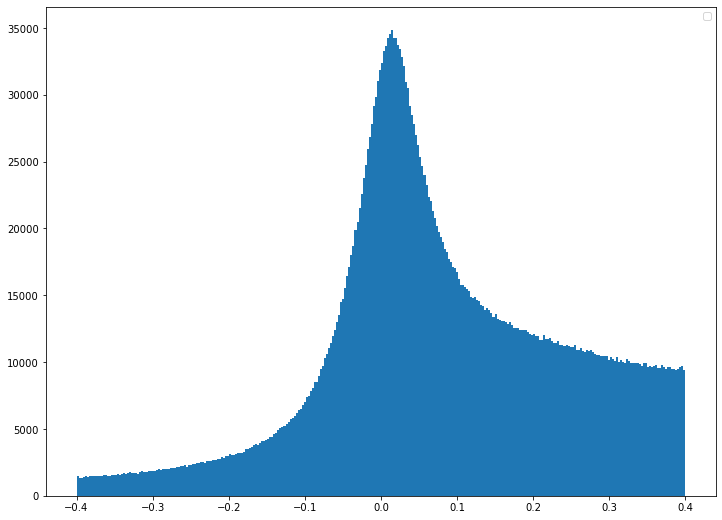

In [24]:

# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

#Plot hist on axes
# ax.hist(rec.mm2_mPim, bins=1, alpha=0.5, label='data', density=False, )
ax.hist(rec.mm2_exclusive.to_numpy(),bins=300, range=(-0.4,0.4), density=False)
# put legend on axes
ax.legend()
# plt.xlim(-0.4, 0.4)

# Show figure
fig.show()

In [6]:
# Create function to
import sys
from scipy import integrate

def mm_cut(df):
#     a = 0.0
    NSIGMA = 4
    cut_data = {}
#              s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'
    # Seclect the data for the sector

    # Make a figure to plot on
    plt.figure(figsize=(12,9))
    # Histogram the data and 
    y, x = np.histogram( df.mm2_exclusive.to_numpy(), 
                                 bins=150, range=(-0.4,0.4), density=False,weights=rec.weight,)
    # here y, x is written because it plot the output as the x and y coordinates on a linegraph.
   
    # calculate bin centers
    x=(x[1:]+x[:-1])/2
#     print(x, y)
    # Plot points on
    plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
    # Make a model with a peak
    peak = BreitWignerModel(prefix="peak_")
    pars = peak.make_params()
    # Set some parameters
    pars['peak_center'].set(value=0.01, min=-0.01, max=0.02)
#     pars['peak_sigma'].set(value=0.05, min=0.0, max=0.1)
    #pars['peak_amplitude'].set(value=0.5) 
    
    # Set the background
    background = PolynomialModel(2, prefix="back_")
#     pars_back = background.make_params()
#     pars_back['pars_back_c0'].set(value=0.1,min=0.)
    
    pars.update(background.guess(y, x=x))
    pars['back_c0'].set(value=0.1,min=0.)
#     print(pars)
                # Make full model to fit
    model = peak + background
        
                # Fit our full model
    out = model.fit(y, pars, x=x)

                # Make a more fine set of x's to plot with
    xs= np.linspace(-0.4, 0.4, 150)
#     print(xs, y) 
                # Plot our output model withe the new parameter and finer x's
    plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')
#     print(y, out.eval(x=xs))
                # Get the components of the fit for our finer x's
    comps = out.eval_components(x=xs)
#     print(comps['peak_'])
                # Plot just the peak component
    plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.4f}, sigma = {out.params['peak_sigma'].value:0.4f},")

    plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.4f}")
#                 Plot center +- sigma where we will cut later
#     plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
#     plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
    plt.axvline(-0.06,)
    plt.axvline(0.08,)
                # Put on labels and show the plot
#                 plt.text(1, 1, 'phi_val = %1f ' % (phi_val))
#                 plt.text(0.5, 0.5, 'theta_val = %1f' % (theta_val))
    plt.title("MMSQ exclusive")
    xs=np.linspace(-0.06, 0.08, num = 27) # , retstep = True
    comps1 = out.eval_components(x=xs)
    total = integrate.simps(out.eval(x=xs))
    peak_out = integrate.simps(comps1['peak_'])
    background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     a +=out.eval(x=xs)
#     help(model.fit)
#     help(background.fit)
    print('total = ', total)
    print('signal = ', peak_out)
    print('background = ', background_out)
    print('ratio = ', peak_out/background_out)
#     print(out.eval(x=xs))

    print(out.fit_report(min_correl=0.5))
    plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
    plt.legend()
    plt.show()
        
# Save cut data to our
    cut_data = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
            out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
            
        

    return cut_data

total =  1320295.9841017327
signal =  1051519.4945488523
background =  268776.48955287994
ratio =  3.9122450639120094
[[Model]]
    (Model(breit_wigner, prefix='peak_') + Model(polynomial, prefix='back_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 334
    # data points      = 150
    # variables        = 7
    chi-square         = 80385700.5
    reduced chi-square = 562137.766
    Akaike info crit   = 1992.75674
    Bayesian info crit = 2013.83118
[[Variables]]
    peak_amplitude:  1693.64304 +/- 93.5441770 (5.52%) (init = 1)
    peak_center:     0.00249785 +/- 5.1182e-04 (20.49%) (init = 0.01)
    peak_sigma:      0.10616034 +/- 0.00112819 (1.06%) (init = 1)
    peak_q:          5.74452838 +/- 0.16432519 (2.86%) (init = 1)
    back_c0:         10195.6818 +/- 217.233650 (2.13%) (init = 0.1)
    back_c1:         16581.7662 +/- 441.527708 (2.66%) (init = 32690.76)
    back_c2:        -13812.7639 +/- 2161.32771 (15.65%) (init = -200970.3)
[[Correlations]

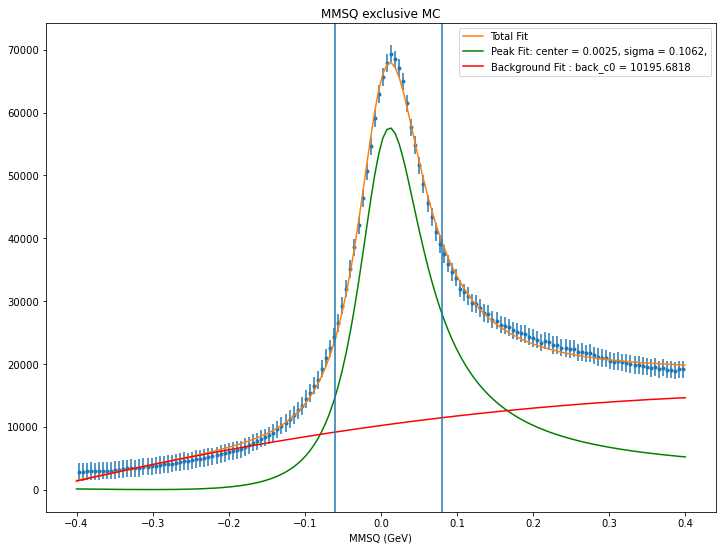

In [7]:
no_cuts = mm_cut(rec)

In [39]:
# Create function to
import sys
from scipy import integrate
import csv

def mm_cut(df):
    with open('out_file_exclusive.csv', mode='w') as out_file:
        out_exclusive_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        out_exclusive_writer.writerow(['w (GeV)','total' ,'signal', 'background', 'ratio'])

    #     a = 0.0
        NSIGMA = 4
        cut_data = {}
        # Makes a list from 0 to 10 spaced by 1
        w_bin_ranges = np.arange(1.0,4.2, 0.05)
#       np.arange(0,10., 5.0)
       # Cuts the mom data into the ranges from above
        rec['w_bin'] = pd.cut(rec.w, w_bin_ranges)
        unique_w = rec.w_bin.unique()
        print(unique_w)
        for w in unique_w:
            data = rec[rec.w_bin == w ]
            s = f'MMSQ W = {w} GeV'
#             sorted(w)
        #              s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'
            # Seclect the data for the sector

            # Make a figure to plot on
            plt.figure(figsize=(12,9))
            # Histogram the data and 
            y, x = np.histogram( data.mm2_exclusive.to_numpy(), 
                                         bins=150, range=(-0.4,0.4), density=False)
            # here y, x is written because it plot the output as the x and y coordinates on a linegraph.

            # calculate bin centers
            x=(x[1:]+x[:-1])/2
        #     print(x, y)
            # Plot points on
            plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
            # Make a model with a peak
            peak = BreitWignerModel(prefix="peak_")
            pars = peak.make_params()
            # Set some parameters
            pars['peak_center'].set(value=0.0, min=-0.01, max=0.02)
        #     pars['peak_sigma'].set(value=0.05, min=0.0, max=0.1)
            #pars['peak_amplitude'].set(value=0.5) 

            # Set the background
            background = PolynomialModel(2, prefix="back_")
        #     pars_back = background.make_params()
        #     pars_back['pars_back_c0'].set(value=0.1,min=0.)

            pars.update(background.guess(y, x=x))
            pars['back_c0'].set(value=0.1,min=0.)
        #     print(pars)
                        # Make full model to fit
            model = peak + background

                        # Fit our full model
            out = model.fit(y, pars, x=x)

                        # Make a more fine set of x's to plot with
            xs= np.linspace(-0.4, 0.4, 150)
        #     print(xs, y) 
                        # Plot our output model withe the new parameter and finer x's
            plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')
        #     print(y, out.eval(x=xs))
                        # Get the components of the fit for our finer x's
            comps = out.eval_components(x=xs)
        #     print(comps['peak_'])
                        # Plot just the peak component
            plt.plot(xs, comps['peak_'], 
                            'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.4f}, sigma = {out.params['peak_sigma'].value:0.4f},")

            plt.plot(xs, comps['back_'], 'r-',
                            label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
        #                 Plot center +- sigma where we will cut later
#             plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
#             plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
            plt.axvline(-0.06,)
            plt.axvline(0.08,)
                        # Put on labels and show the plot
        #                 plt.text(1, 1, 'phi_val = %1f ' % (phi_val))
        #                 plt.text(0.5, 0.5, 'theta_val = %1f' % (theta_val))
            plt.title(s)
            xs=np.linspace(-0.06, 0.08, num = 27) # , retstep = True
            comps1 = out.eval_components(x=xs)
            total = integrate.simps(out.eval(x=xs))
            peak_out = integrate.simps(comps1['peak_'])
            background_out = integrate.simps(comps1['back_'])

        #                 f = background # lambda x:exp(-x**2)
        #                 TotalInt = intg.quad(f, -0.1, 0.11)
        #     a +=out.eval(x=xs)
        #     help(model.fit)
        #     help(background.fit)
            out_exclusive_writer.writerow([w,int(total) ,int(peak_out), int(background_out), "{:.2f}".format(peak_out/background_out)])
    #         print(int(total),',' ,int(peak_out),',' , int(background_out),',', "{:.2f}".format(peak_out/background_out))
        #     print('signal = ', peak_out.value)
        #     print('background = ', background_out)
        #     print('ratio = ', (peak_out/background_out))
        #     print(out.eval(x=xs))

#             print(out.fit_report(min_correl=0.5))
            plt.xlabel('MMSQ (GeV)')
        #             plt.ylabel('Y')
            plt.legend()
            plt.show()
        # Save cut data to our
            cut_data = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                    out.params['peak_center']+NSIGMA*out.params['peak_sigma'])

    return cut_data

[(1.6, 1.65], (2.5, 2.55], (2.35, 2.4], (1.95, 2.0], (1.1, 1.15], ..., (1.15, 1.2], (1.0, 1.05], (1.05, 1.1], (4.05, 4.1], (4.1, 4.15]]
Length: 64
Categories (63, interval[float64]): [(1.0, 1.05] < (1.05, 1.1] < (1.1, 1.15] < (1.15, 1.2] ... (3.95, 4.0] < (4.0, 4.05] < (4.05, 4.1] < (4.1, 4.15]]


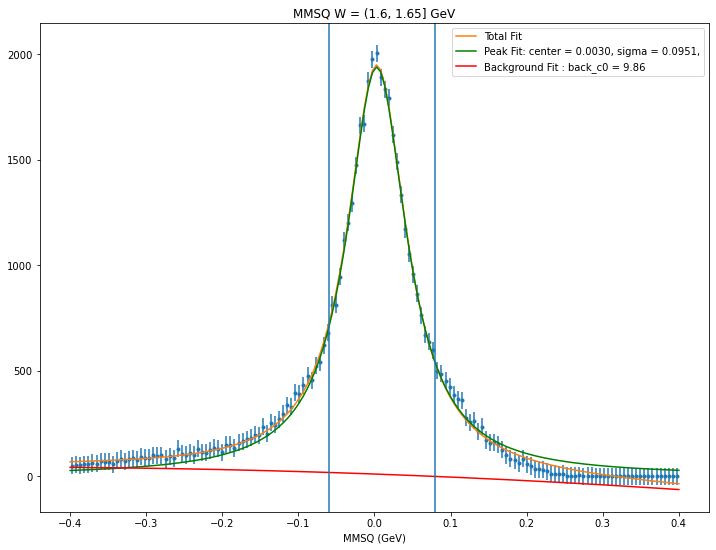

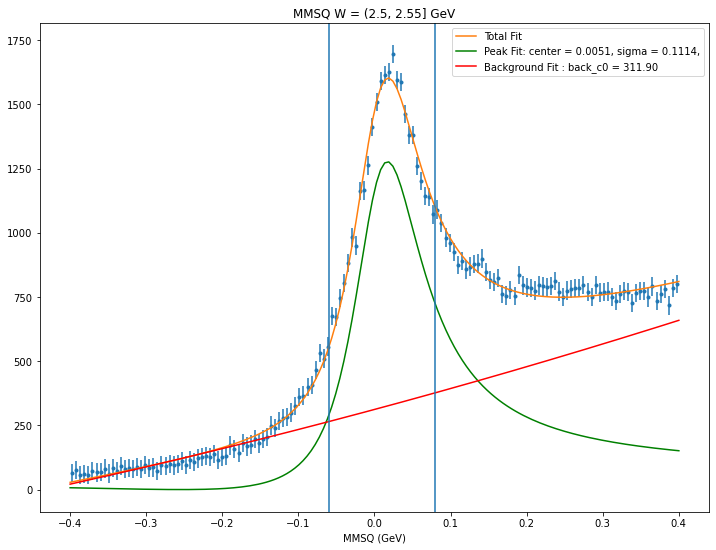

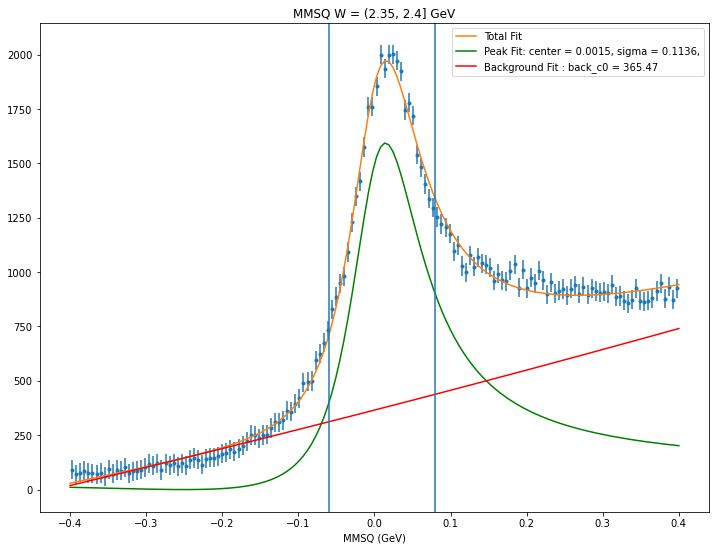

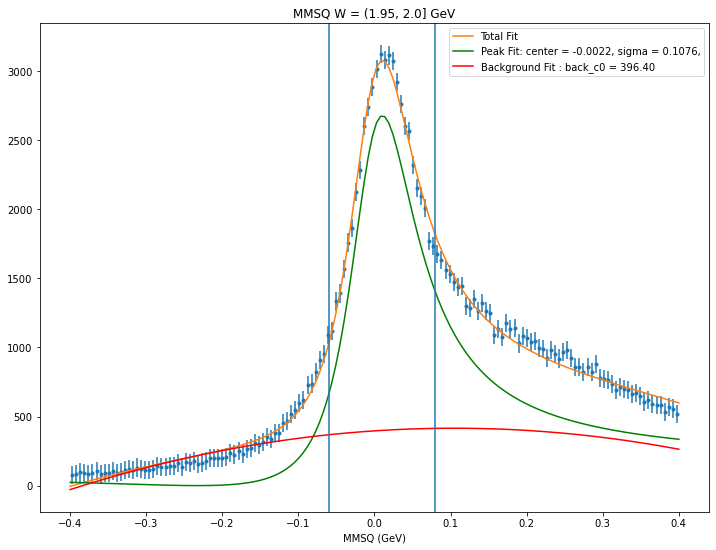

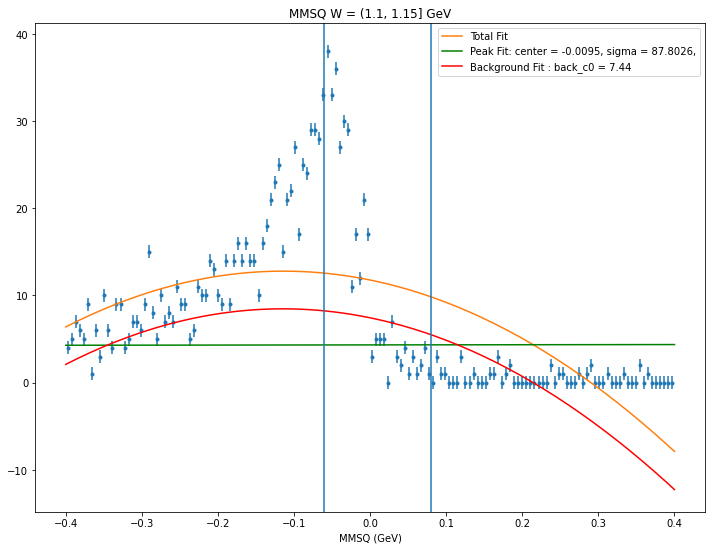

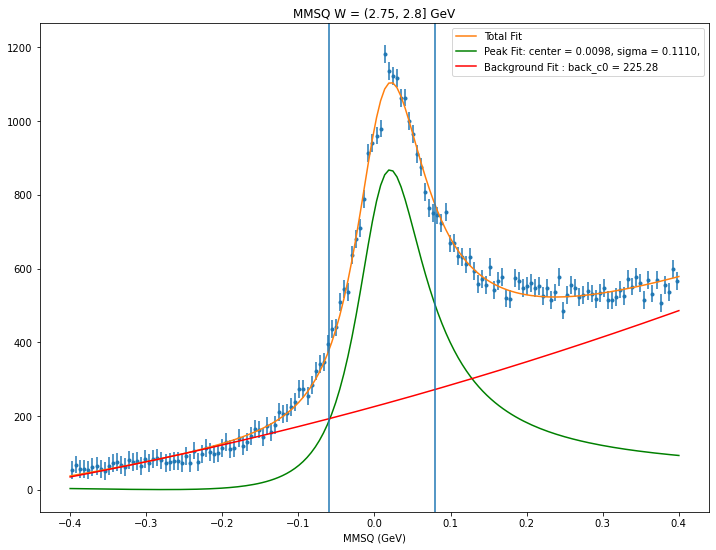

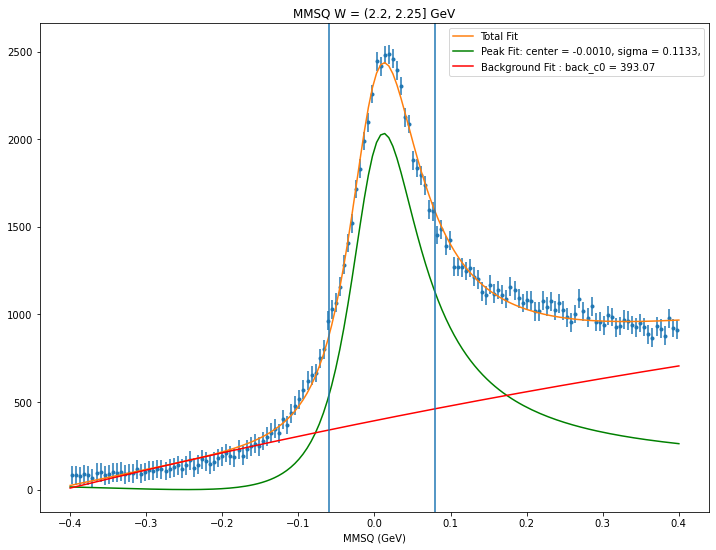

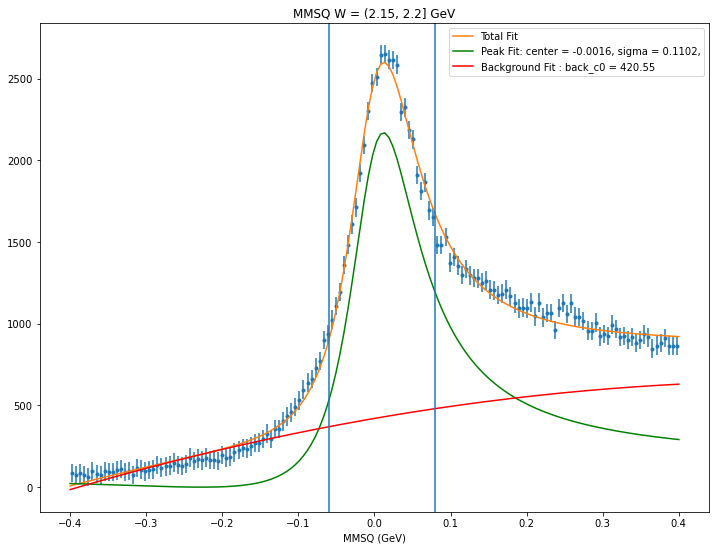

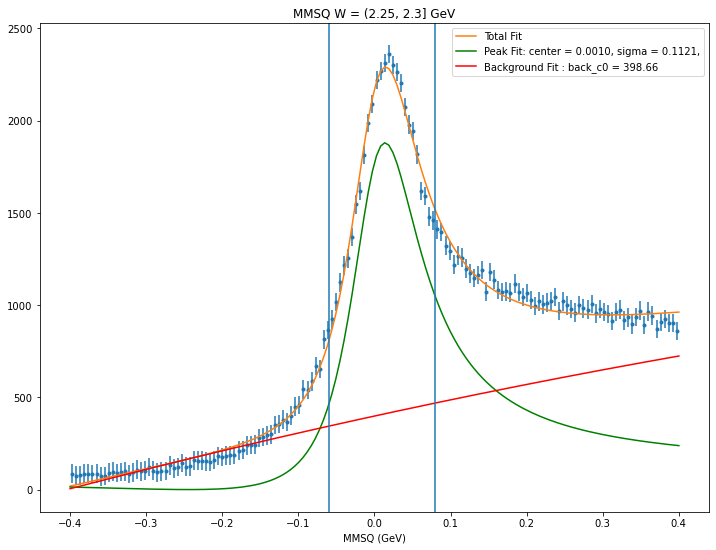

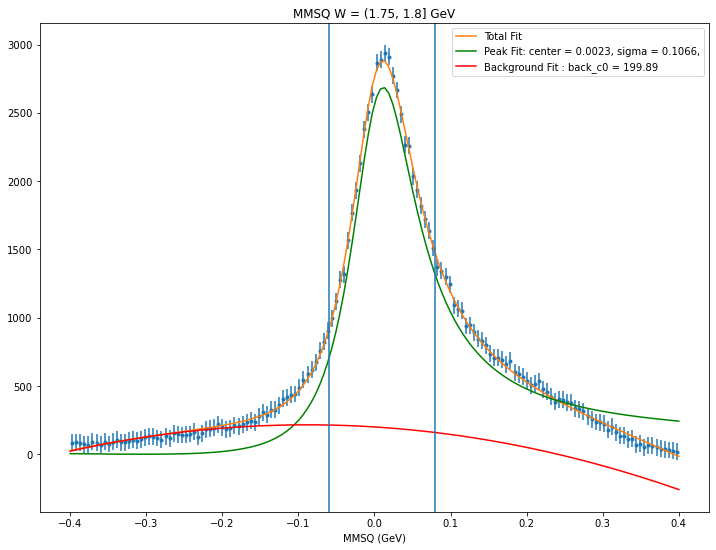

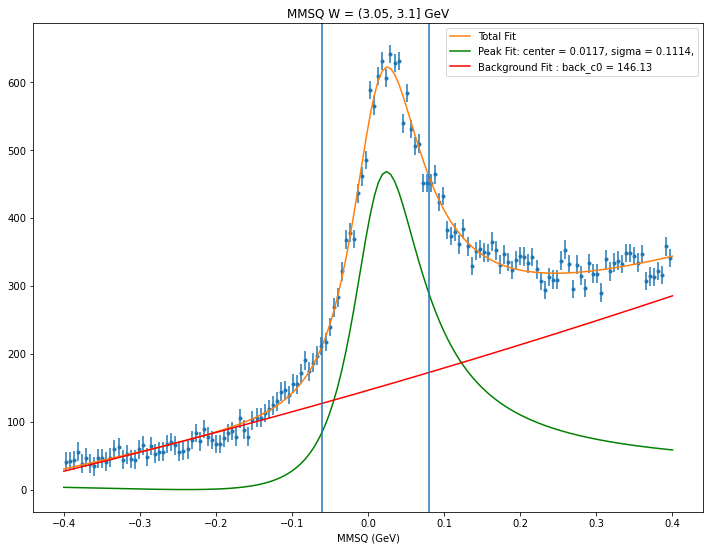

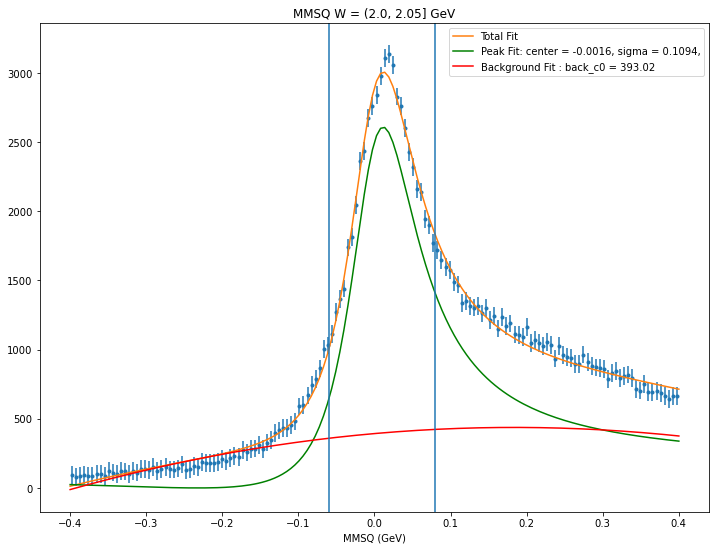

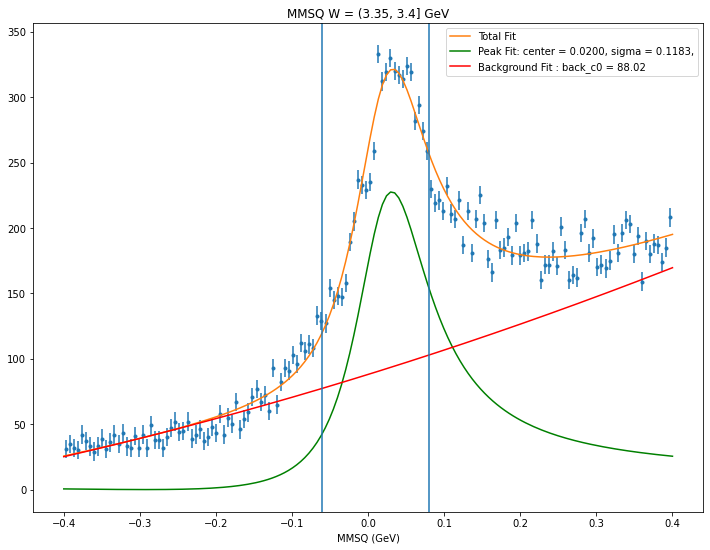

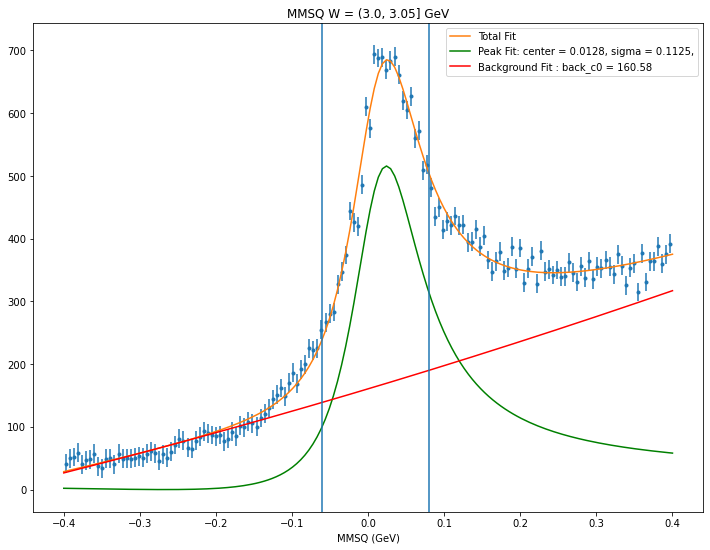

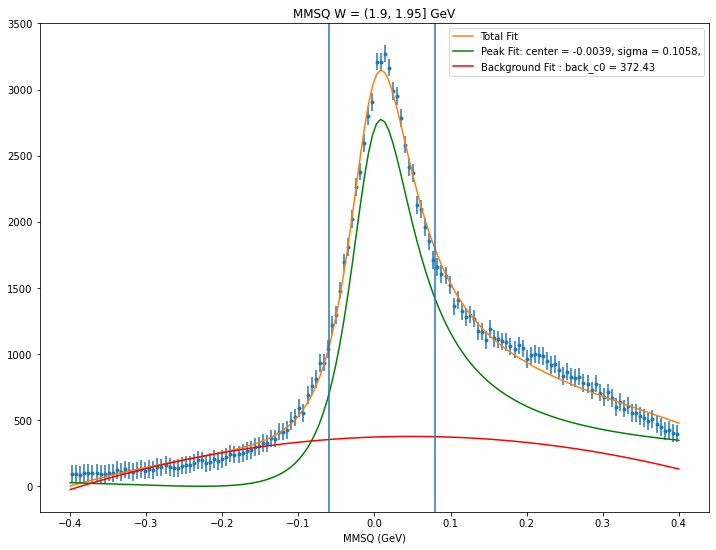

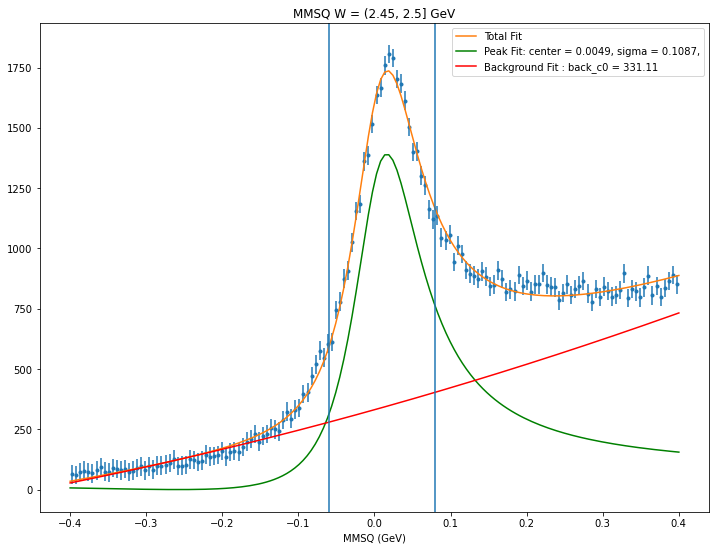

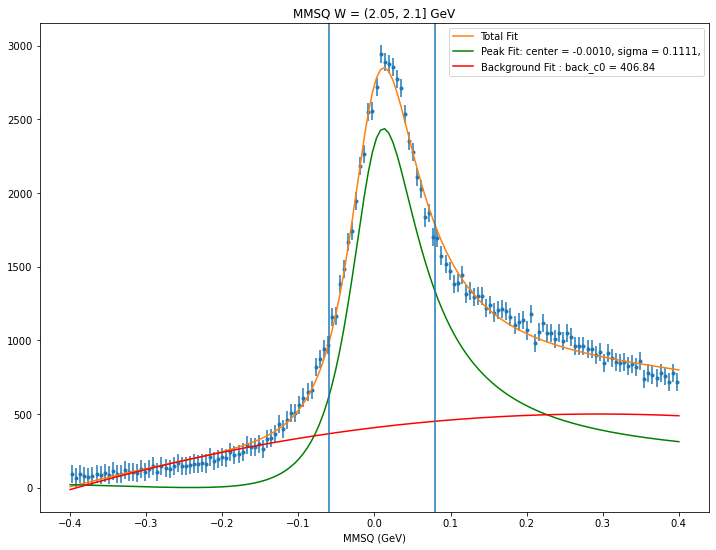

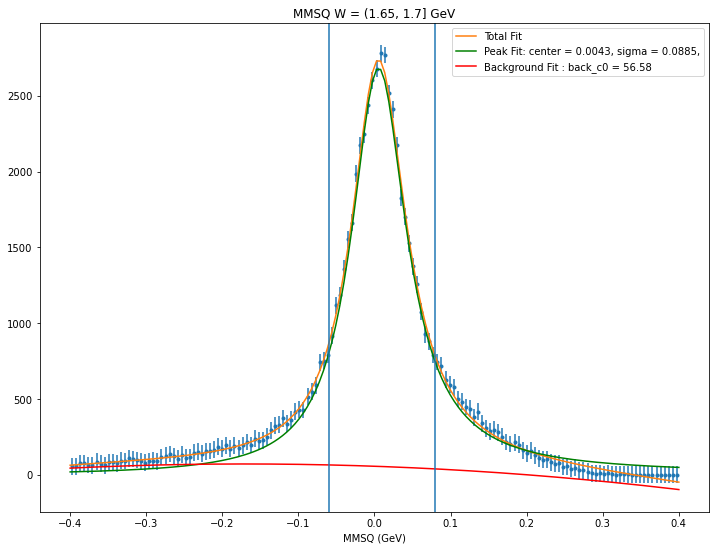

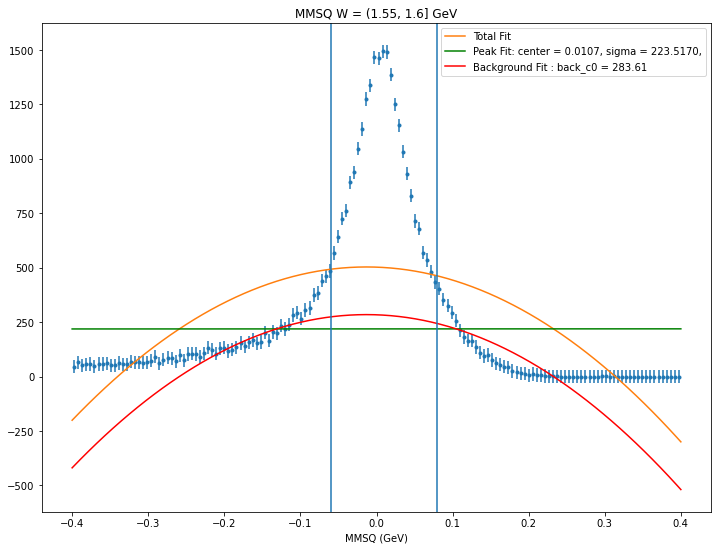

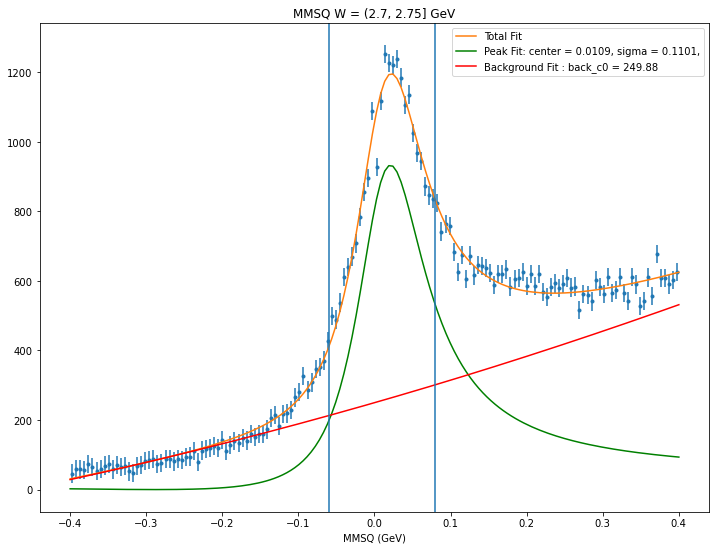

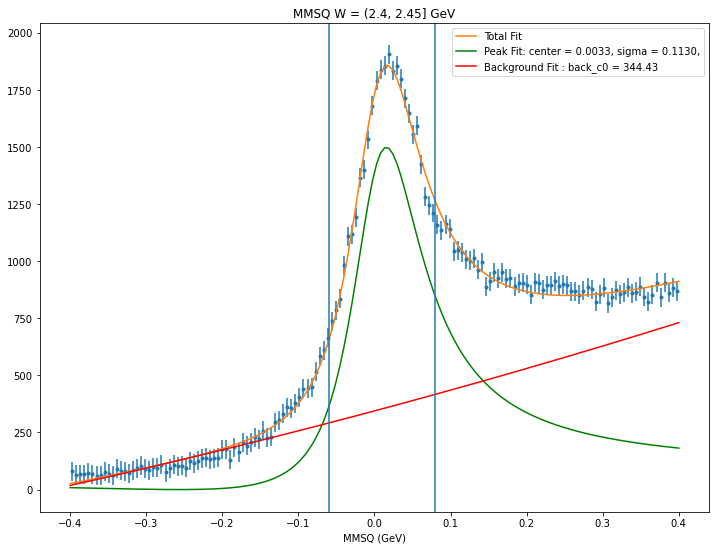

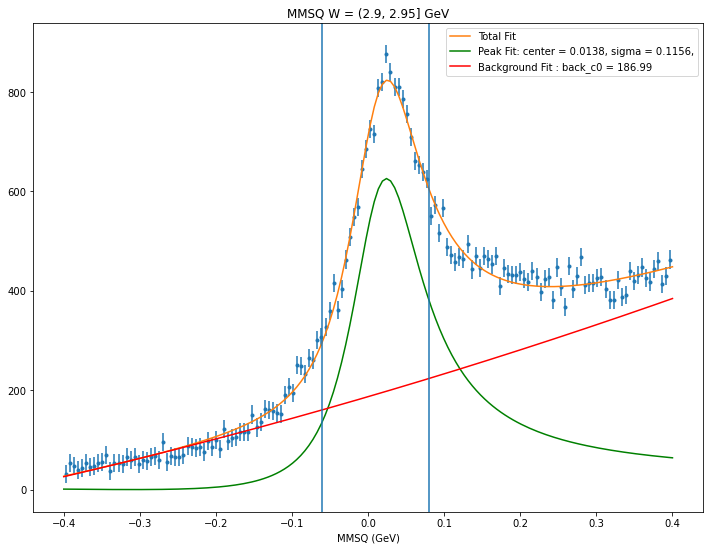

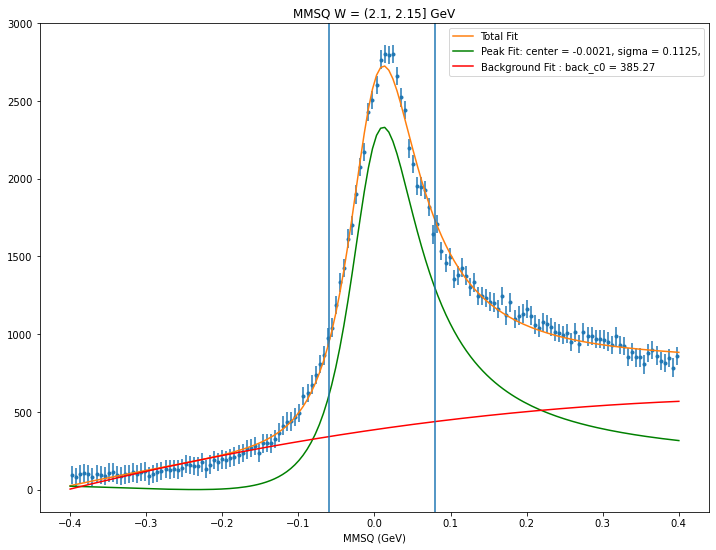

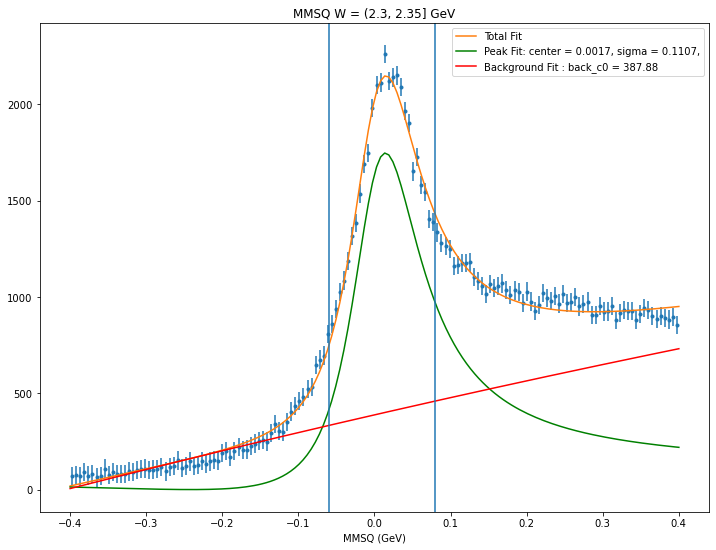

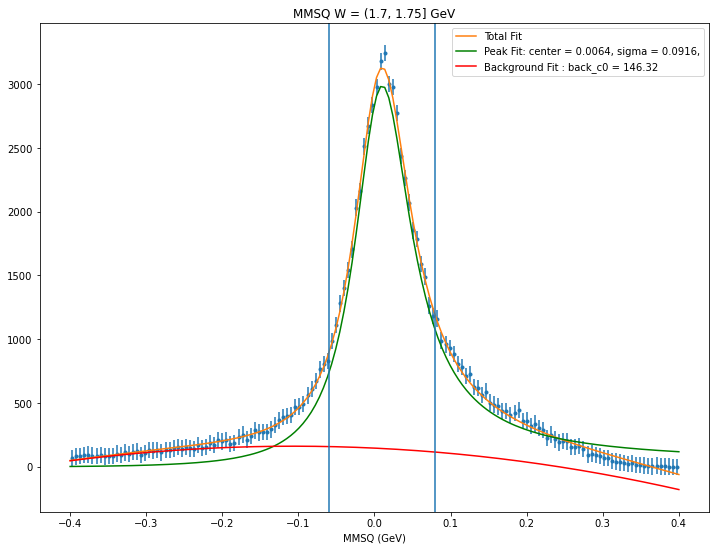

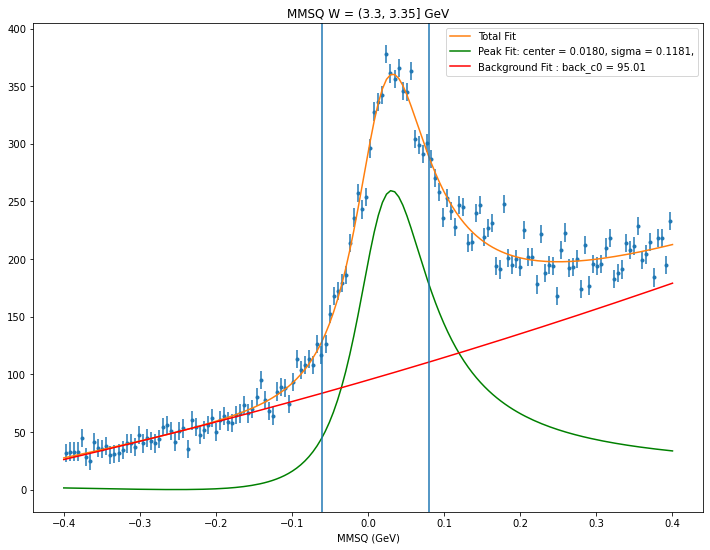

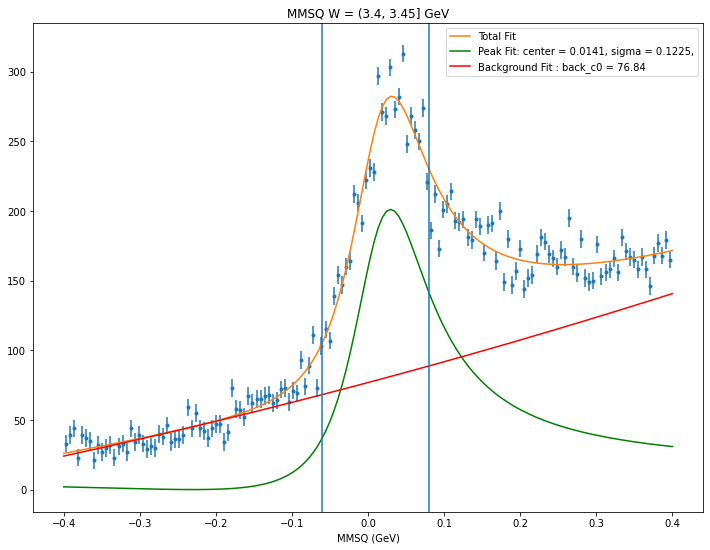

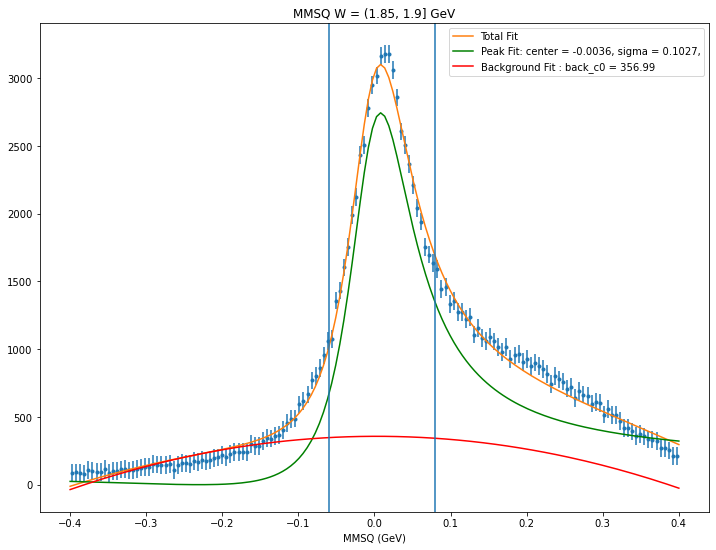

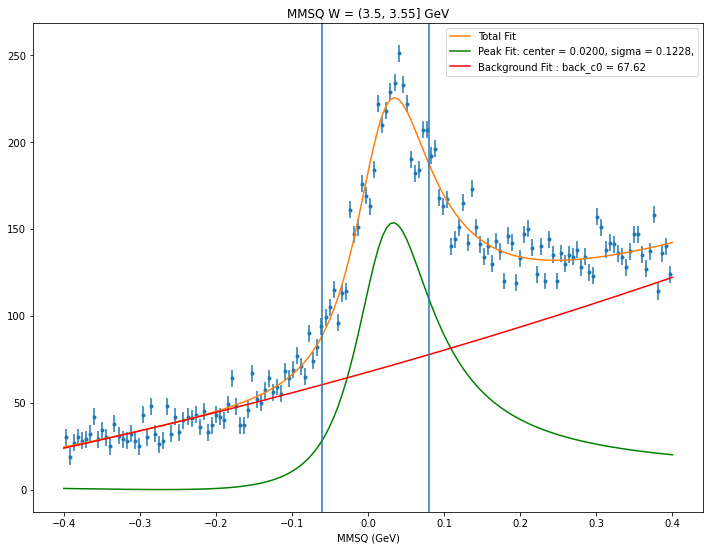

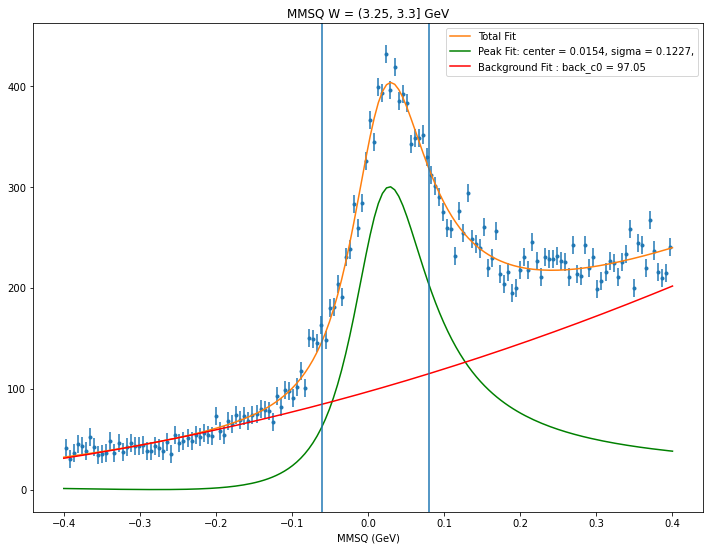

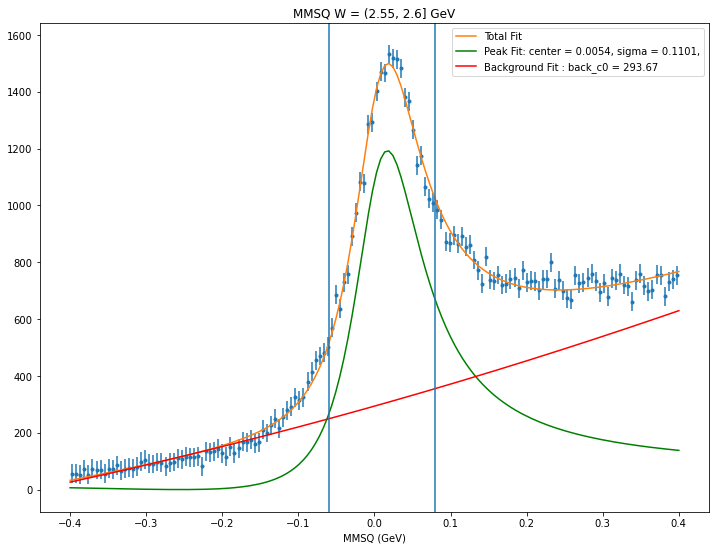

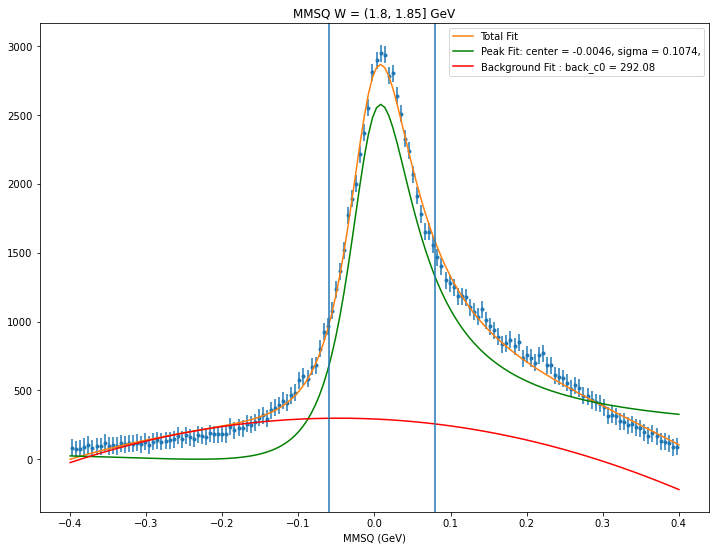

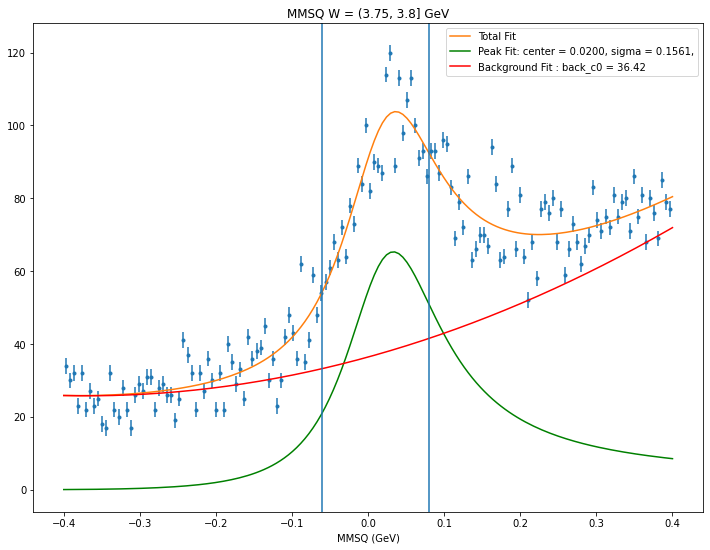

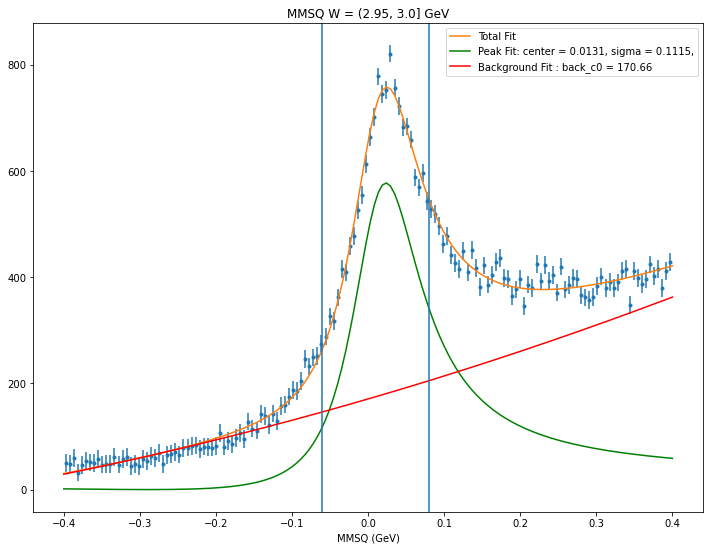

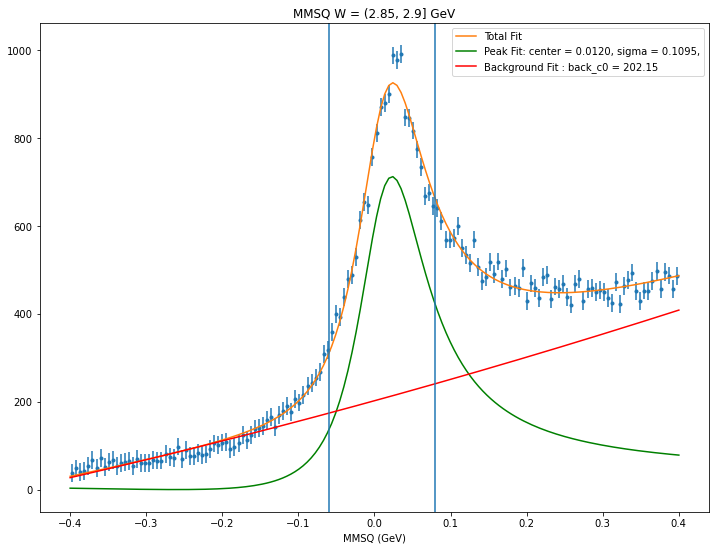

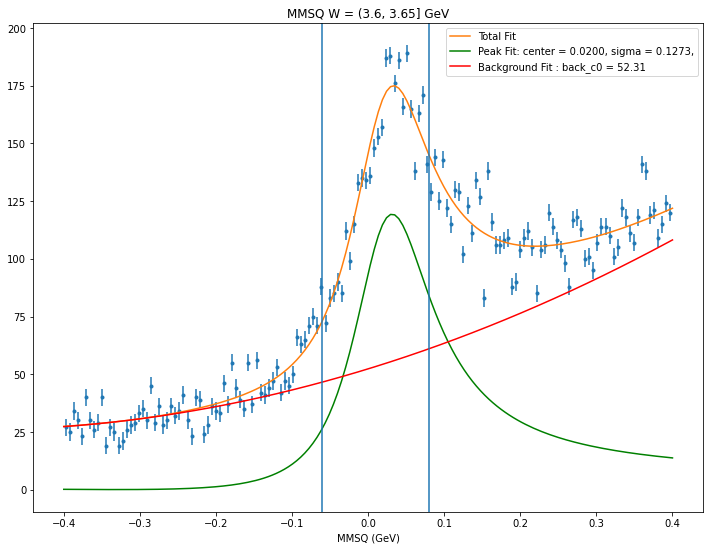

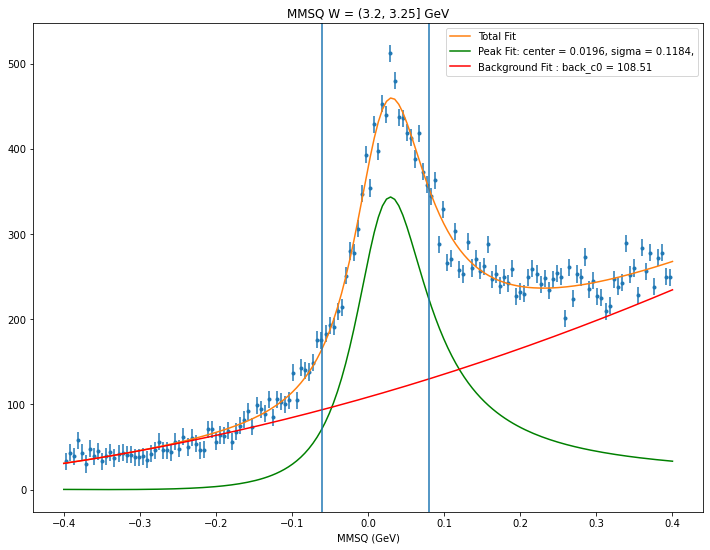

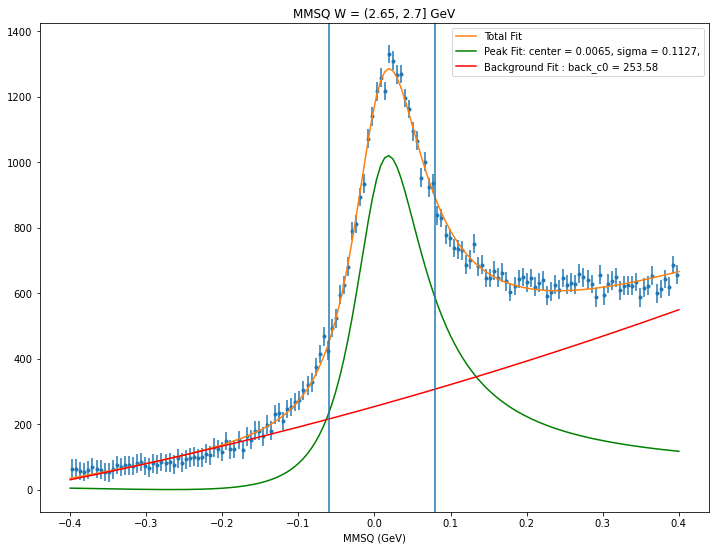

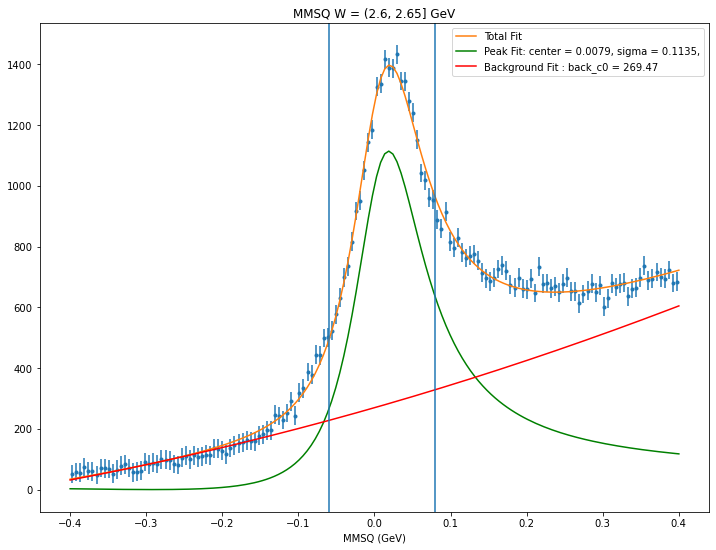

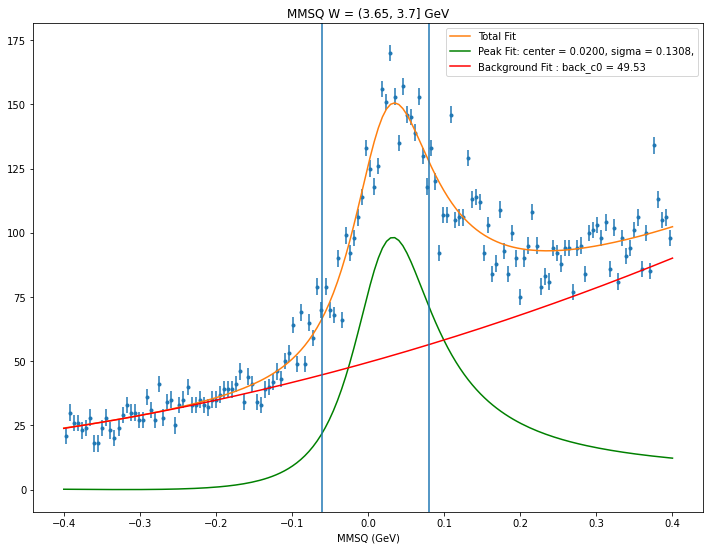

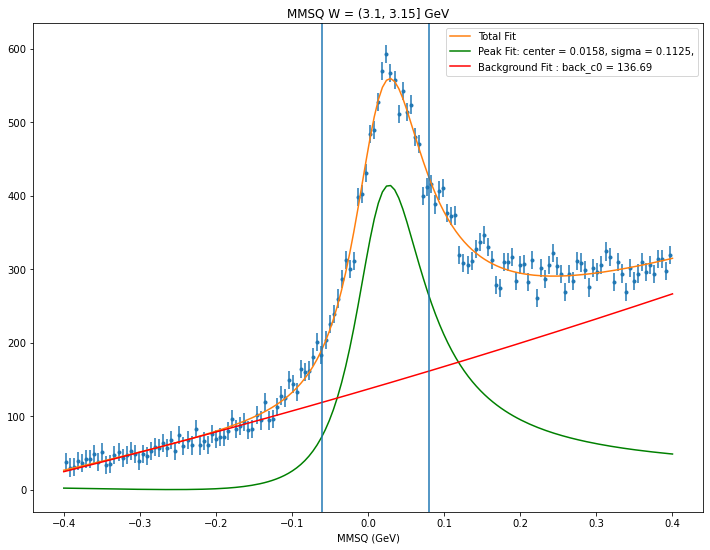

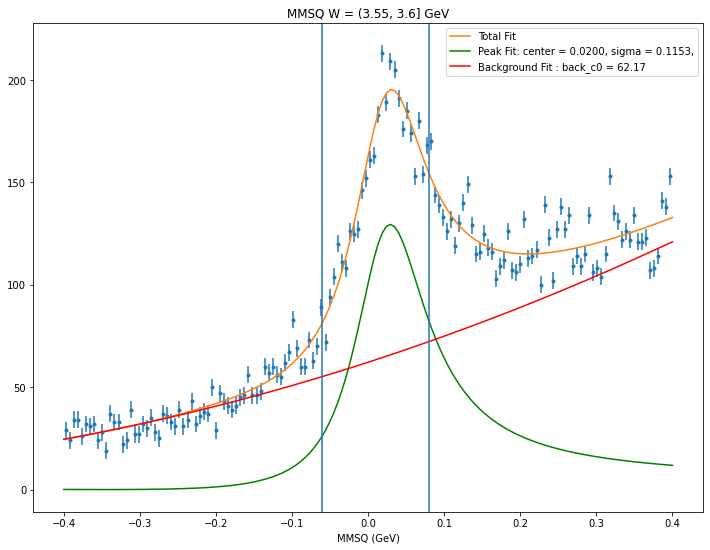

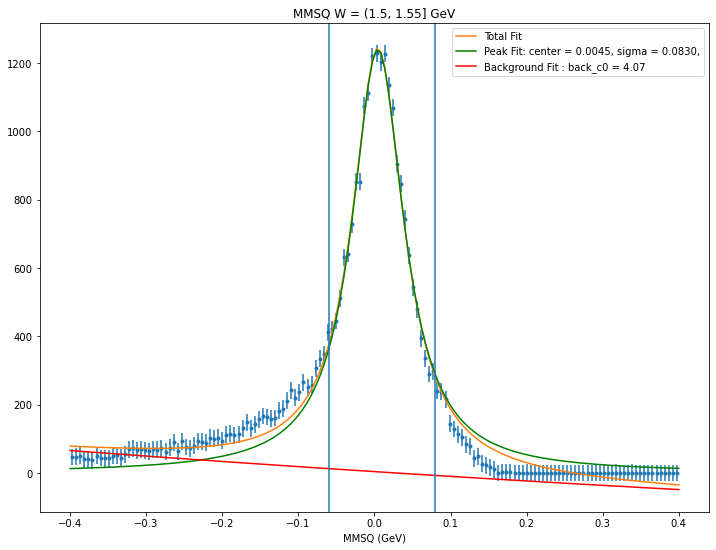

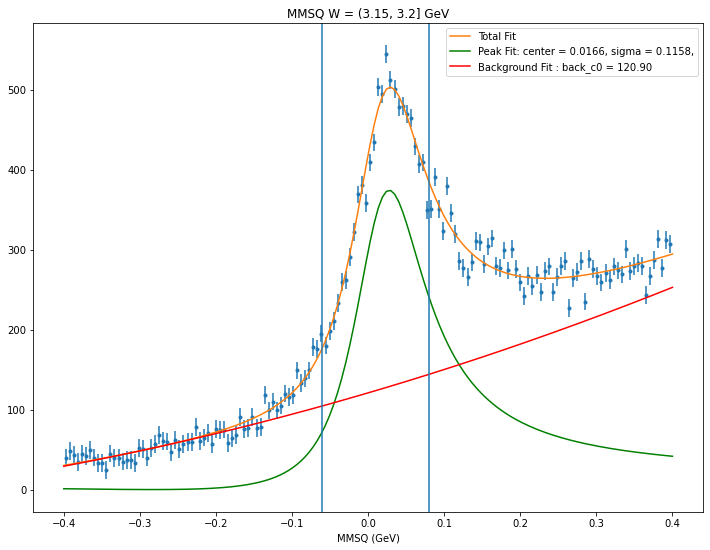

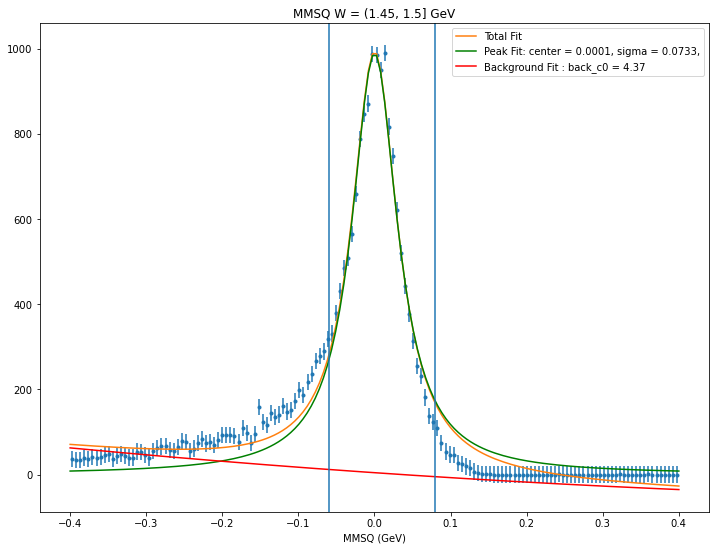

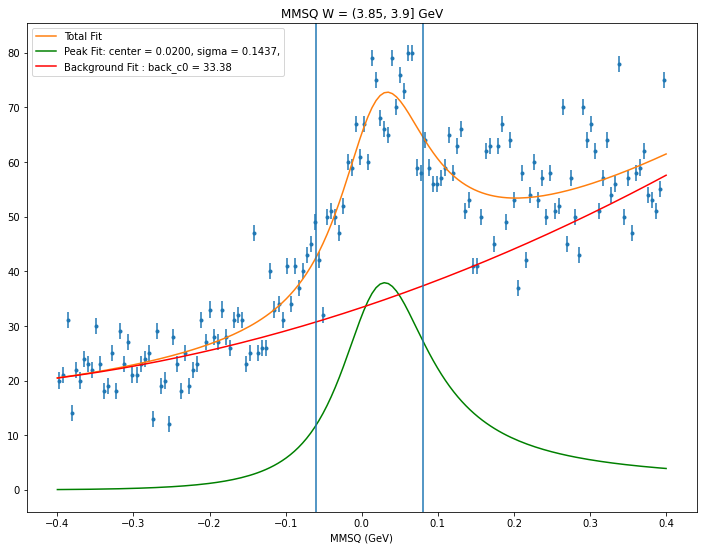

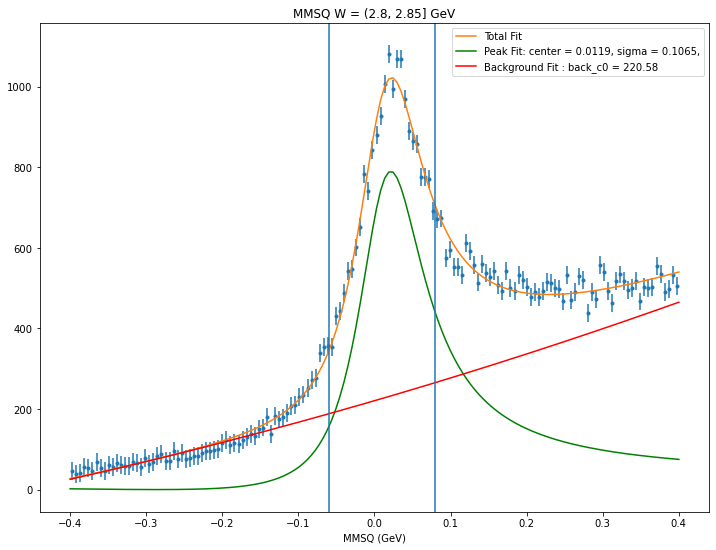

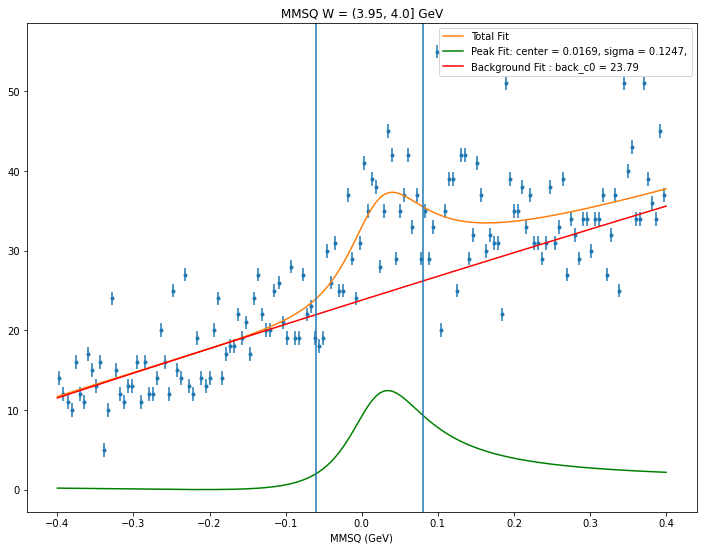

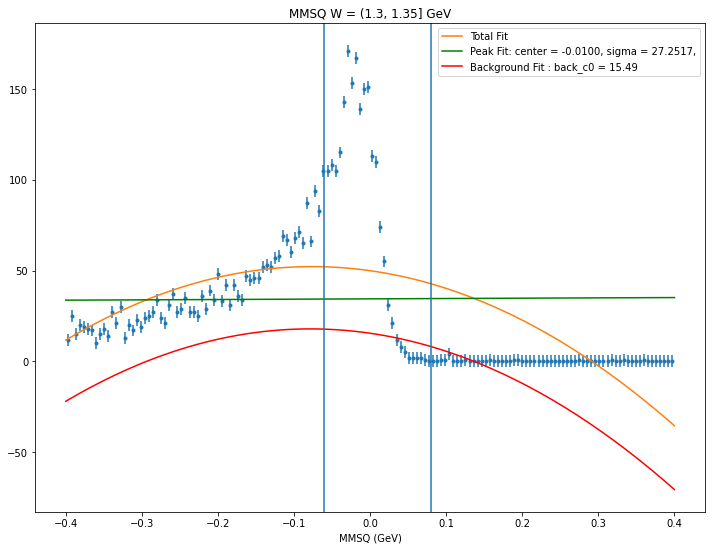

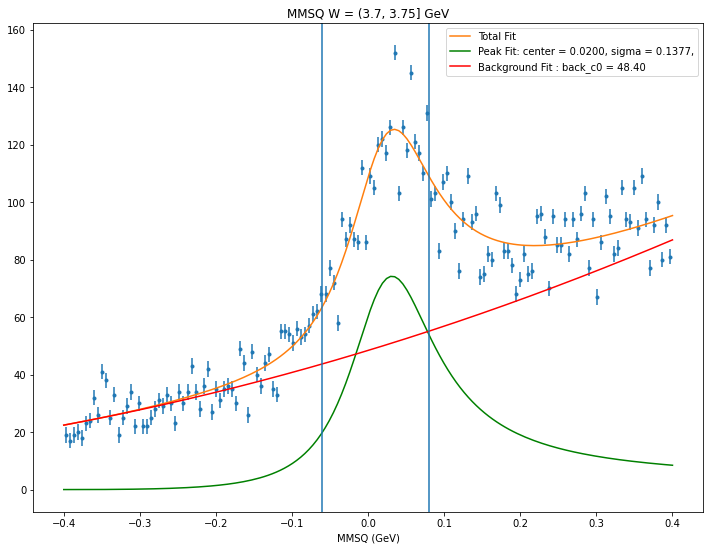

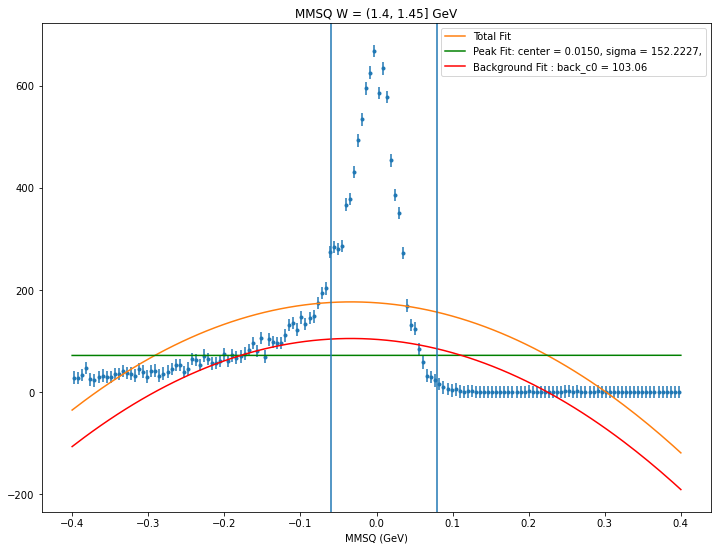

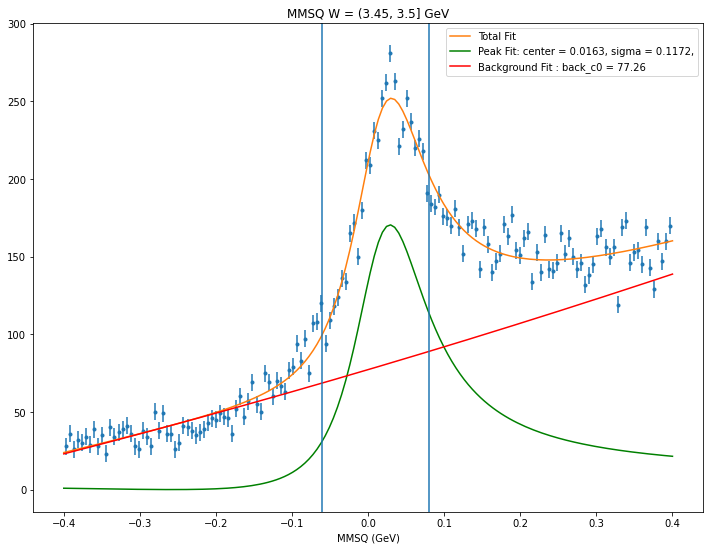

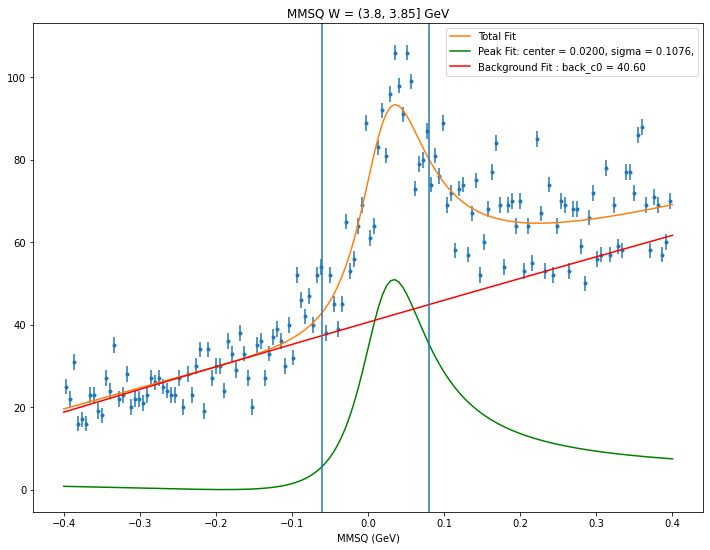

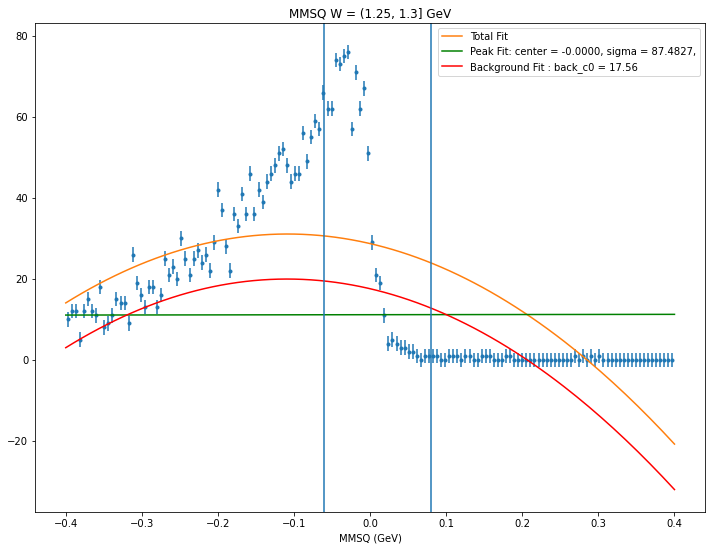

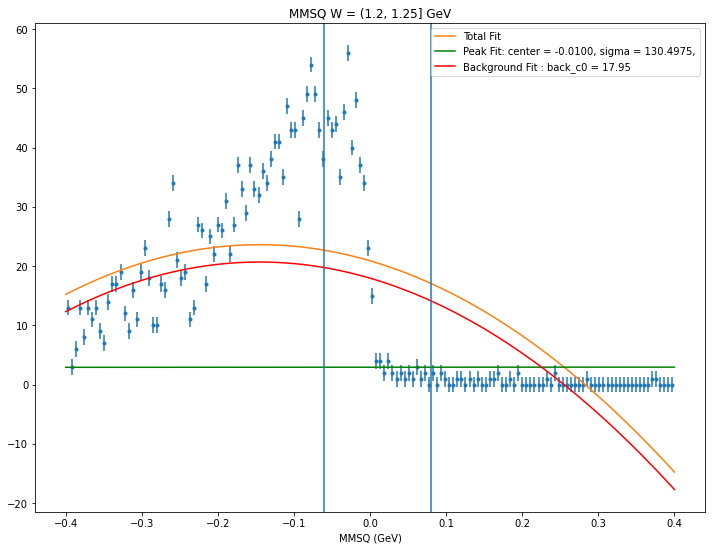

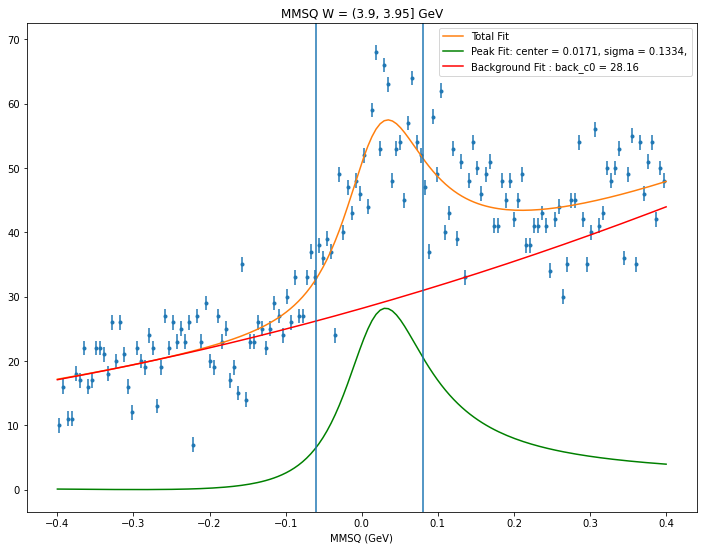

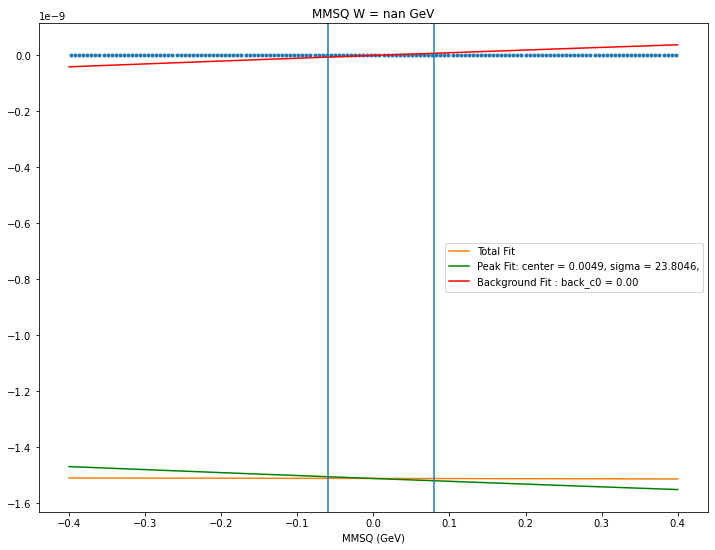

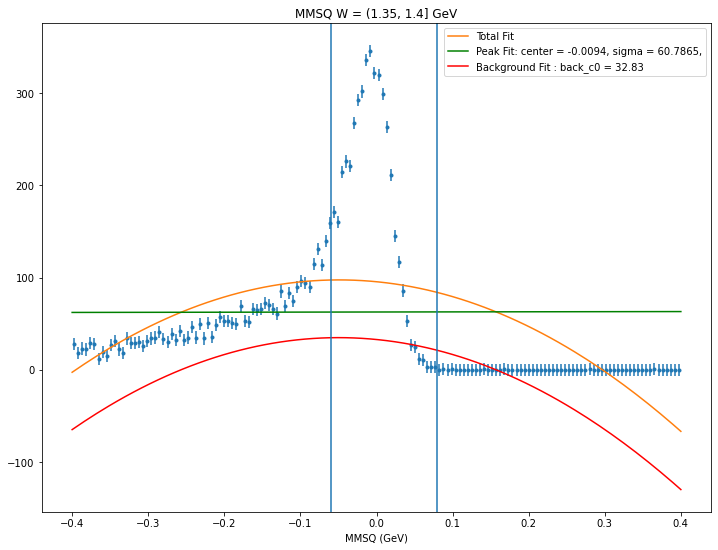

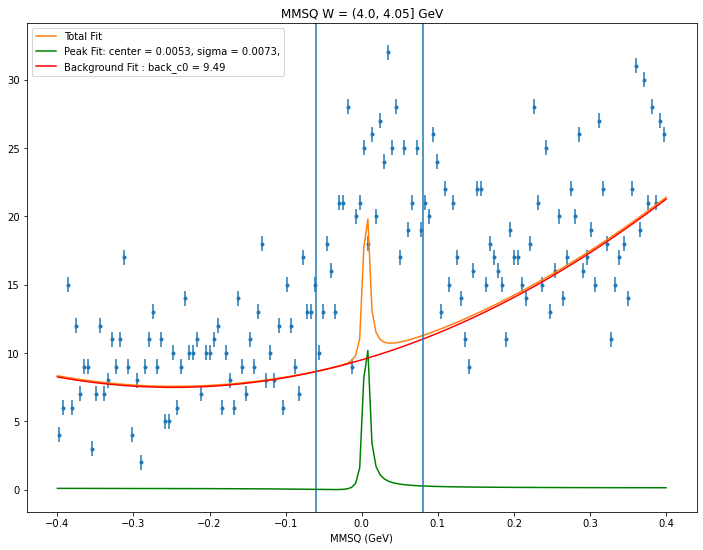

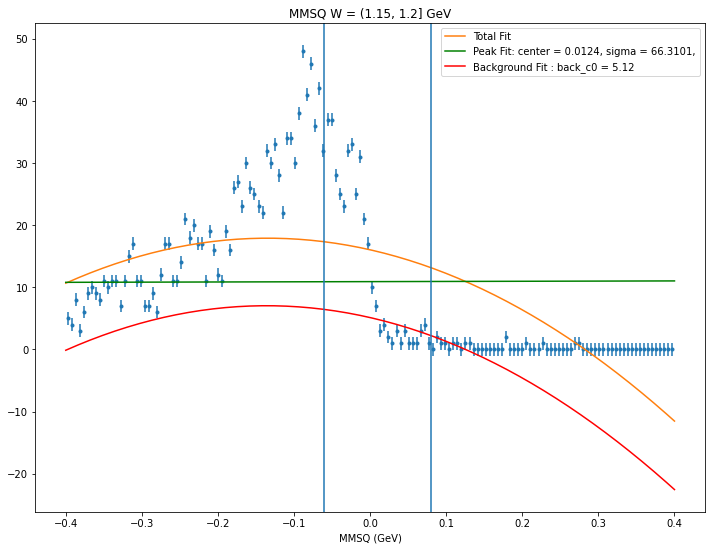

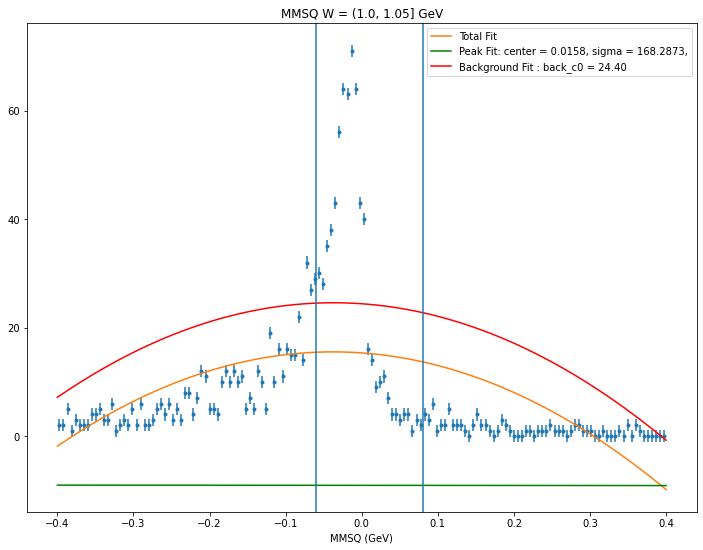

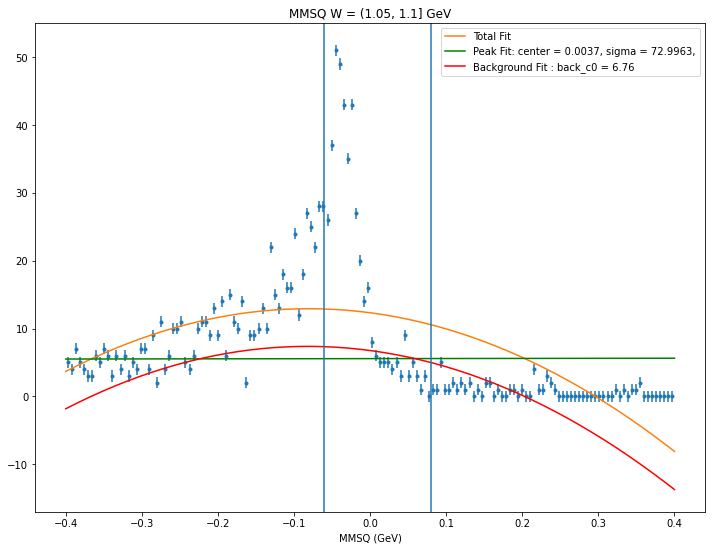

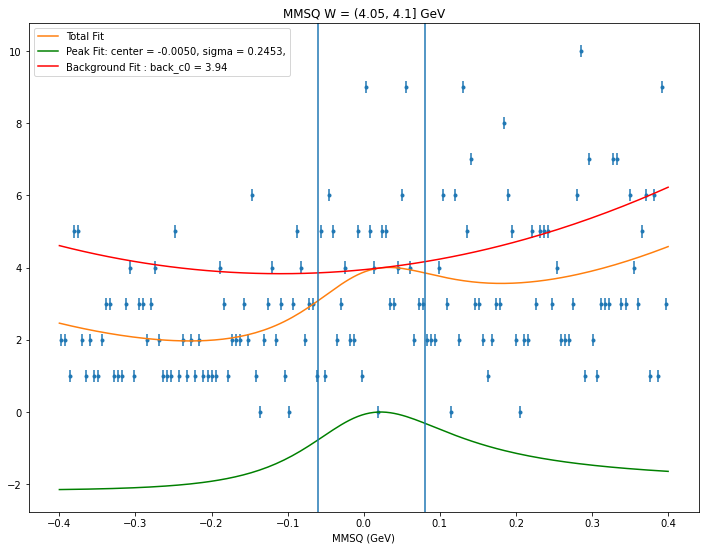

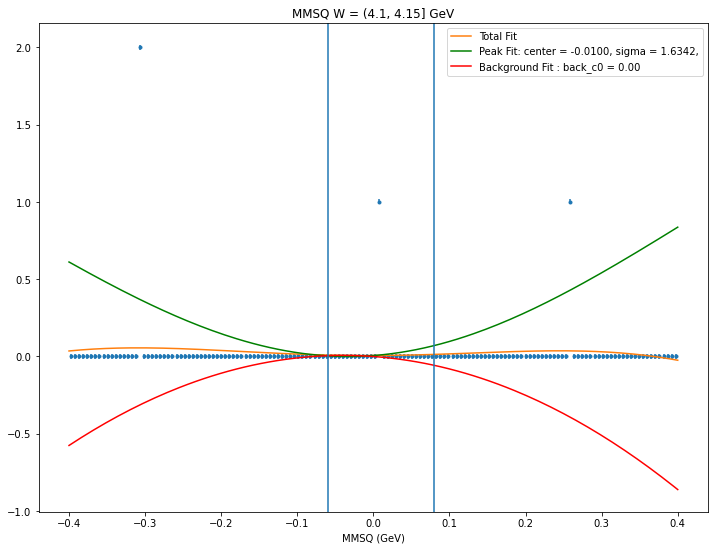

In [40]:
sector_cuts = mm_cut(rec)

In [20]:
# Create function to
import sys
from scipy import integrate
def mm_cut(df):
 
    NSIGMA = 4
    cut_data = {}
    # Makes a list from 0 to 10 spaced by 1
    mom_bin_ranges = [0, 1, 2, 3, 10]
#    np.arange(0,10., 5.0)
    # Cuts the mom data into the ranges from above
    rec['mom_bin'] = pd.cut(rec.pim_mom_exclusive, mom_bin_ranges)
    unique_mom = rec.mom_bin.unique()
    print(unique_mom)
    # Makes a list from 0 to 180 spaced by 18
#     theta_bin_ranges = np.arange(0,180.1, 90.0)
    theta_bin_ranges = [0,18,36, 180]
    # Cuts the theta data into the ranges from above
    rec['theta_bin'] = pd.cut(rec.pim_theta_exclusive, theta_bin_ranges)
    unique_theta = rec.theta_bin.unique()
    
    # Makes a list from 0 to 360 spaced by 120
    phi_bin_ranges = [0, 180, 360]
#     np.arange(0,361, 180.0)
    # Cuts the phi data into the ranges from above
    rec['phi_bin'] = pd.cut(rec.pim_phi_exclusive, phi_bin_ranges)
    unique_phi = rec.phi_bin.unique()
    
    for mom in unique_mom:
        data = rec[rec.mom_bin == mom]
#                    & (rec.mom_bin != np.isnan)]
#         for theta in unique_theta:
# #             data = rec[rec.theta_bin == theta]
#             for phi in unique_phi:
# #                 data = rec[rec.phi_bin == phi] 
#                 data = rec[(rec.mom_bin == mom) & (rec.theta_bin == theta) & (rec.phi_bin == phi)
#                           &  (rec.mom_bin != np.isnan)] 
                
#       The bin edges are saved as left and right
#         print(phi.left, phi.right)
#                 s = f'{mom.left}_{theta.left}_{phi.left}'
        s = f'MMSQ mom={mom} GeV' 
#     \u03B8 = {theta}  $\phi$ = {phi}'
#                 s = "MMSQ-Mom = ("+str(mom.left)+"-"+str(mom.right)+') GeV_'+'\u03B8 = (' + str(theta.left)+"-"+str(theta.right)+")\u00B0_"+"\u03C6 = ("+str(phi.left)+'-'+str(phi.right)+')\u00B0'
        # Make a figure to plot on
        plt.figure(figsize=(12,9))
        # Histogram the data and 
        y,x = np.histogram(data.mm2_exclusive.to_numpy(), 
                         bins=300, range=(-0.4,0.4), density=False)

        # calculate bin centers
        x=(x[1:]+x[:-1])/2

        # Plot points on
        plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

        # Make a model with a peak
        peak = BreitWignerModel(prefix="peak_")
        pars = peak.make_params()
        # Set some parameters
        pars['peak_center'].set(value=0, min=-0.20, max=0.2)
        #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
        #pars['peak_amplitude'].set(value=0.5)

        # Set the background
        background =  PolynomialModel(2, prefix="back_")
        pars.update(background.guess(y, x=x))
        pars['back_c0'].set(value=0.1,min=0.)

        # Make full model to fit
        model = peak + background

        # Fit our full model
        out = model.fit(y, pars, x=x)

        # Make a more fine set of x's to plot with
        xs= np.linspace(-0.4, 0.4, 300)

        # Plot our output model withe the new parameter and finer x's
        plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

        # Get the components of the fit for our finer x's
        comps = out.eval_components(x=xs)
        # Plot just the peak component
        plt.plot(xs, comps['peak_'], 
            'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

        plt.plot(xs, comps['back_'], 'r-',
            label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
        # Plot center +- sigma where we will cut later
        #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
        #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        plt.axvline(-0.06,color='r')
        plt.axvline(0.08,color='r')
        # Put on labels and show the plot
        plt.title(s)
        xs=np.linspace(-0.06, 0.08, num = 53) # , retstep = True
        comps1 = out.eval_components(x=xs)
        total = integrate.simps(out.eval(x=xs))
        peak_out = integrate.simps(comps1['peak_'])
        background_out = integrate.simps(comps1['back_'])

#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     help(model.fit)
        print('total = ', total)
        print('signal = ', peak_out)
        print('background = ', background_out)
        print('ratio = ', peak_out/background_out)
        plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
        plt.legend()
        plt.show()
#                 print(mom)
#                 print(theta)
#                 print(phi)
    # Save cut data to our
        cut_data[mom]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                        out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
    return cut_data

[(1.0, 2.0], (0.0, 1.0], (2.0, 3.0], (3.0, 10.0], NaN]
Categories (4, interval[int64]): [(0, 1] < (1, 2] < (2, 3] < (3, 10]]
total =  419079.5027184069
signal =  328386.9595812262
background =  90692.54313718063
ratio =  3.6208815876351754


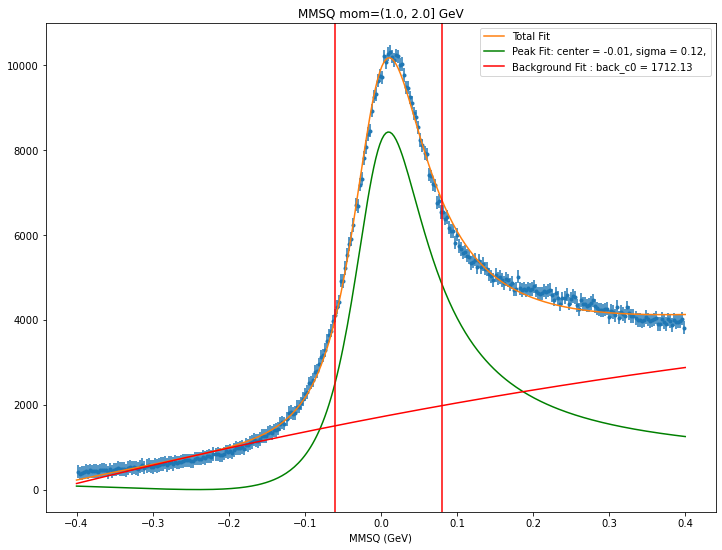

total =  638408.8957099074
signal =  577425.9406092783
background =  60982.95510062904
ratio =  9.468644798476191


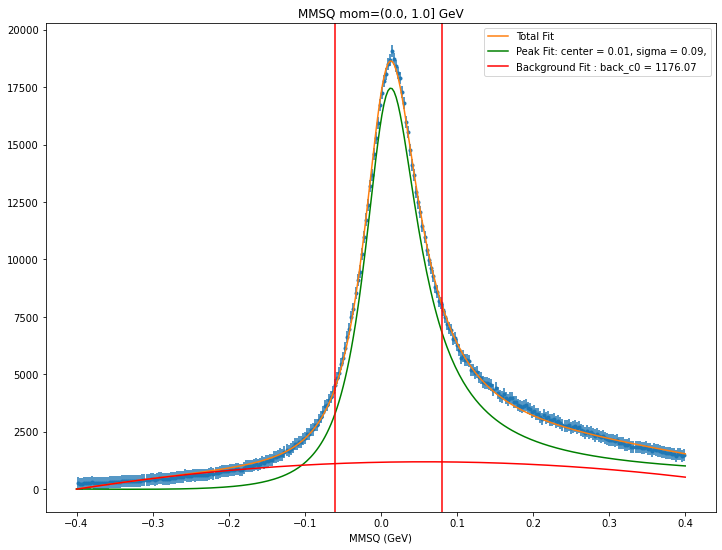

total =  154928.98373261612
signal =  110479.71040464388
background =  44449.273327972274
ratio =  2.485523432283383


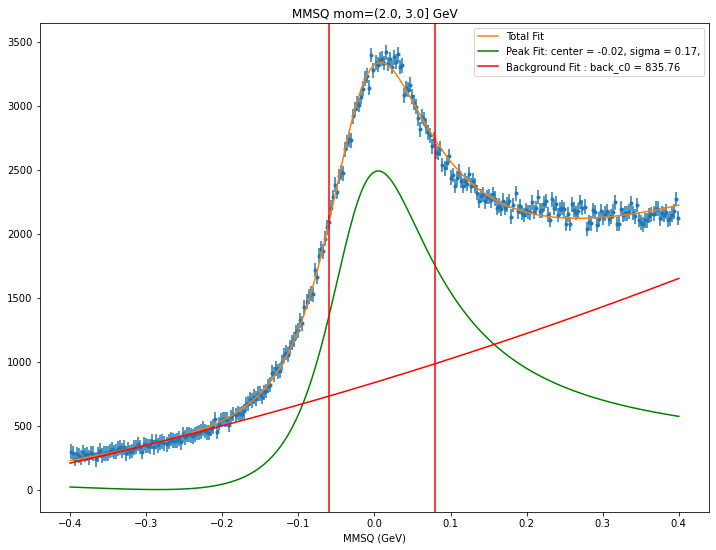

total =  105673.86706731713
signal =  60382.149876539115
background =  45291.717190778
ratio =  1.333183054689605


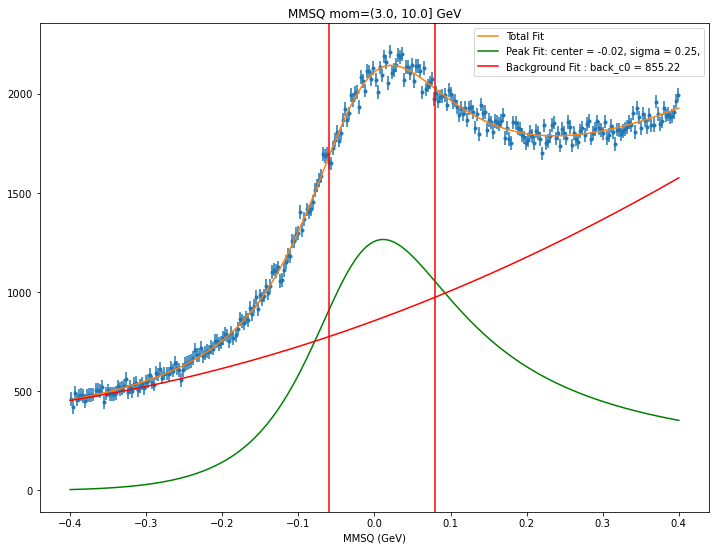

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


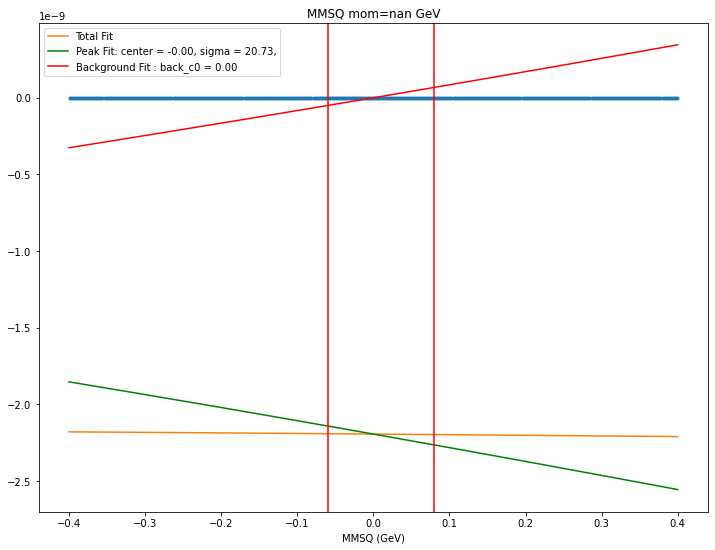

In [21]:
mom_cuts = mm_cut(rec)

In [50]:
# Create function to
import sys
from scipy import integrate
def mm_cut(df):
 
    NSIGMA = 4
    cut_data = {}
    # Makes a list from 0 to 10 spaced by 1
    mom_bin_ranges = [0, 1, 2, 3, 10]
#    np.arange(0,10., 5.0)
    # Cuts the mom data into the ranges from above
    rec['mom_bin'] = pd.cut(rec.pim_mom_exclusive, mom_bin_ranges)
    unique_mom = rec.mom_bin.unique()
    print(unique_mom)
    # Makes a list from 0 to 180 spaced by 18
#     theta_bin_ranges = np.arange(0,180.1, 90.0)
    theta_bin_ranges = [0,18,36, 180]
    # Cuts the theta data into the ranges from above
    rec['theta_bin'] = pd.cut(rec.pim_theta_exclusive, theta_bin_ranges)
    unique_theta = rec.theta_bin.unique()
    
    # Makes a list from 0 to 360 spaced by 120
    phi_bin_ranges = [0, 180, 360]
#     np.arange(0,361, 180.0)
    # Cuts the phi data into the ranges from above
    rec['phi_bin'] = pd.cut(rec.pim_phi_exclusive, phi_bin_ranges)
    unique_phi = rec.phi_bin.unique()
    
    
    for mom in unique_mom:
#         data = rec[rec.mom_bin == mom]
        for theta in unique_theta:
#             data = rec[rec.theta_bin == theta]
            for phi in unique_phi:
#                 data = rec[rec.phi_bin == phi] 
                data = rec[(rec.mom_bin == mom) & (rec.theta_bin == theta) & (rec.phi_bin == phi)
                          &  (rec.mom_bin != np.isnan)] 
                
#       The bin edges are saved as left and right
#         print(phi.left, phi.right)
#                 s = f'{mom.left}_{theta.left}_{phi.left}'
                s = f'MMSQ mom={mom} GeV  \u03B8 = {theta}  $\phi$ = {phi}'
#                 s = "MMSQ-Mom = ("+str(mom.left)+"-"+str(mom.right)+') GeV_'+'\u03B8 = (' + str(theta.left)+"-"+str(theta.right)+")\u00B0_"+"\u03C6 = ("+str(phi.left)+'-'+str(phi.right)+')\u00B0'
                # Make a figure to plot on
                plt.figure(figsize=(12,9))
                # Histogram the data and 
                y,x = np.histogram(data.mm2_exclusive.to_numpy(), 
                                 bins=300, range=(-0.4,0.4), density=False)
        
                # calculate bin centers
                x=(x[1:]+x[:-1])/2

                # Plot points on
                plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

                # Make a model with a peak
                peak = BreitWignerModel(prefix="peak_")
                pars = peak.make_params()
                # Set some parameters
                pars['peak_center'].set(value=0, min=-0.20, max=0.2)
                #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
                #pars['peak_amplitude'].set(value=0.5)
        
                # Set the background
                background =  PolynomialModel(2, prefix="back_")
                pars.update(background.guess(y, x=x))
                pars['back_c0'].set(value=0.1,min=0.)
        
                # Make full model to fit
                model = peak + background
        
                # Fit our full model
                out = model.fit(y, pars, x=x)
        
                # Make a more fine set of x's to plot with
                xs= np.linspace(-0.4, 0.4, 300)
        
                # Plot our output model withe the new parameter and finer x's
                plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

                # Get the components of the fit for our finer x's
                comps = out.eval_components(x=xs)
                # Plot just the peak component
                plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

                plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
                # Plot center +- sigma where we will cut later
                #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
                #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
                plt.axvline(-0.06,color='r')
                plt.axvline(0.08,color='r')
                # Put on labels and show the plot
                plt.title(s)
                xs=np.linspace(-0.06, 0.08, num = 53) # , retstep = True
                comps1 = out.eval_components(x=xs)
                total = integrate.simps(out.eval(x=xs))
                peak_out = integrate.simps(comps1['peak_'])
                background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     help(model.fit)
                print('total = ', total)
                print('signal = ', peak_out)
                print('background = ', background_out)
                print('ratio = ', peak_out/background_out)
                plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
                plt.legend()
                plt.show()
#                 print(mom)
#                 print(theta)
#                 print(phi)
            # Save cut data to our
                cut_data[mom,theta,phi]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                                out.params['peak_center']+NSIGMA*out.params['peak_sigma'])

            
        

    return cut_data

[(1.0, 2.0], (0.0, 1.0], (2.0, 3.0], (3.0, 10.0], NaN]
Categories (4, interval[int64]): [(0, 1] < (1, 2] < (2, 3] < (3, 10]]
total =  142534.02158596937
signal =  115294.16680877261
background =  27239.854777196753
ratio =  4.232554385909891


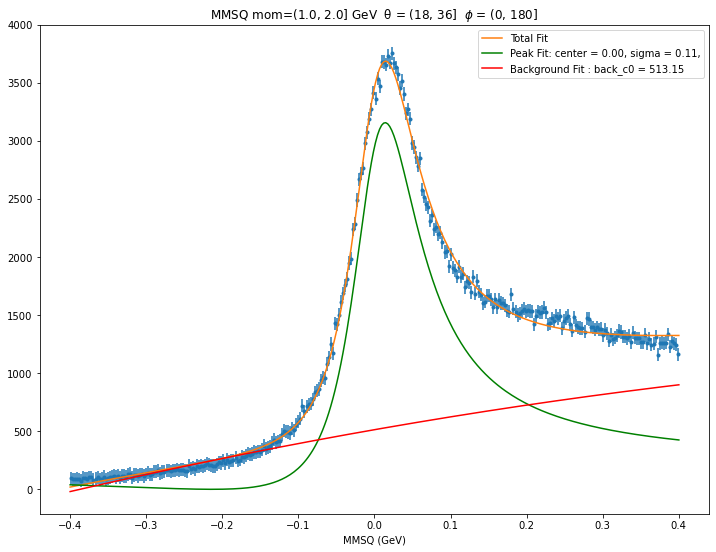

total =  139396.94521883834
signal =  113152.62761143348
background =  26244.31760740486
ratio =  4.311509611494237


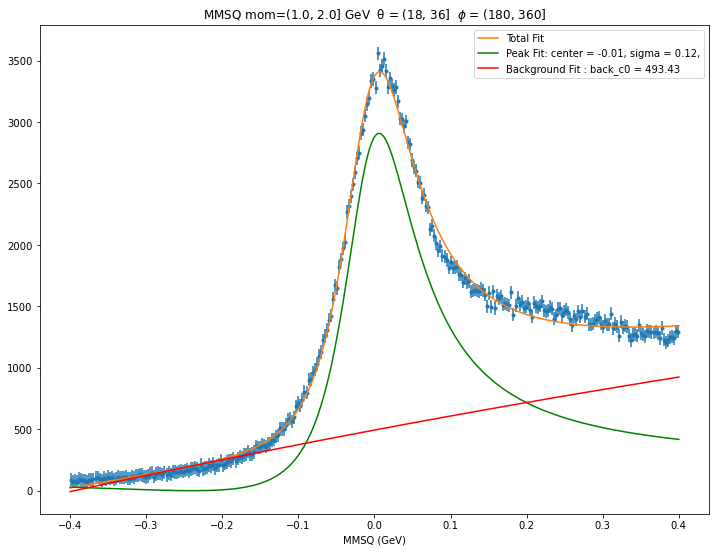

total =  47539.13177643976
signal =  37258.26755554942
background =  10280.86422089034
ratio =  3.6240404264693997


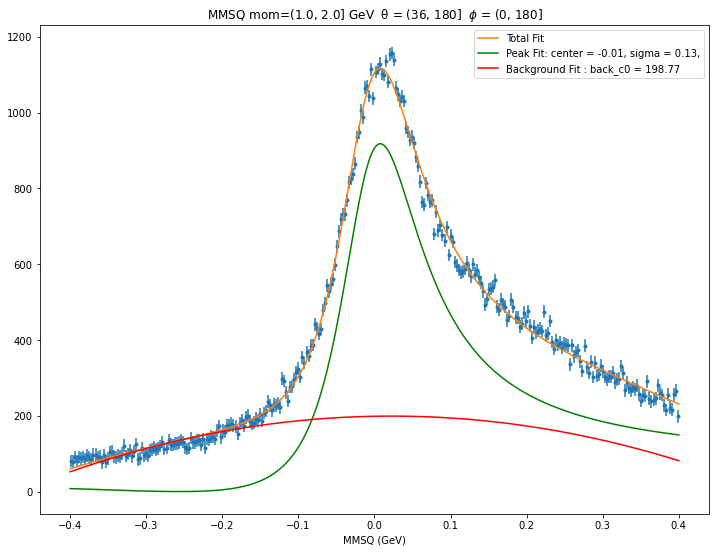

total =  49796.284205800446
signal =  40537.67393150873
background =  9258.61027429172
ratio =  4.3783756666018485


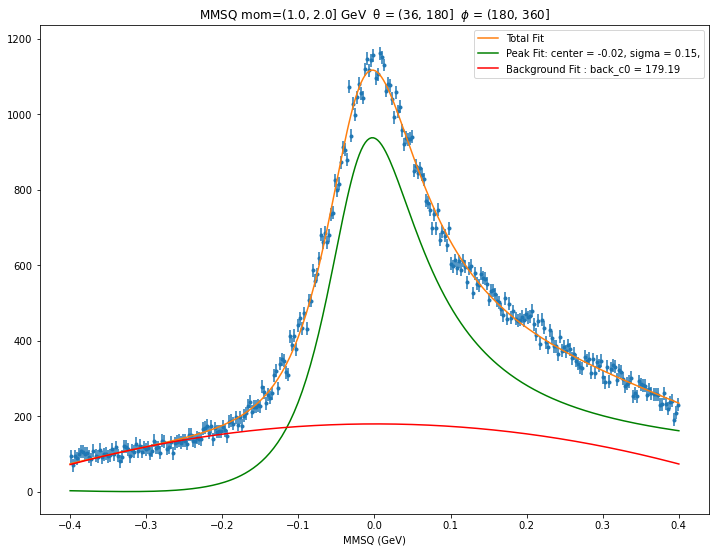

total =  20658.944777715395
signal =  -5141.401970350936
background =  25800.34674806633
ratio =  -0.19927646789228792


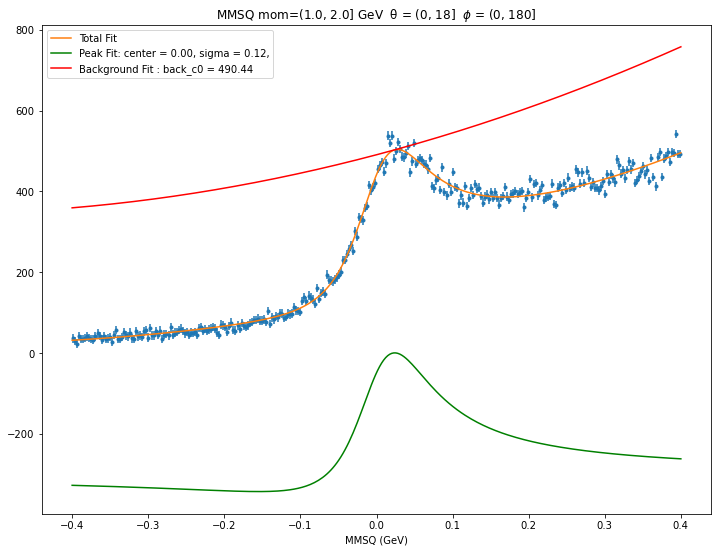

total =  19031.89779957612
signal =  11530.964125187998
background =  7500.933674388121
ratio =  1.5372705086781908


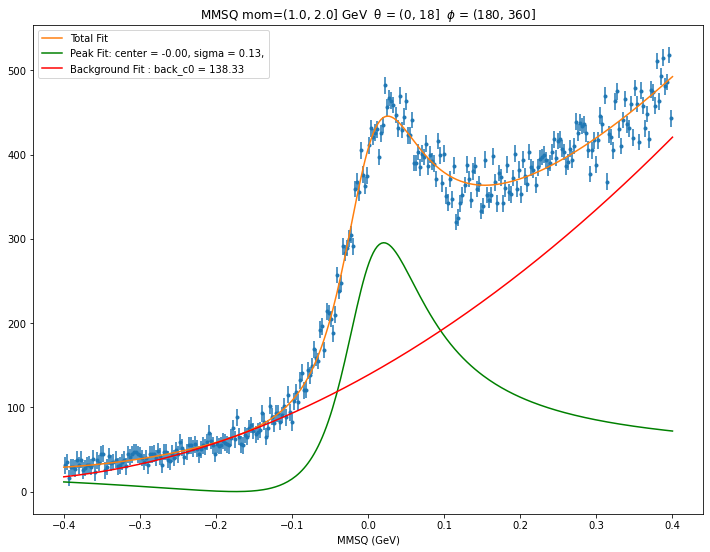

total =  62007.26606559607
signal =  53121.41387922116
background =  8885.852186374925
ratio =  5.978201388570767


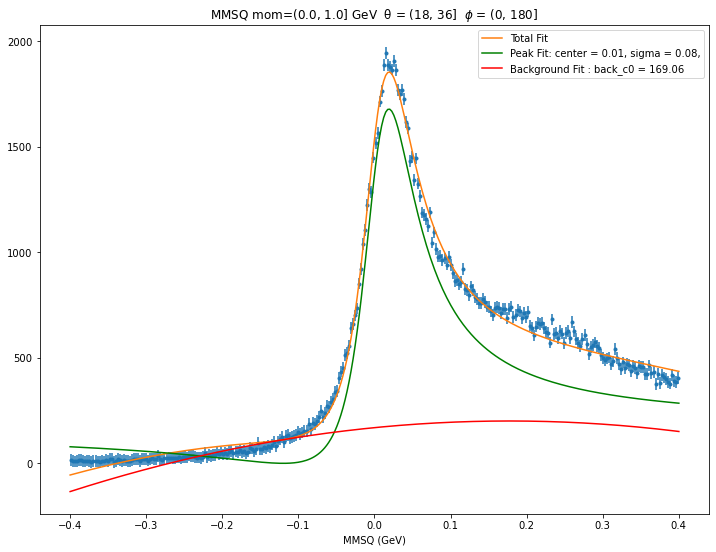

total =  60006.41355405992
signal =  52264.14334780983
background =  7742.270206250097
ratio =  6.750493325022239


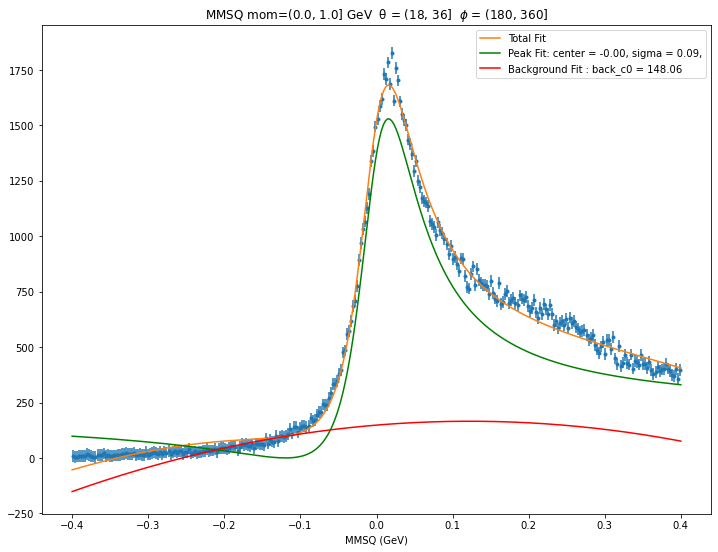

total =  250932.2855998801
signal =  234413.8338487837
background =  16518.451751096414
ratio =  14.191029364070058


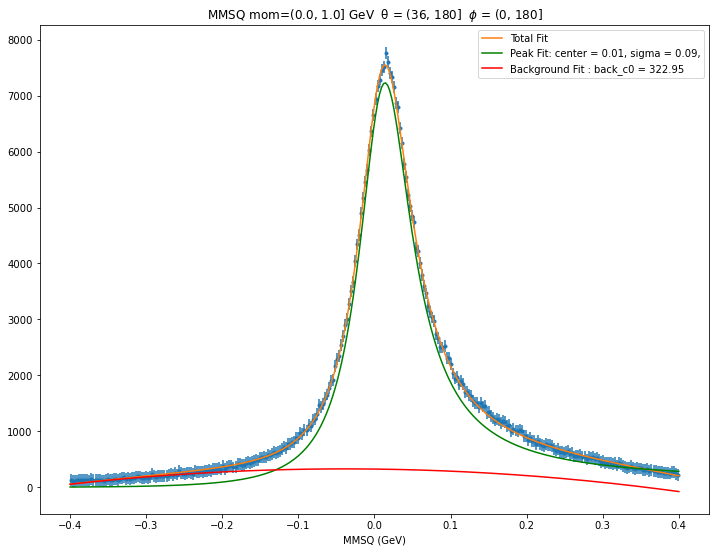

total =  257322.44289805854
signal =  244843.9264520536
background =  12478.51644600492
ratio =  19.621236828232252


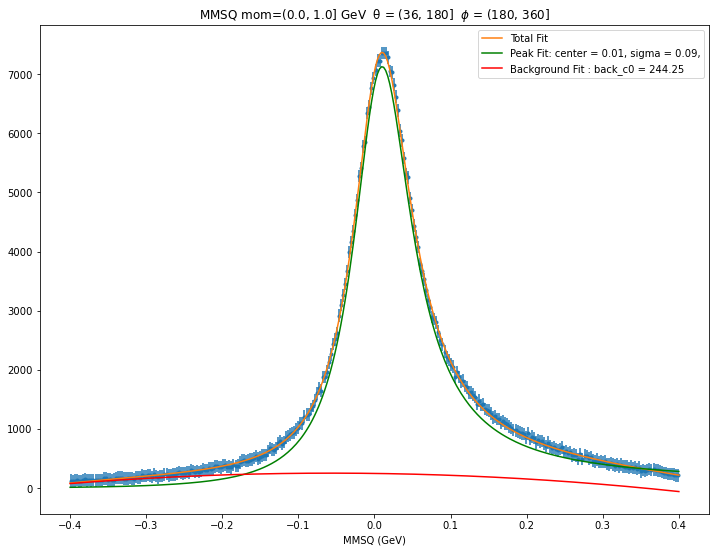

total =  4209.140229116816
signal =  1920.8970470321708
background =  2288.2431820846446
ratio =  0.8394636820384569


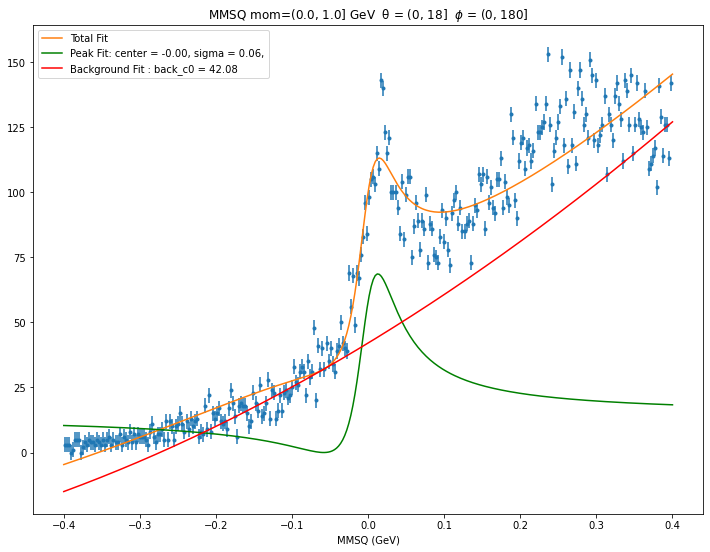

total =  4247.227412883817
signal =  2144.941424846895
background =  2102.2859880369224
ratio =  1.0202900257399345


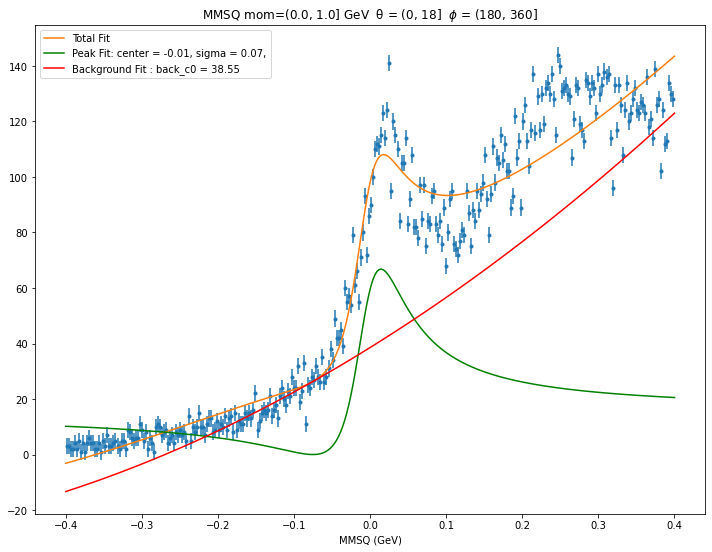

total =  50856.90863438114
signal =  -7344.422407758562
background =  58201.33104213971
ratio =  -0.12618993889402555


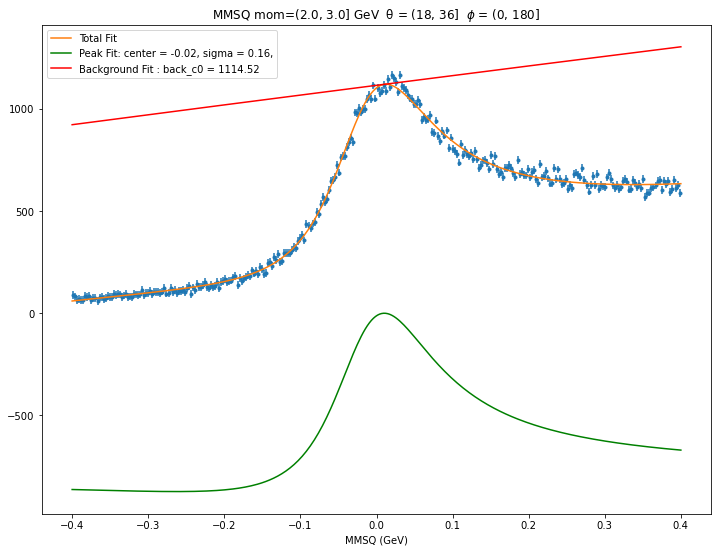

total =  51142.696962237635
signal =  37511.74243123967
background =  13630.954530997966
ratio =  2.751952722454963


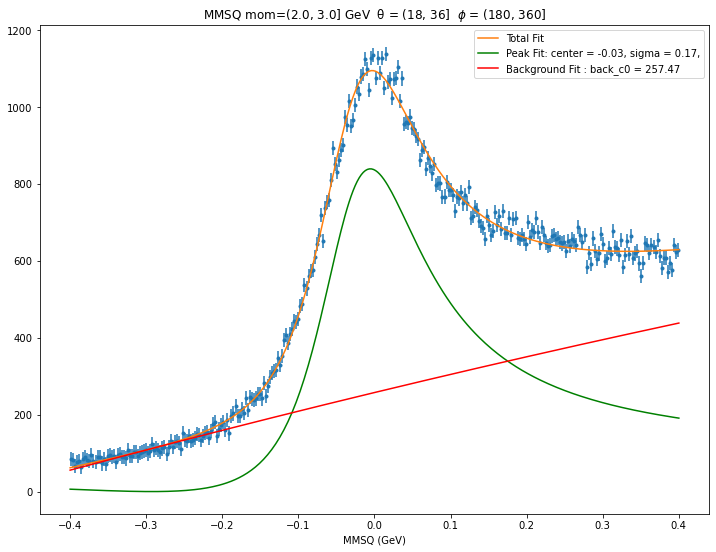

total =  777.4761328286006
signal =  401.8691584597534
background =  375.60697436884726
ratio =  1.069919319616032


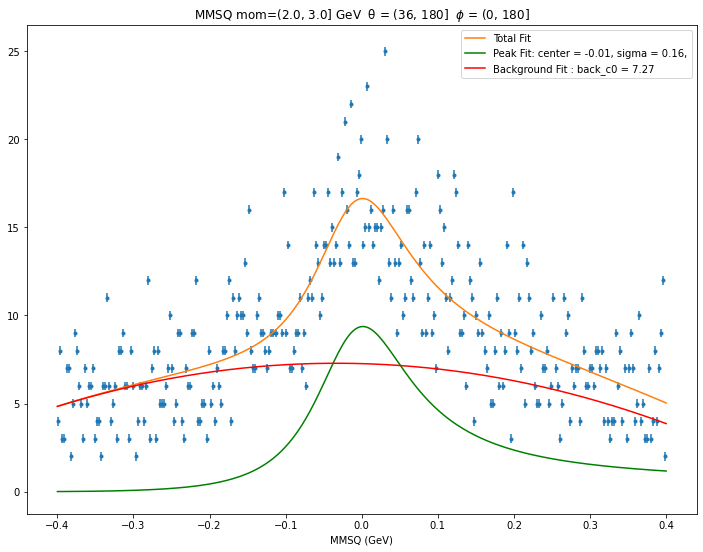

total =  834.4822057149386
signal =  633.571626711976
background =  200.91057900296227
ratio =  3.153500576505902


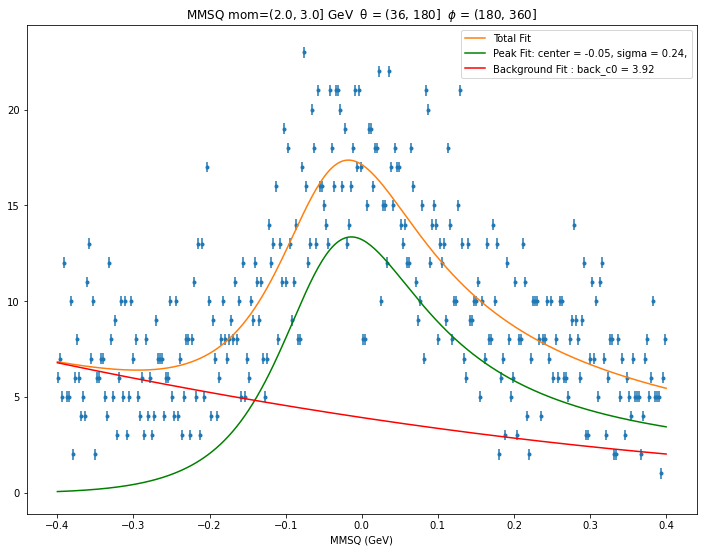

total =  26290.488421925886
signal =  17179.958675261998
background =  9110.529746663888
ratio =  1.8857255453836799


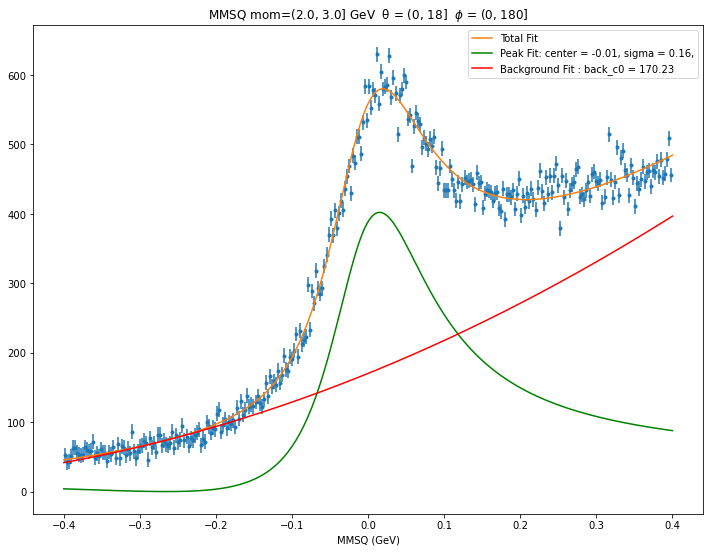

total =  25035.582159514375
signal =  16599.673066273856
background =  8435.909093240522
ratio =  1.967739680786123


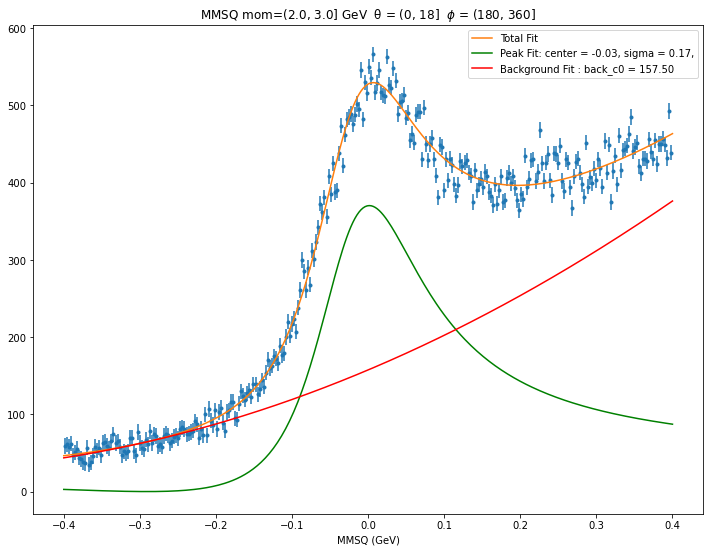

total =  12856.447469317958
signal =  8761.040673594682
background =  4095.406795723277
ratio =  2.1392357610832704


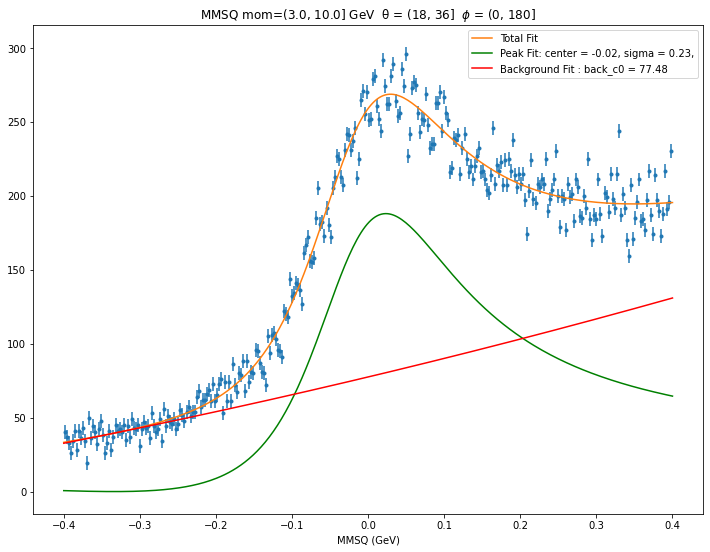

total =  13024.098796937289
signal =  8732.884262734944
background =  4291.214534202346
ratio =  2.0350612147519254


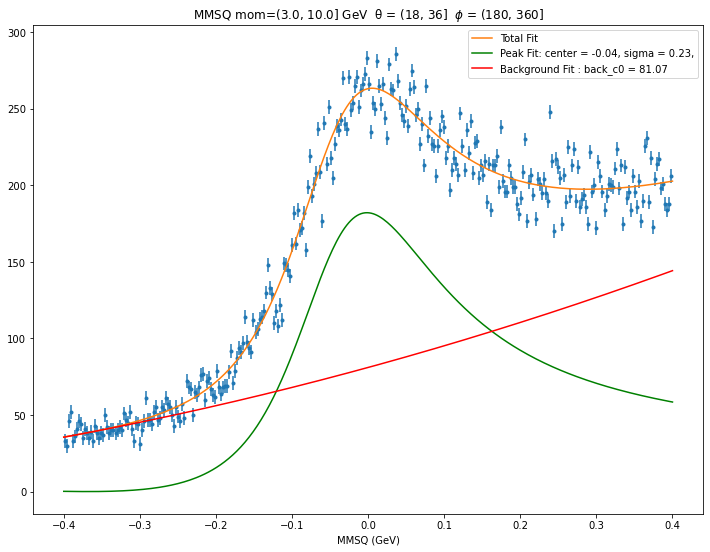

total =  30.101486276474482
signal =  9.868110679169376
background =  20.233375597305113
ratio =  0.4877145008114075


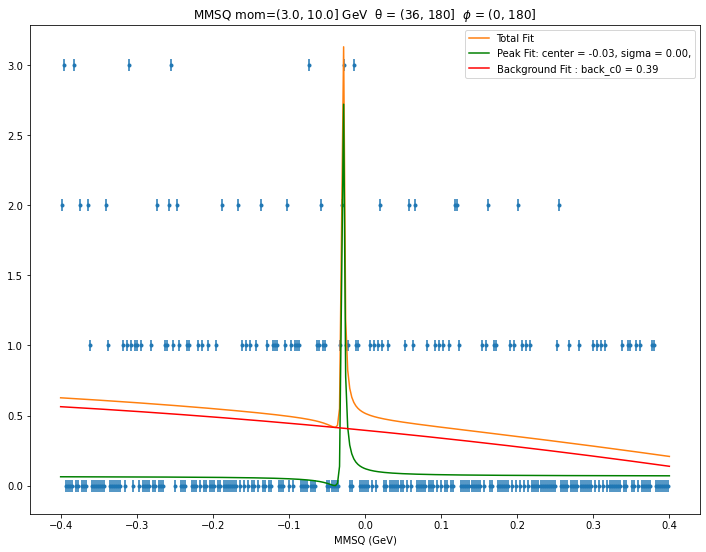

total =  20.411018919220005
signal =  -256.9017313243508
background =  277.3127502435708
ratio =  -0.9263971133628278


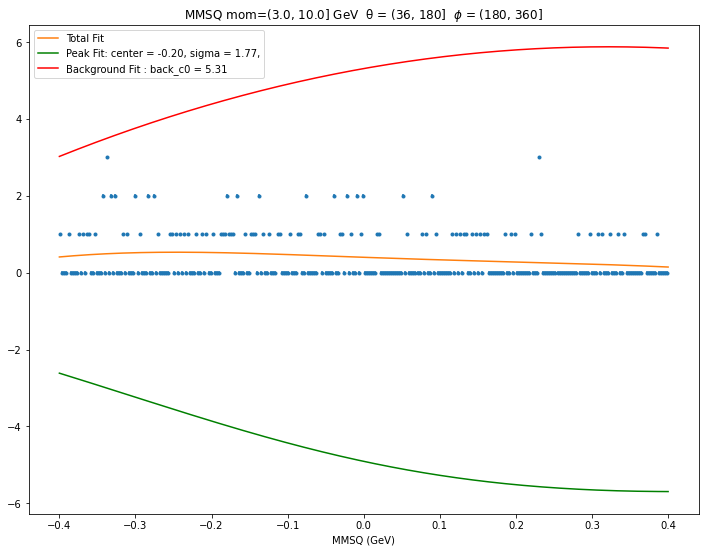

total =  40192.22741501611
signal =  22314.69320243196
background =  17877.53421258415
ratio =  1.2481974827783833


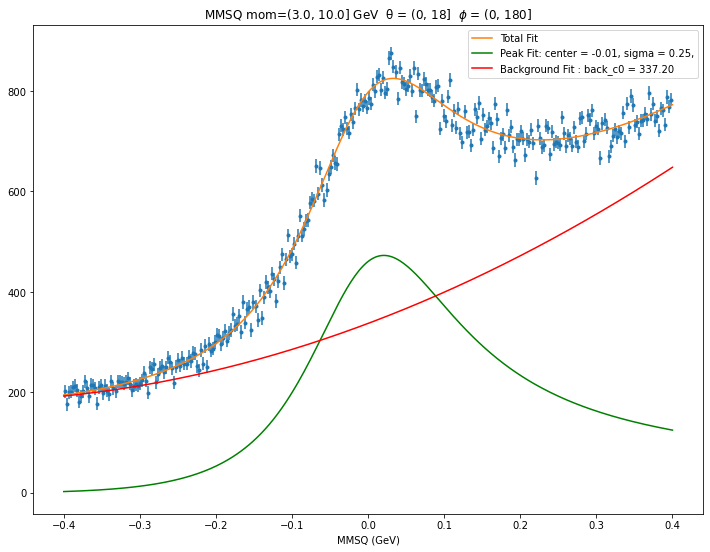

total =  39552.11712388838
signal =  20390.339623415646
background =  19161.777500472745
ratio =  1.0641152483329164


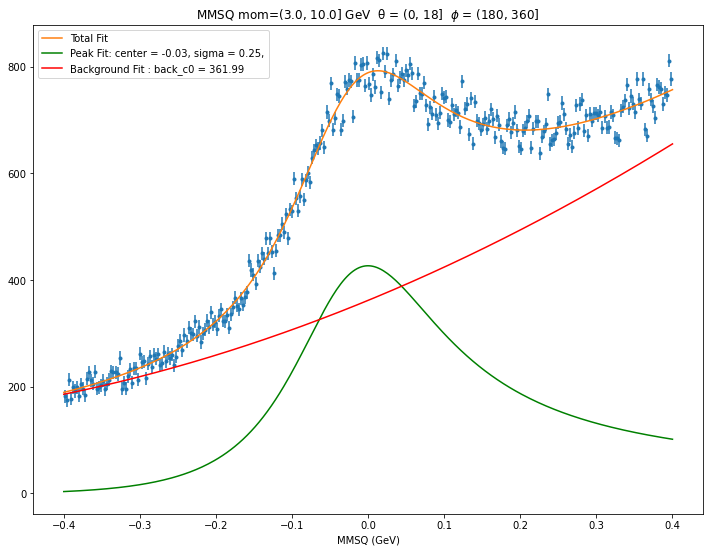

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


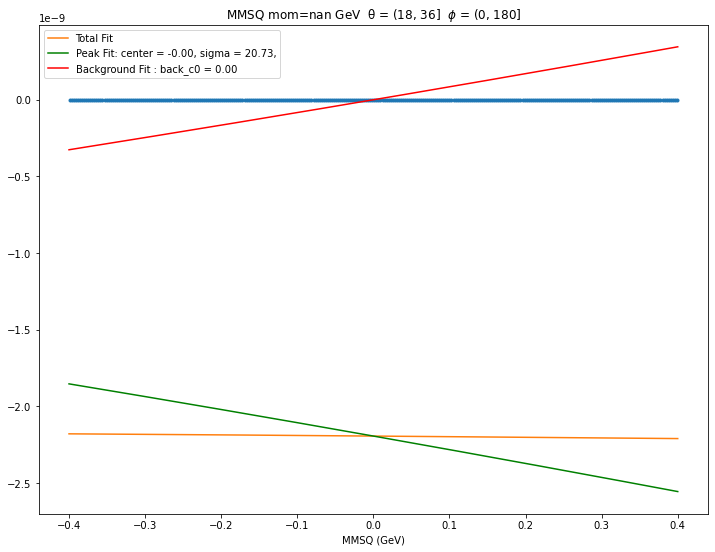

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


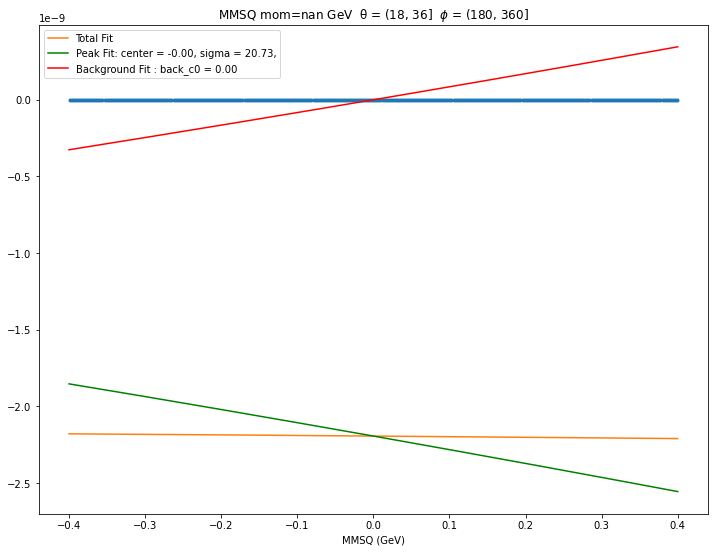

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


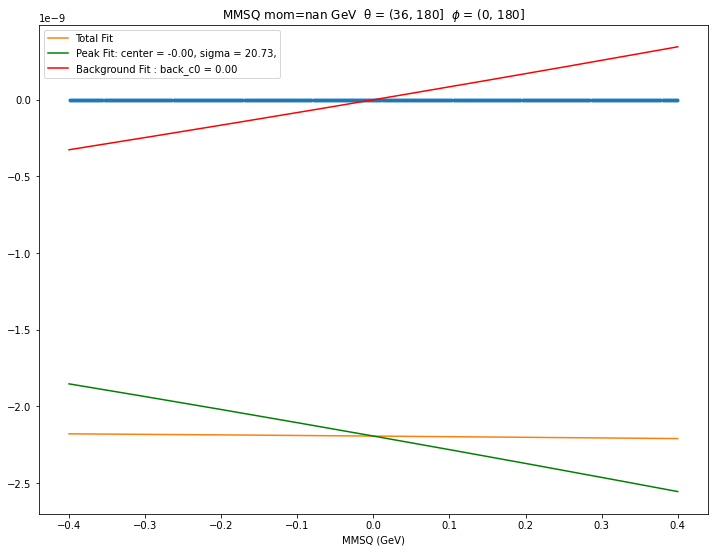

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


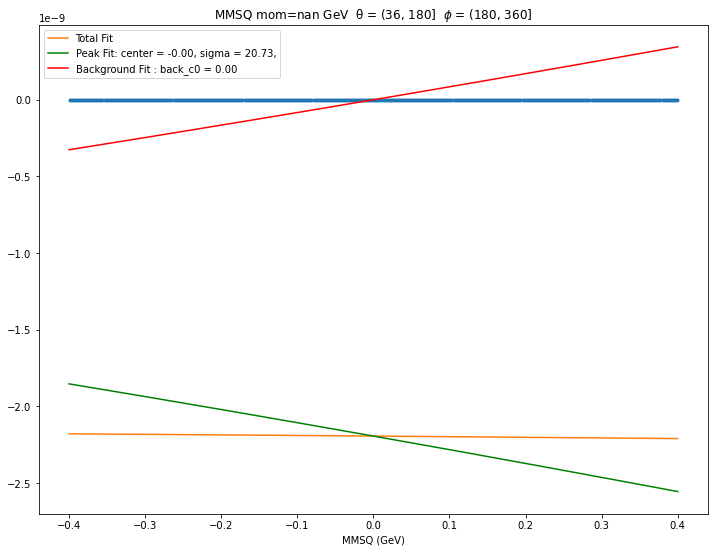

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


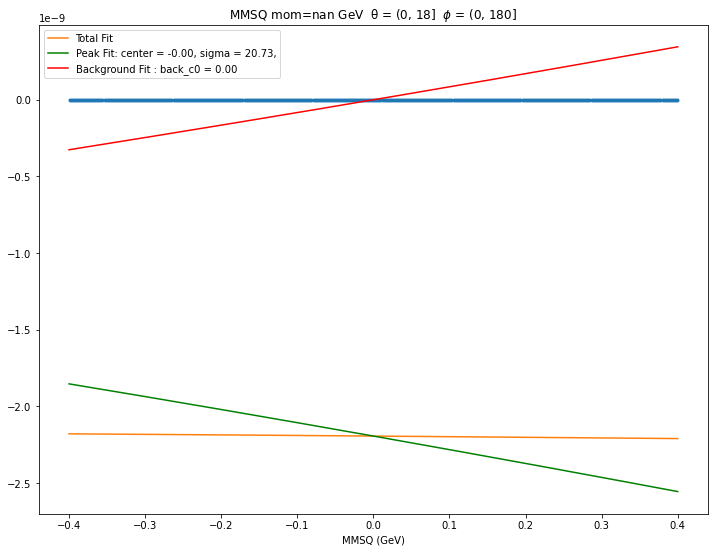

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


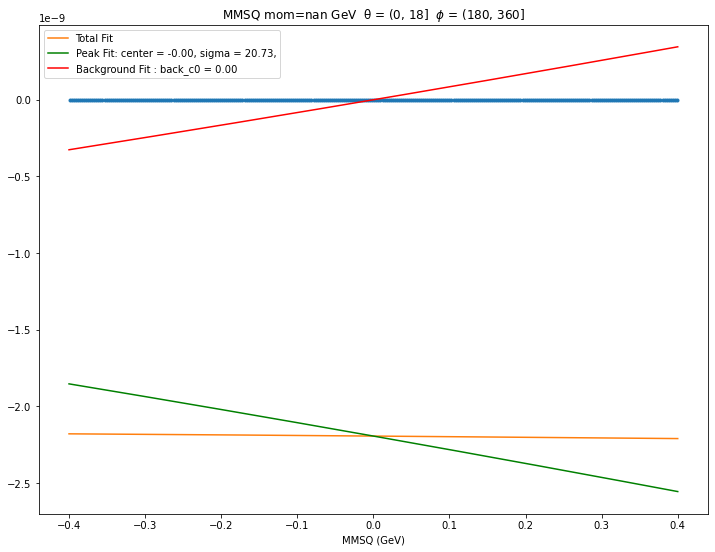

In [9]:
sector_cuts = mm_cut(rec)

In [18]:
# Create function to
import sys
from scipy import integrate
def mm_cut(df):
 
    NSIGMA = 4
    cut_data = {}
    # Makes a list from 0 to 10 spaced by 1
    mom_bin_ranges = np.arange(1, 4.2, 0.05)
#    np.arange(0,10., 5.0)
    # Cuts the mom data into the ranges from above
    rec['mom_bin'] = pd.cut(rec.w, mom_bin_ranges)
    unique_mom = rec.mom_bin.unique()
#     print(unique_mom)
    # Makes a list from 0 to 180 spaced by 18
#     theta_bin_ranges = np.arange(0,180.1, 90.0)
    theta_bin_ranges = [0,180]
    # Cuts the theta data into the ranges from above
    rec['theta_bin'] = pd.cut(rec.pim_theta_exclusive, theta_bin_ranges)
    unique_theta = rec.theta_bin.unique()
    
    # Makes a list from 0 to 360 spaced by 120
    phi_bin_ranges = [0, 360]
#     np.arange(0,361, 180.0)
    # Cuts the phi data into the ranges from above
    rec['phi_bin'] = pd.cut(rec.pim_phi_exclusive, phi_bin_ranges)
    unique_phi = rec.phi_bin.unique()
    
    
    for mom in unique_mom:
#         data = rec[rec.mom_bin == mom]
        for theta in unique_theta:
#             data = rec[rec.theta_bin == theta]
            for phi in unique_phi:
#                 data = rec[rec.phi_bin == phi] 
                data = rec[(rec.mom_bin == mom) & (rec.theta_bin == theta) & (rec.phi_bin == phi)] 
                
#       The bin edges are saved as left and right
#         print(phi.left, phi.right)
#                 s = f'{mom.left}_{theta.left}_{phi.left}'
                s = f'MMSQ w={mom} GeV' 
#     \u03B8 = {theta}  $\phi$ = {phi}'
#                 s = "MMSQ-Mom = ("+str(mom.left)+"-"+str(mom.right)+') GeV_'+'\u03B8 = (' + str(theta.left)+"-"+str(theta.right)+")\u00B0_"+"\u03C6 = ("+str(phi.left)+'-'+str(phi.right)+')\u00B0'
                # Make a figure to plot on
                plt.figure(figsize=(12,9))
                # Histogram the data and 
                y,x = np.histogram(data.mm2_exclusive.to_numpy(), 
                                 bins=300, range=(-0.4,0.4), density=False)
        
                # calculate bin centers
                x=(x[1:]+x[:-1])/2

                # Plot points on
                plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

                # Make a model with a peak
                peak = BreitWignerModel(prefix="peak_")
                pars = peak.make_params()
                # Set some parameters
                pars['peak_center'].set(value=0, min=-0.20, max=0.2)
                #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
                #pars['peak_amplitude'].set(value=0.5)
        
                # Set the background
                background =  PolynomialModel(2, prefix="back_")
                pars.update(background.guess(y, x=x))
                pars['back_c0'].set(value=0.1,min=0.)
        
                # Make full model to fit
                model = peak + background
        
                # Fit our full model
                out = model.fit(y, pars, x=x)
        
                # Make a more fine set of x's to plot with
                xs= np.linspace(-0.4, 0.4, 300)
        
                # Plot our output model withe the new parameter and finer x's
                plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

                # Get the components of the fit for our finer x's
                comps = out.eval_components(x=xs)
                # Plot just the peak component
                plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

                plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
                # Plot center +- sigma where we will cut later
                #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
                #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
                # Put on labels and show the plot
                plt.title(s)
                xs=np.linspace(-0.06, 0.08, num = 53) # , retstep = True
                comps1 = out.eval_components(x=xs)
                total = integrate.simps(out.eval(x=xs))
                peak_out = integrate.simps(comps1['peak_'])
                background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     help(model.fit)
                print('total = ', total)
                print('signal = ', peak_out)
                print('background = ', background_out)
                print('ratio = ', peak_out/background_out)
                plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
                plt.legend()
                plt.show()
#                 print(mom)
#                 print(theta)
#                 print(phi)
            # Save cut data to our
                cut_data[mom,theta,phi]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                                out.params['peak_center']+NSIGMA*out.params['peak_sigma'])

            
        

    return cut_data

total =  33465.497808956694
signal =  33253.24853293347
background =  212.24927602322788
ratio =  156.67072772156047


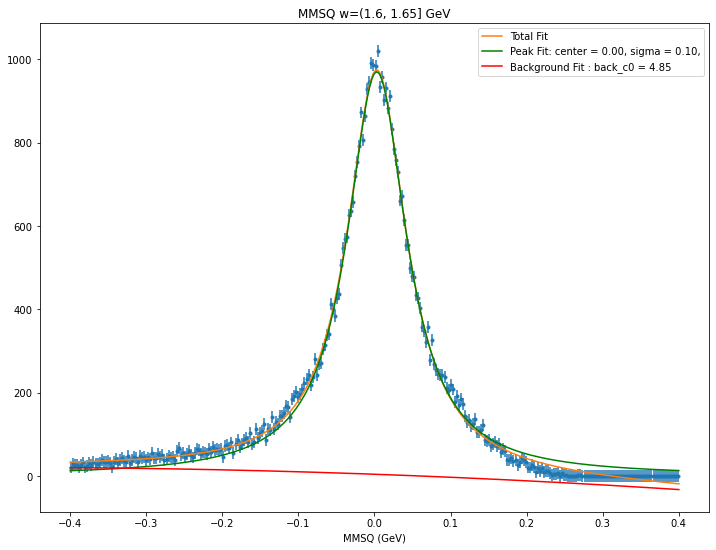

total =  31870.54373722971
signal =  -9674.281341188467
background =  41544.82507841819
ratio =  -0.23286369175770313


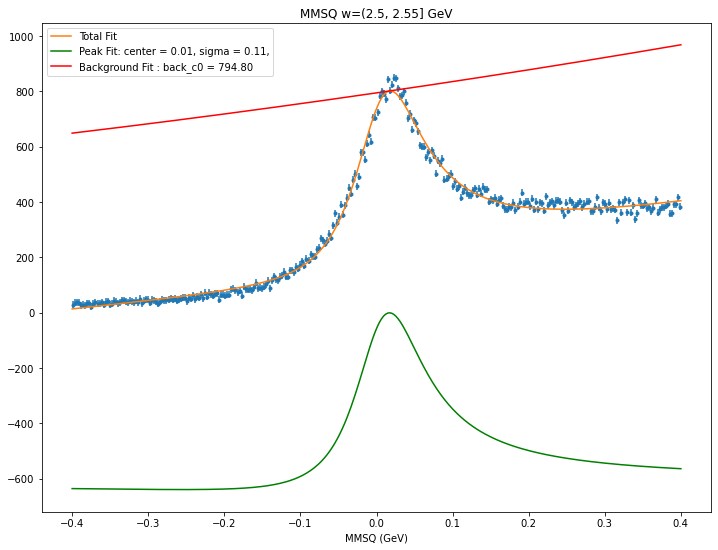

total =  39672.64282404332
signal =  29924.005786830803
background =  9748.637037212515
ratio =  3.0695578953862817


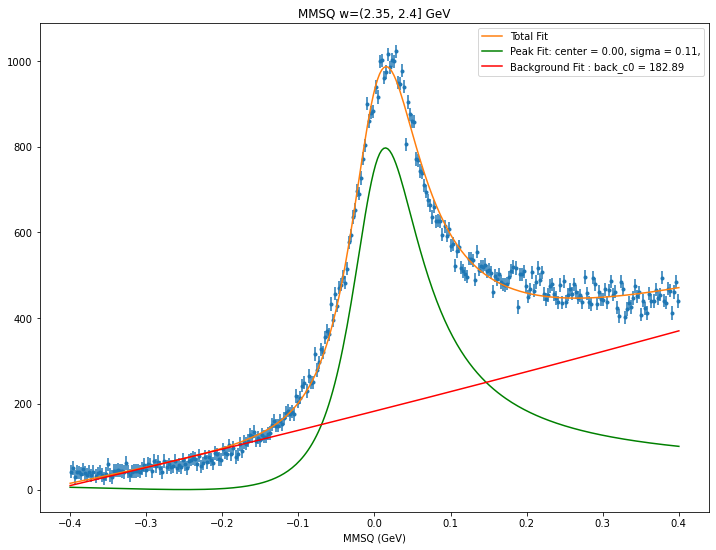

total =  60017.97496213305
signal =  49671.66728098363
background =  10346.307681149414
ratio =  4.800907609918034


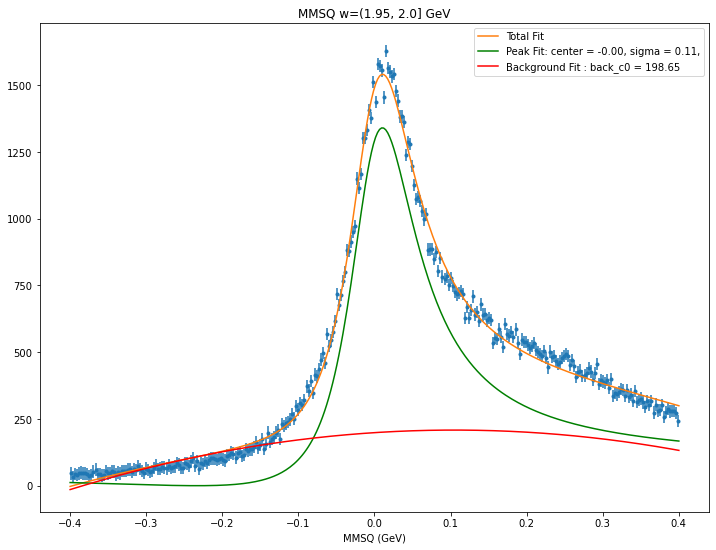

total =  311.9387099406751
signal =  -545.5252805926104
background =  857.4639905332855
ratio =  -0.6362078018615454


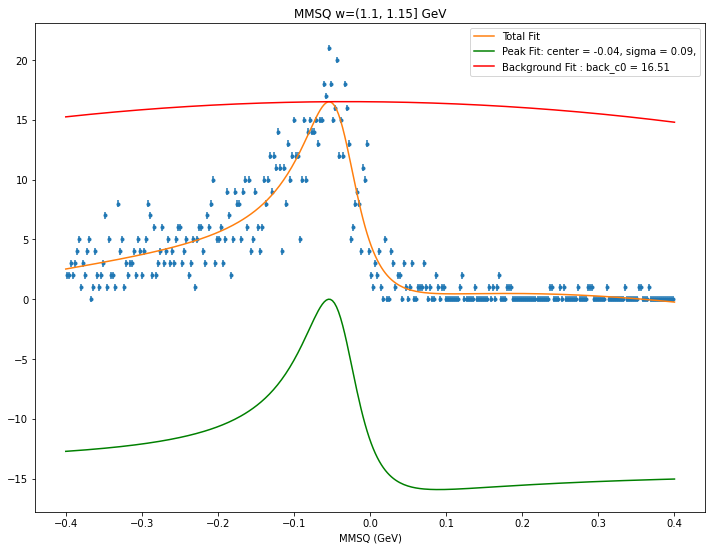

total =  21790.749091898346
signal =  15788.155374648333
background =  6002.5937172500135
ratio =  2.6302222203173544


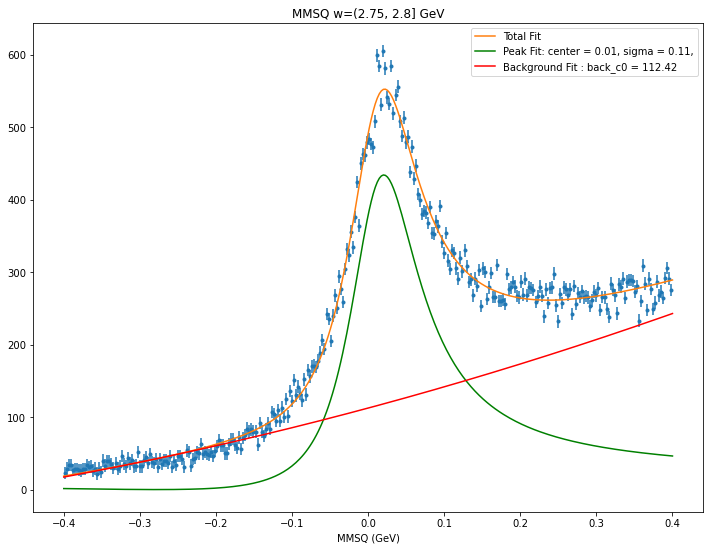

total =  48856.603748923546
signal =  38420.85051239901
background =  10435.753236524537
ratio =  3.6816557120120703


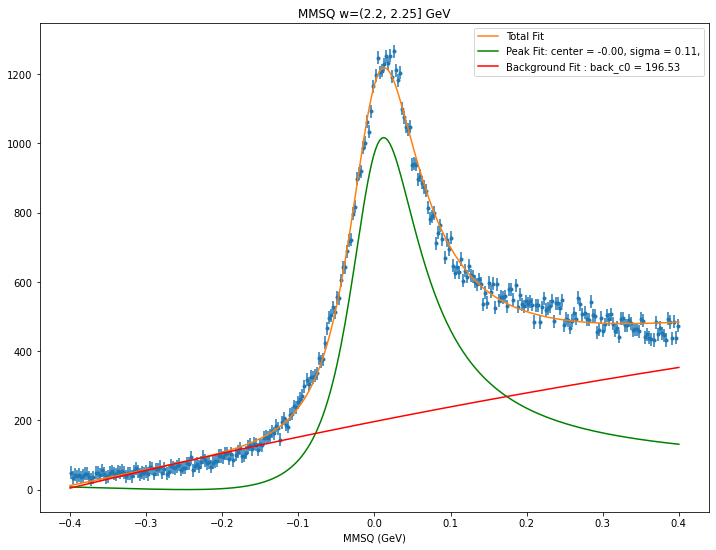

total =  51658.87109121228
signal =  40541.31449295459
background =  11117.556598257686
ratio =  3.64660293245623


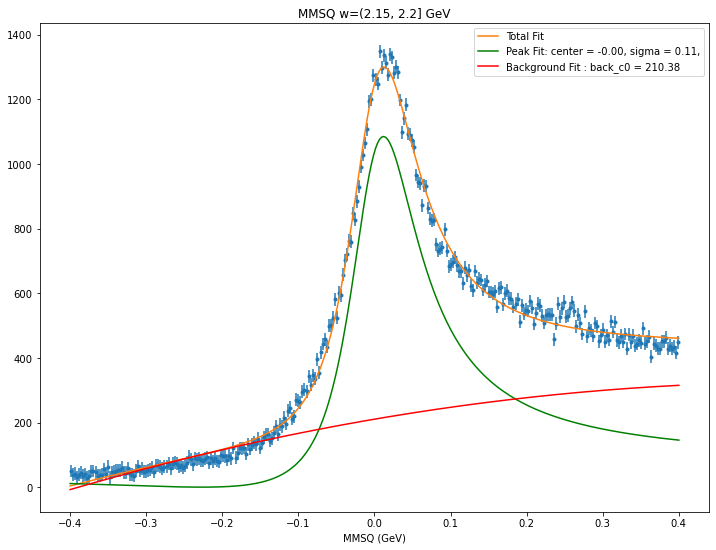

total =  45752.996415218295
signal =  35170.04170542497
background =  10582.954709793328
ratio =  3.323272438544887


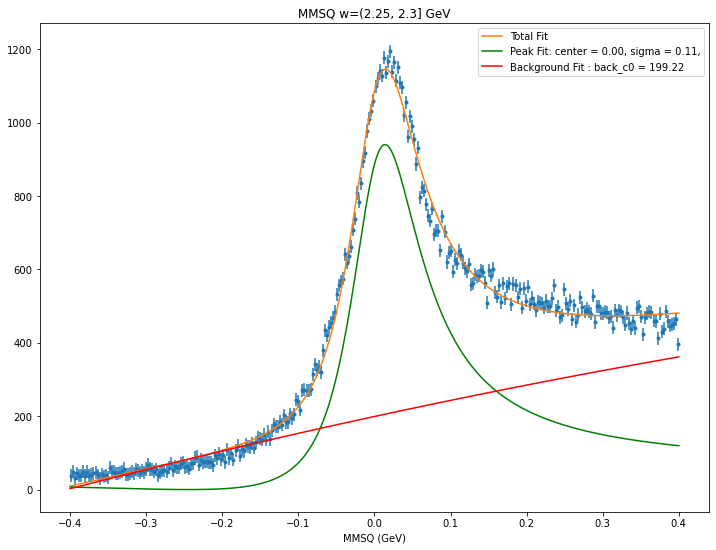

total =  54191.692875743196
signal =  49160.32518462639
background =  5031.367691116801
ratio =  9.77076775196177


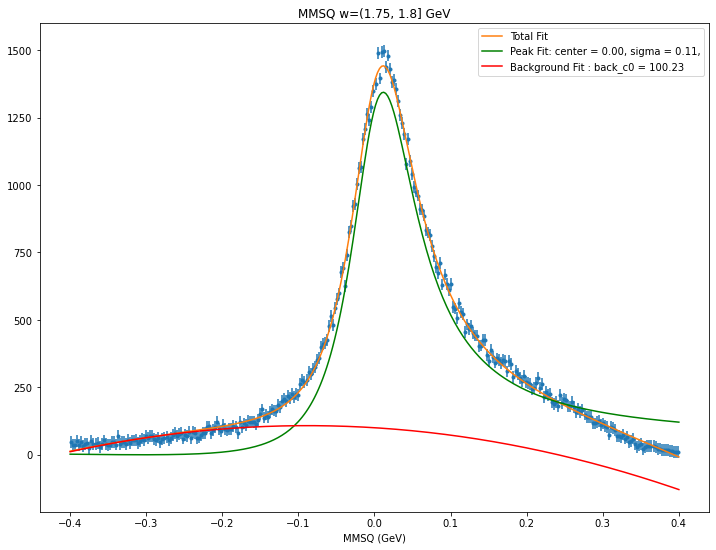

total =  12281.195064560676
signal =  8390.607022052931
background =  3890.5880425077435
ratio =  2.156642371379064


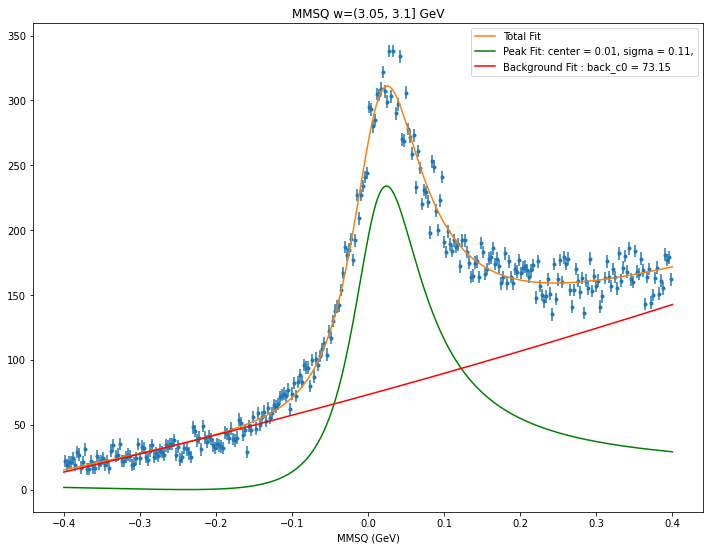

total =  58926.75337465748
signal =  48601.75299231205
background =  10325.00038234543
ratio =  4.707191398793117


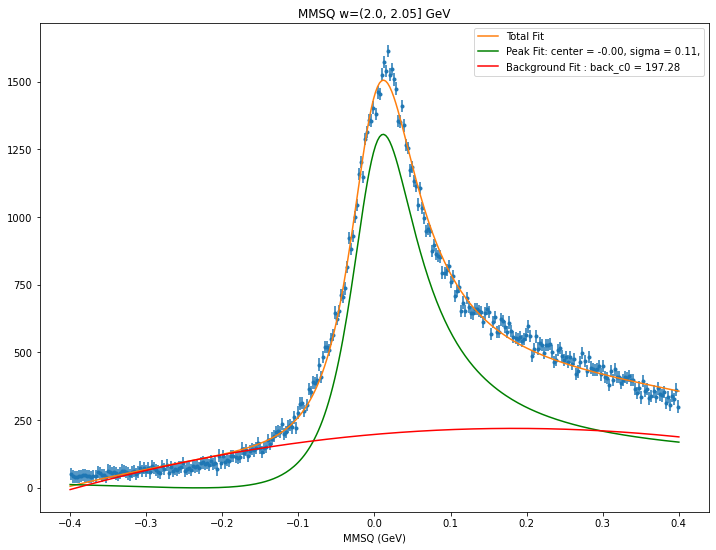

total =  6410.452082979926
signal =  4059.143606110517
background =  2351.308476869409
ratio =  1.726333931103316


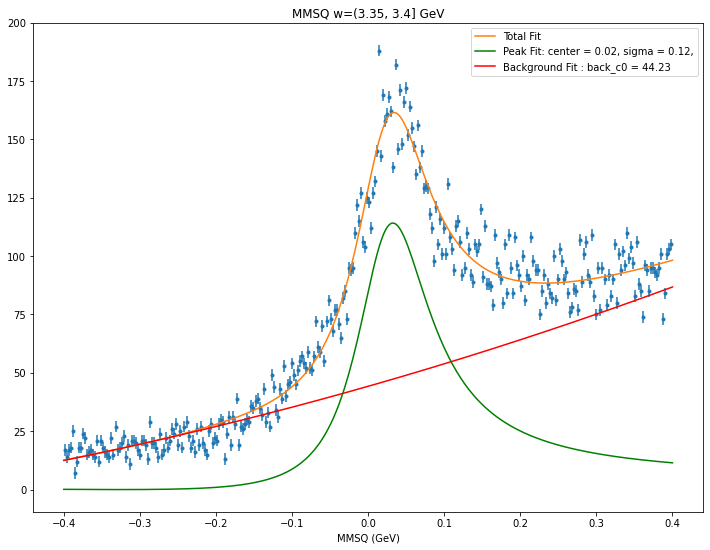

total =  13574.630487918323
signal =  9302.144321127555
background =  4272.486166790768
ratio =  2.177220465552674


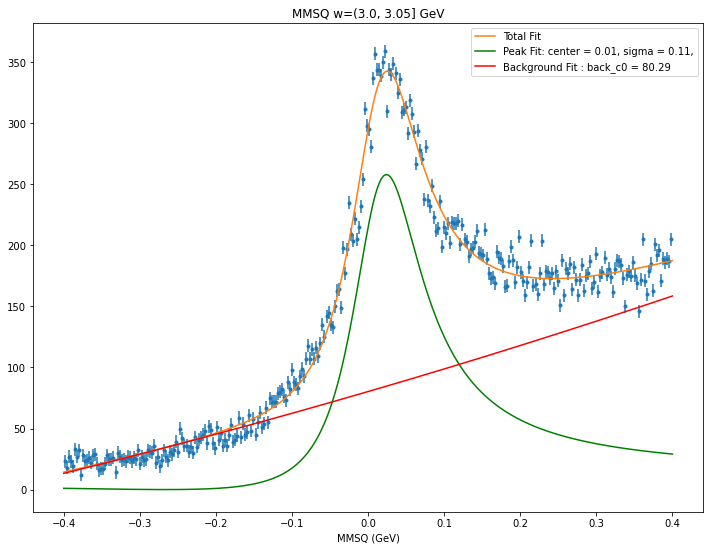

total =  60969.9020626163
signal =  51310.80441449684
background =  9659.097648119468
ratio =  5.312173691968685


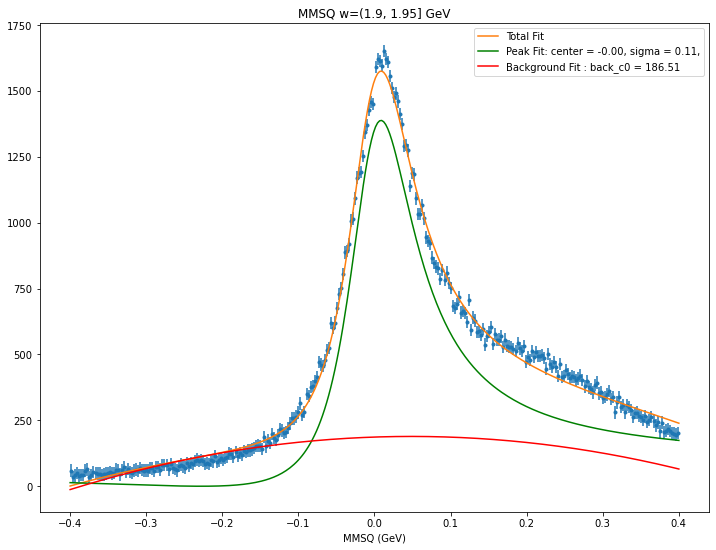

total =  34282.24985991755
signal =  25440.90791460021
background =  8841.341945317337
ratio =  2.8774939451442147


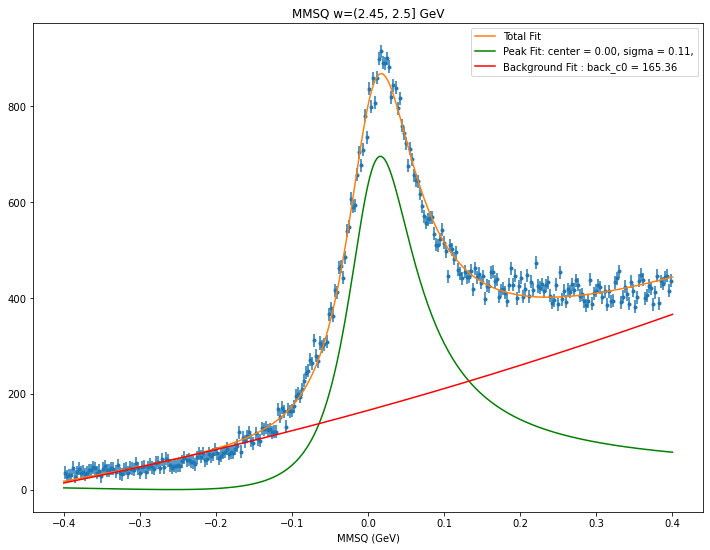

total =  56357.0032249669
signal =  45662.05777726605
background =  10694.94544770085
ratio =  4.269498895581769


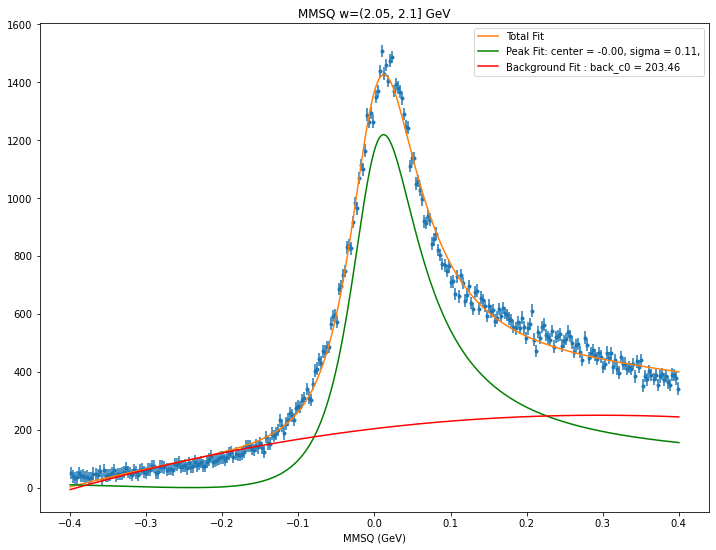

total =  45839.24914973781
signal =  44443.01028285531
background =  1396.238866882496
ratio =  31.8305207919667


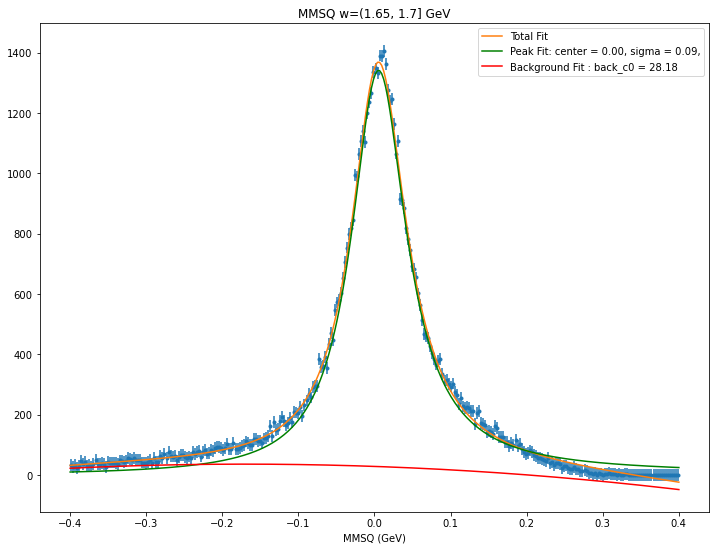

total =  1807.7443039163577
signal =  1853.6257819908565
background =  -45.88147807449914
ratio =  -40.400306611331665


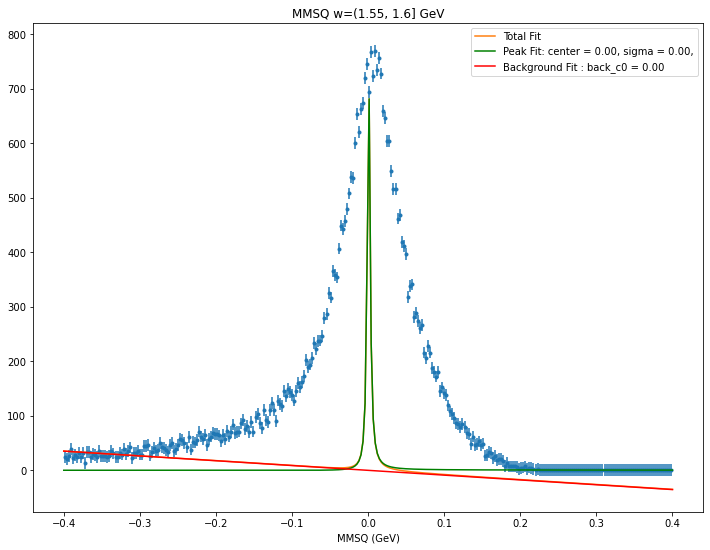

total =  23532.90069583513
signal =  16866.903368218784
background =  6665.997327616349
ratio =  2.530289548473328


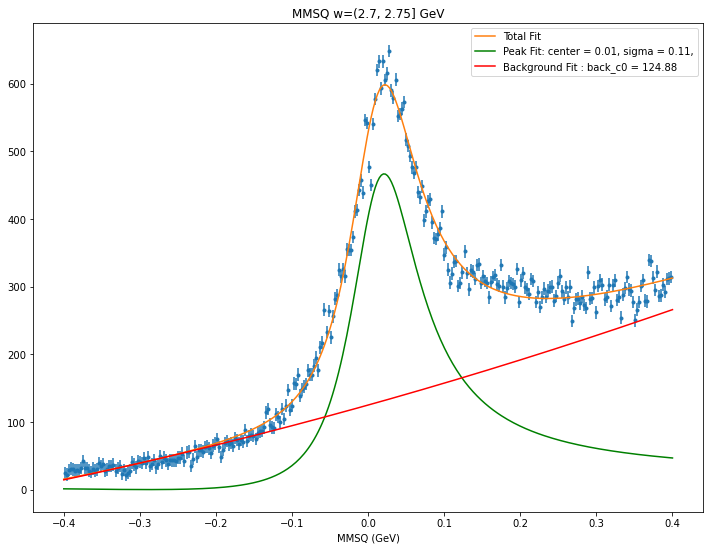

total =  37158.28415431684
signal =  27955.093787180984
background =  9203.190367135849
ratio =  3.037543794270222


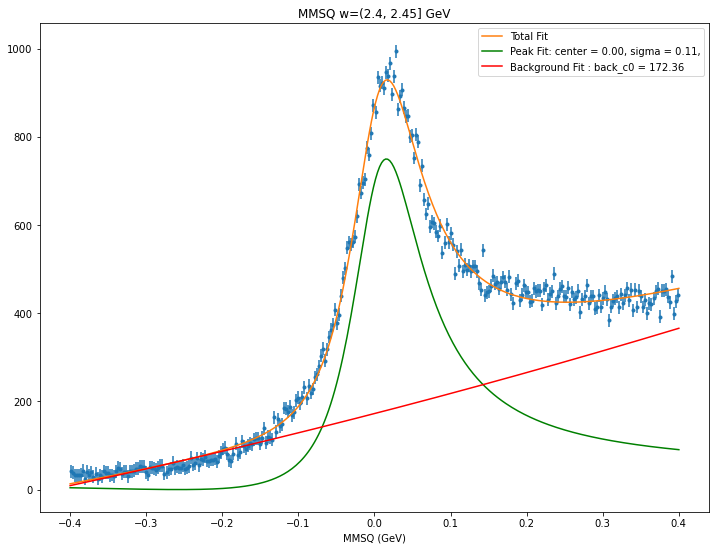

total =  16428.966934160027
signal =  11442.836076165911
background =  4986.130857994116
ratio =  2.294932965471604


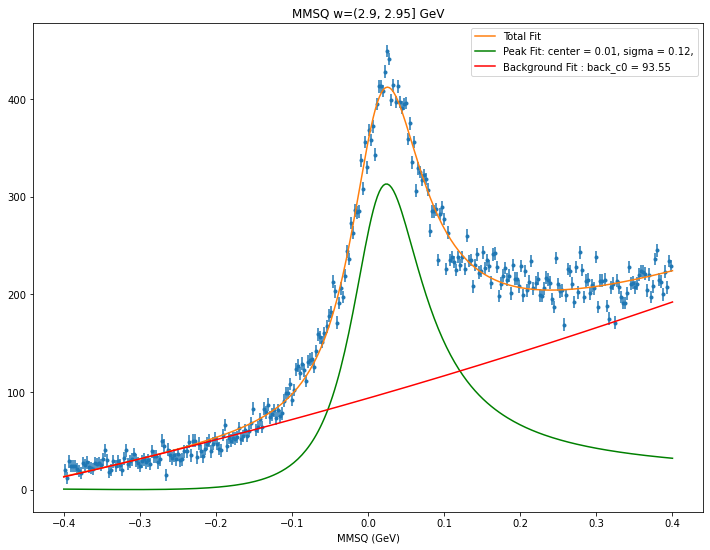

total =  54240.0146552915
signal =  44073.135634372535
background =  10166.879020918968
ratio =  4.334971975538353


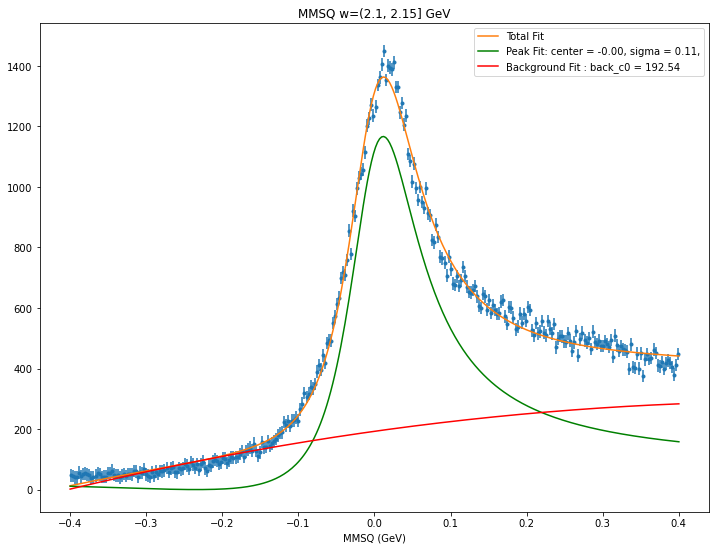

total =  42774.924147009144
signal =  32458.204051200515
background =  10316.72009580863
ratio =  3.1461747289613196


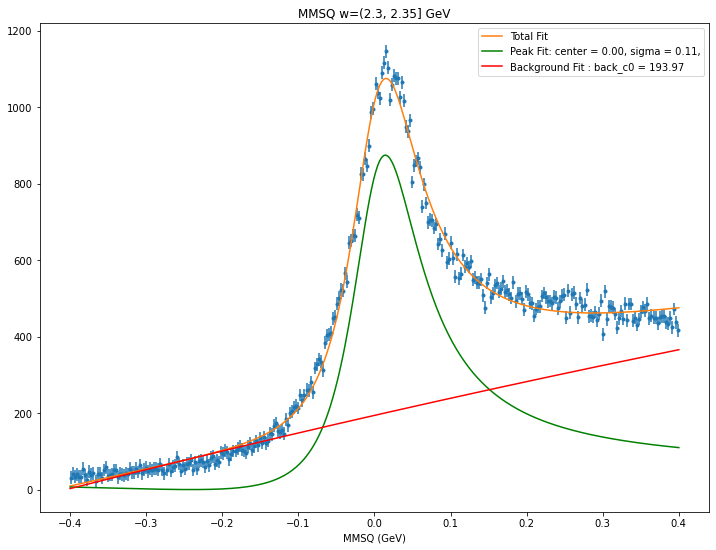

total =  36736.43160769437
signal =  -6213.111173431411
background =  42949.54278112578
ratio =  -0.1446607058215709


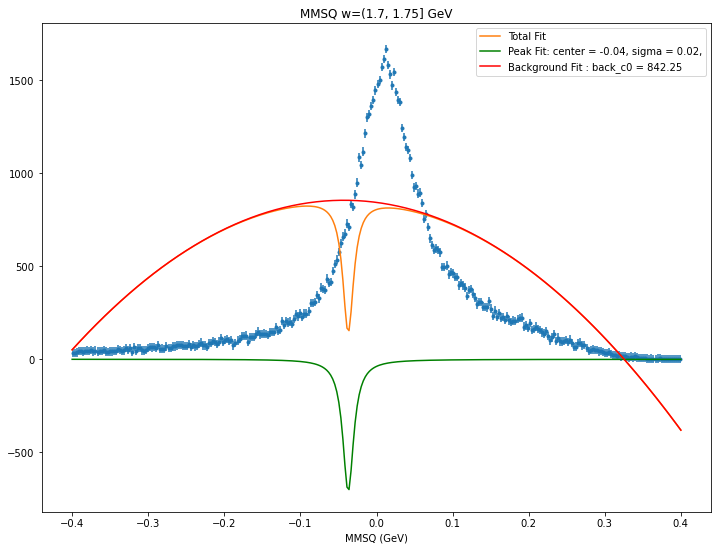

total =  7151.808833539783
signal =  4624.1471370030085
background =  2527.6616965367757
ratio =  1.8294169442606538


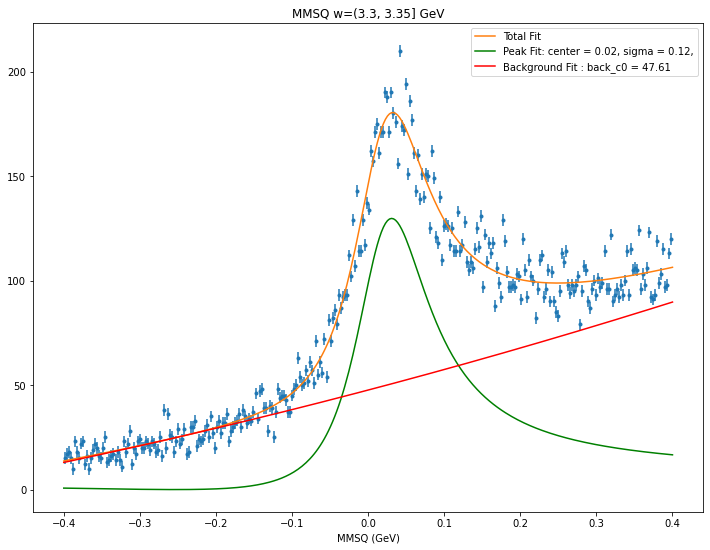

total =  5709.165109049688
signal =  3669.9889161202623
background =  2039.1761929294255
ratio =  1.79974095855251


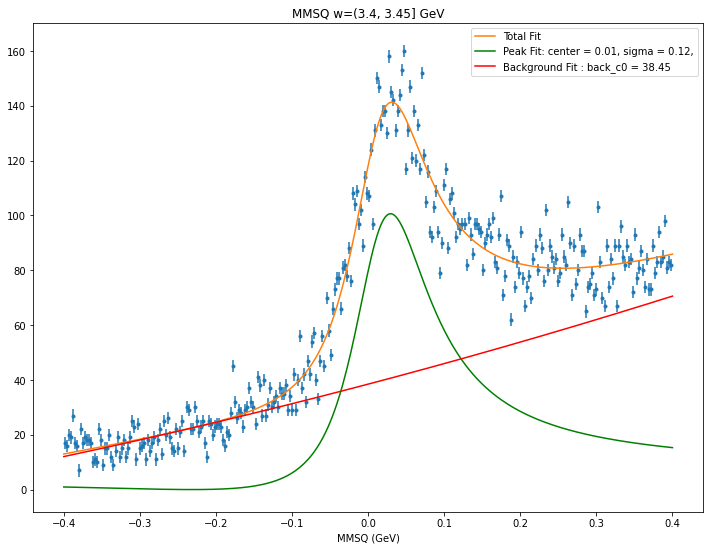

total =  59258.72117442037
signal =  50103.63021829244
background =  9155.090956127926
ratio =  5.4727615988081215


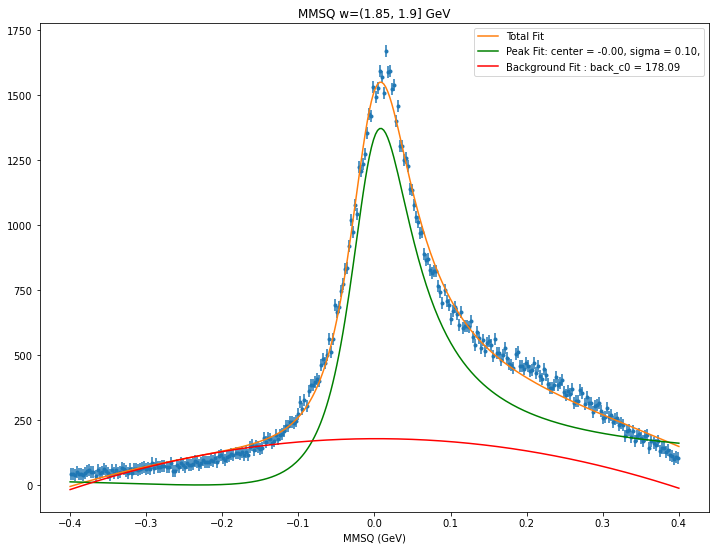

total =  4556.100636039157
signal =  2759.2721171684925
background =  1796.828518870664
ratio =  1.5356346408074266


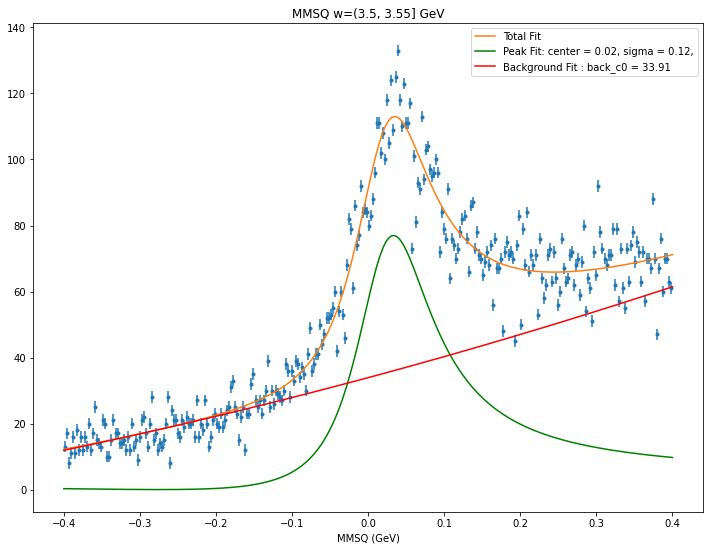

total =  8117.053536775669
signal =  5548.712862124057
background =  2568.3406746516134
ratio =  2.160427125921183


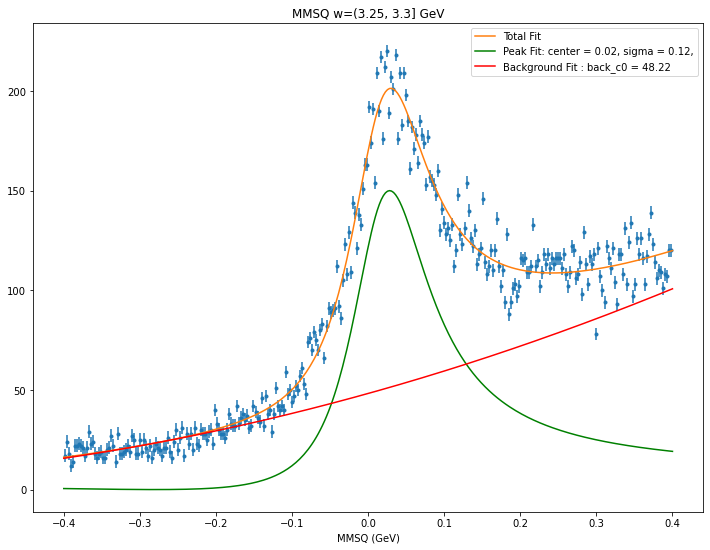

total =  29722.49901376115
signal =  21873.168302946626
background =  7849.330710814521
ratio =  2.7866284539152586


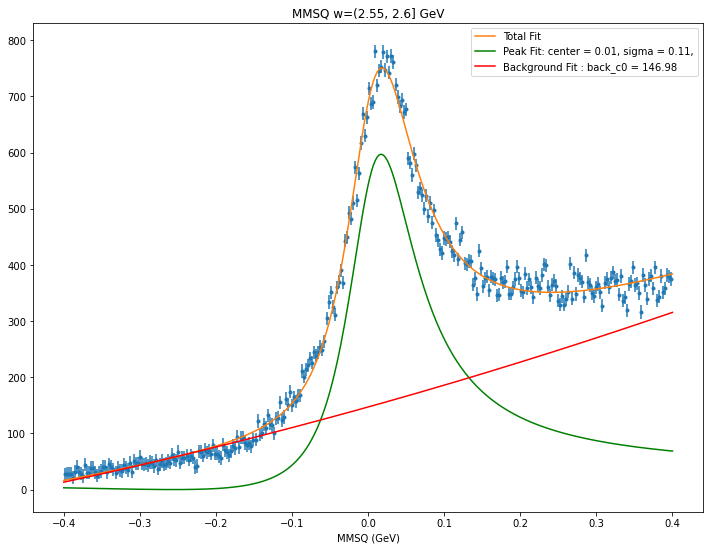

total =  55486.571426258415
signal =  48066.033989613396
background =  7420.537436645021
ratio =  6.477432989185894


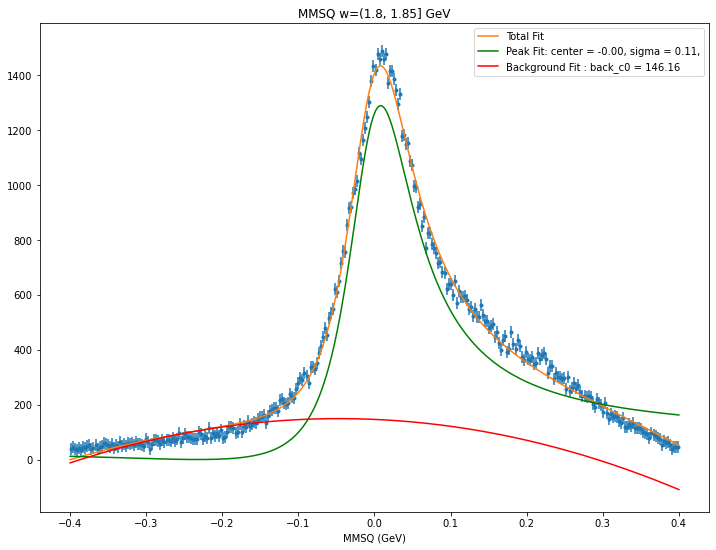

total =  2272.0690934502936
signal =  1306.3714080190782
background =  965.6976854312159
ratio =  1.3527747117212363


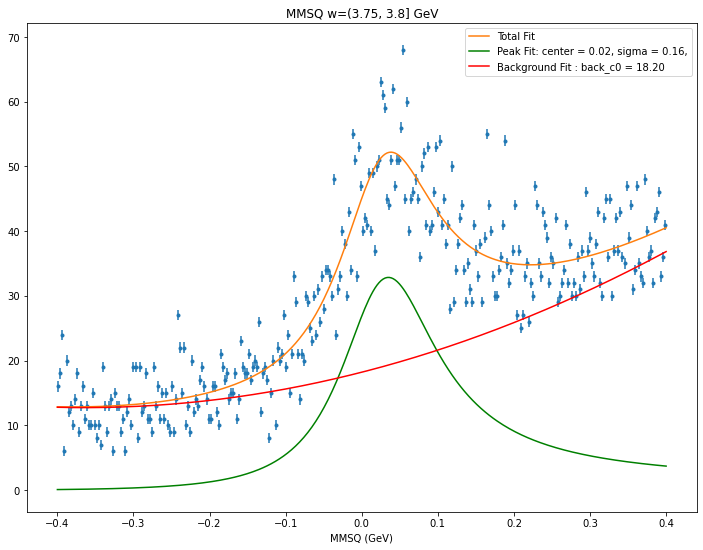

total =  14961.350671617609
signal =  10412.3520030604
background =  4548.9986685572085
ratio =  2.288932743601539


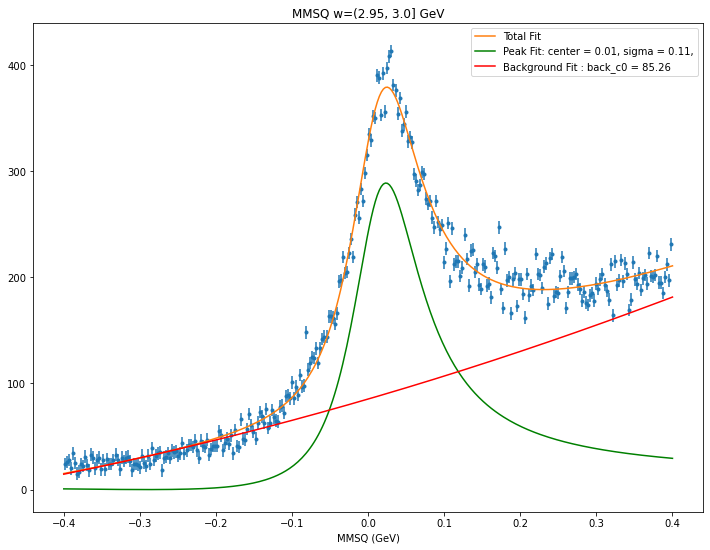

total =  18127.998710554188
signal =  12738.33743628692
background =  5389.6612742672705
ratio =  2.3634764390678167


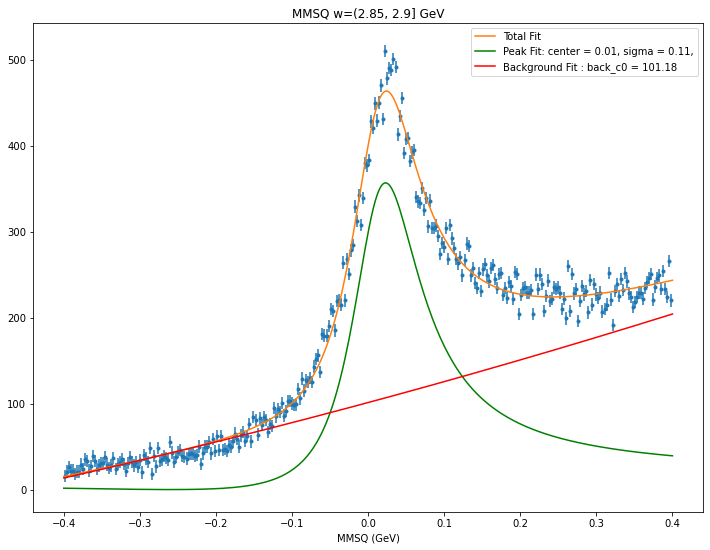

total =  3599.151715093517
signal =  2200.8435825733122
background =  1398.3081325202045
ratio =  1.5739331921117263


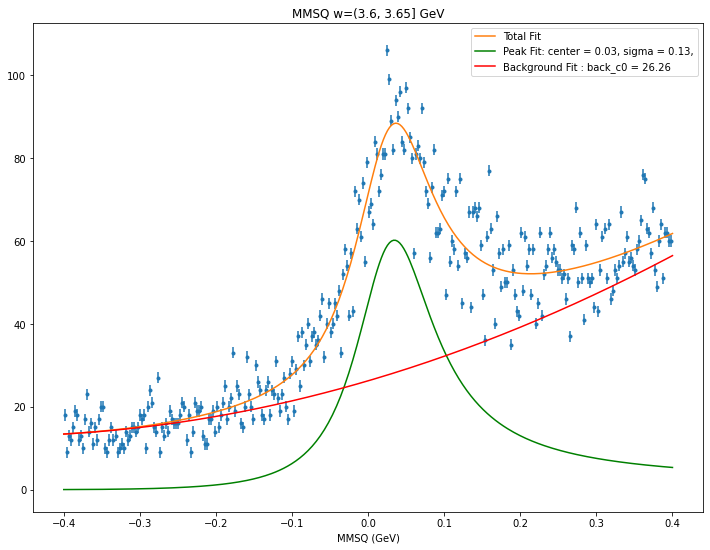

total =  9114.038430737855
signal =  6219.993574846477
background =  2894.044855891378
ratio =  2.149238828204234


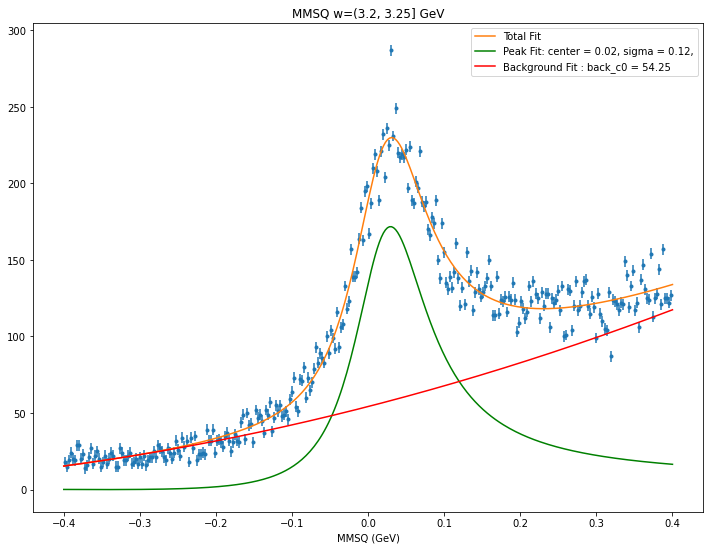

total =  25611.309901184984
signal =  18830.235443381494
background =  6781.074457803495
ratio =  2.776880796775815


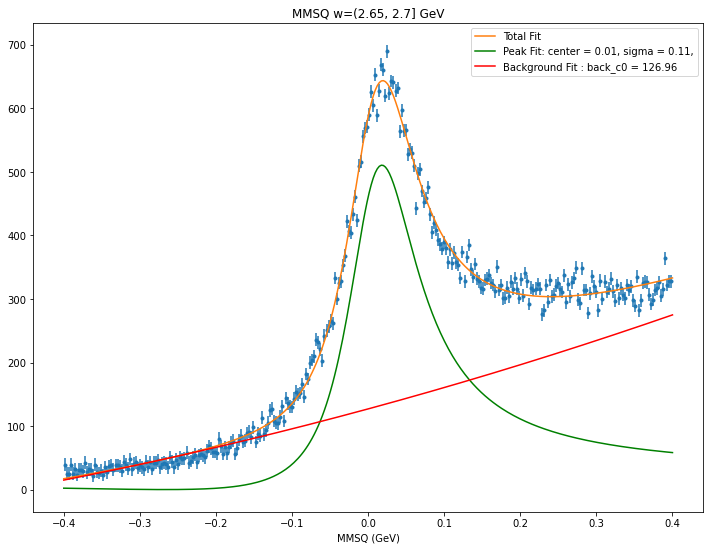

total =  27803.04531218111
signal =  20608.13909118258
background =  7194.906220998528
ratio =  2.86426792208037


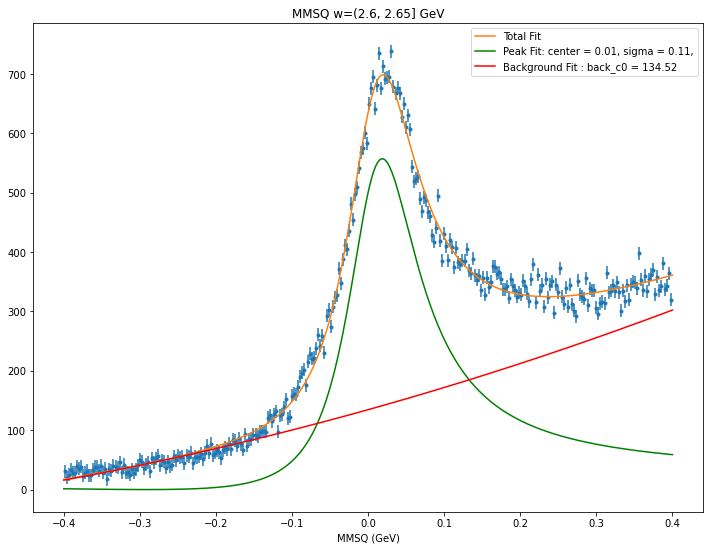

total =  3138.8456017365465
signal =  1833.7564462000823
background =  1305.0891555364642
ratio =  1.405081360473267


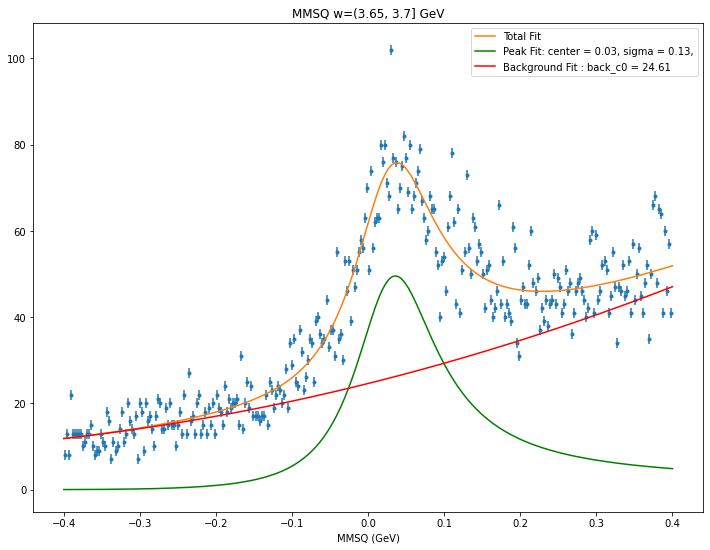

total =  10991.825857587208
signal =  7356.411568199028
background =  3635.414289388181
ratio =  2.023541468072149


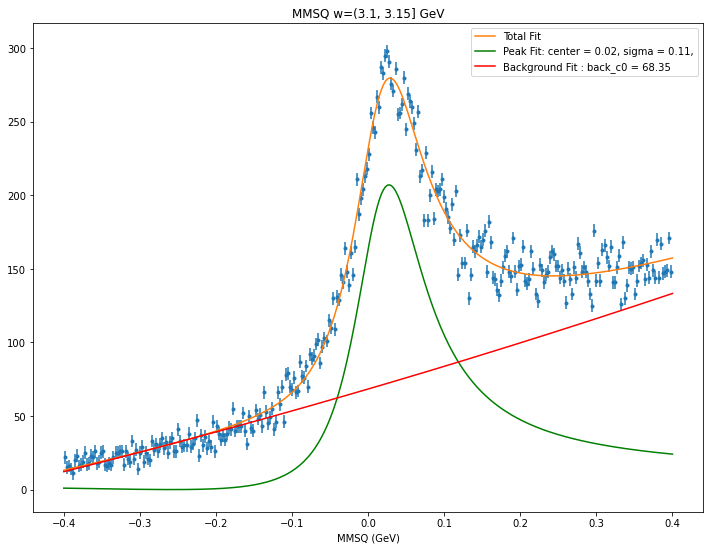

total =  3970.225244437049
signal =  2317.0294152820616
background =  1653.195829154987
ratio =  1.4015456453615576


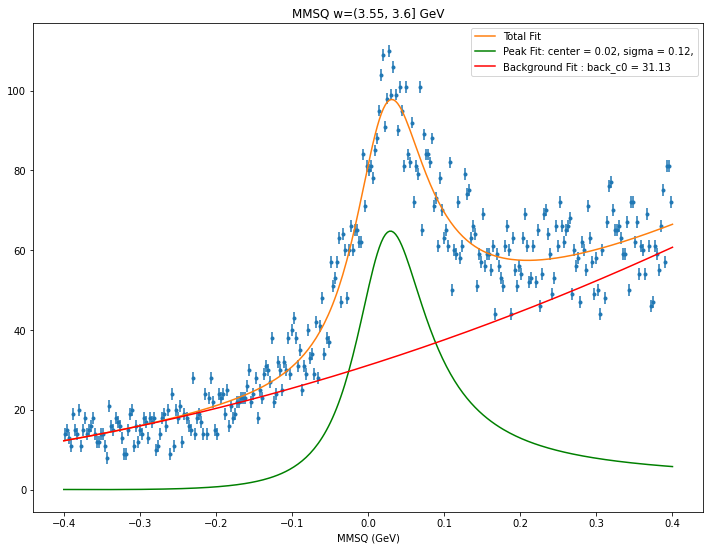

total =  19842.740207994597
signal =  19771.4408135073
background =  71.29939448730029
ratio =  277.30166512183985


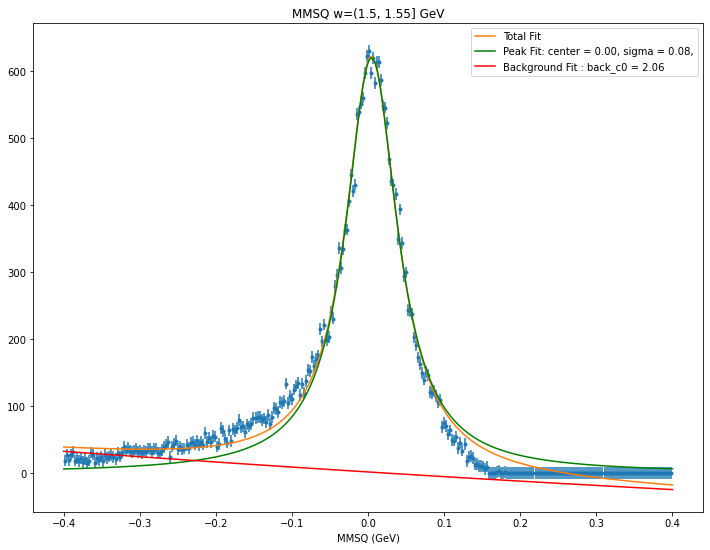

total =  9957.873495842632
signal =  6732.129762807933
background =  3225.743733034698
ratio =  2.0870008035246235


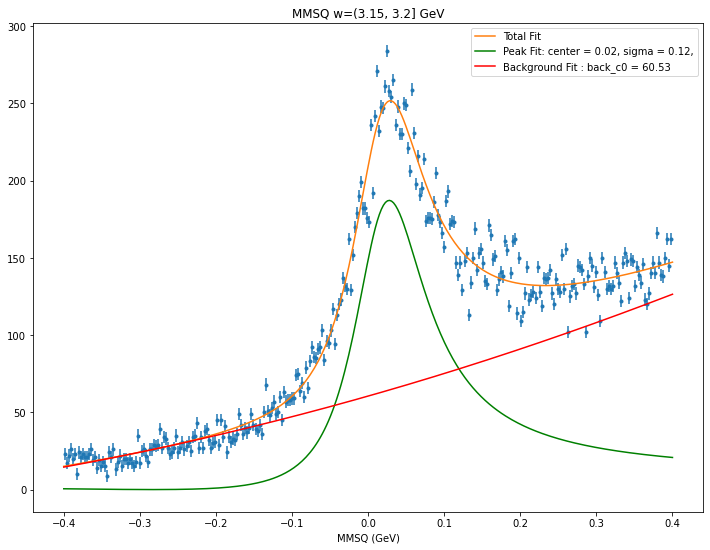

total =  7112.333422334019
signal =  3855.015572178349
background =  3257.31785015567
ratio =  1.1834938282102603


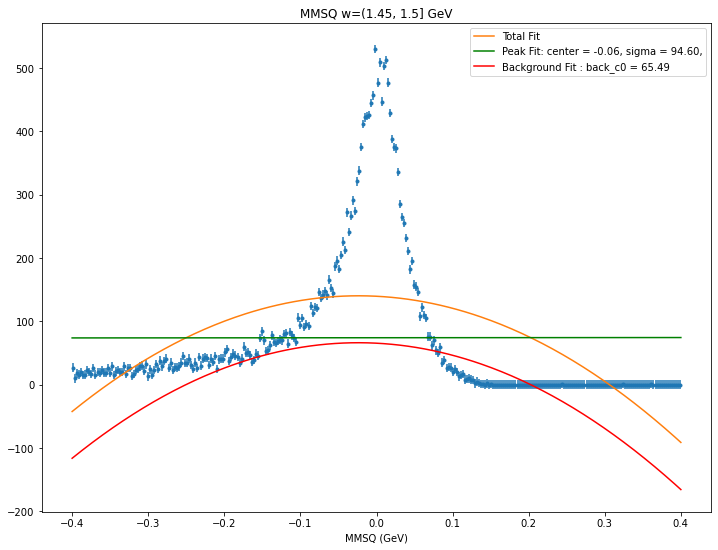

total =  1627.7208520471038
signal =  746.6294979336944
background =  881.0913541134094
ratio =  0.8473916971810307


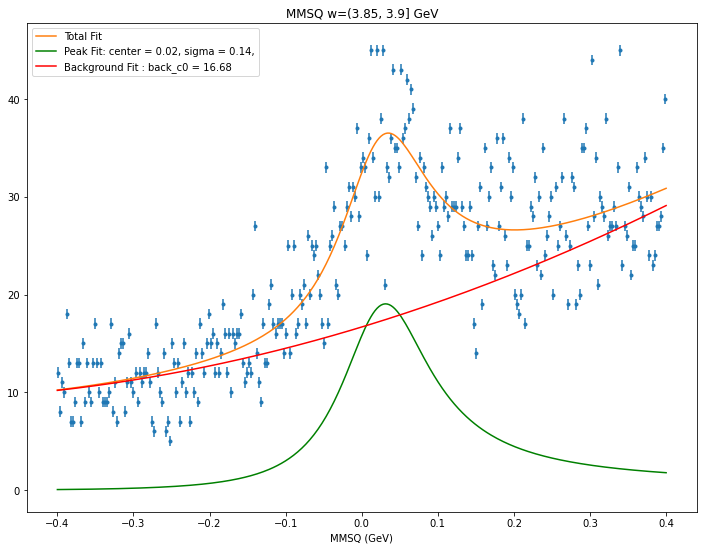

total =  19921.729957462714
signal =  14034.519530515481
background =  5887.210426947232
ratio =  2.3838997611289687


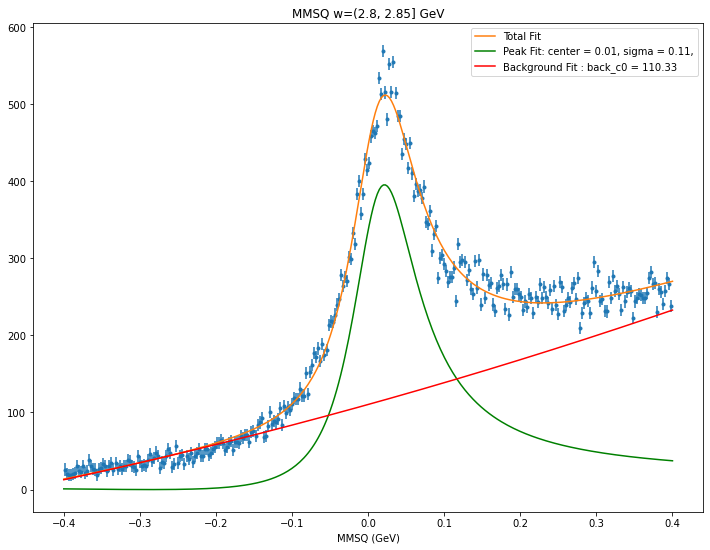

total =  849.1279530063019
signal =  -104.56184678897722
background =  953.6897997952792
ratio =  -0.10963926300923284


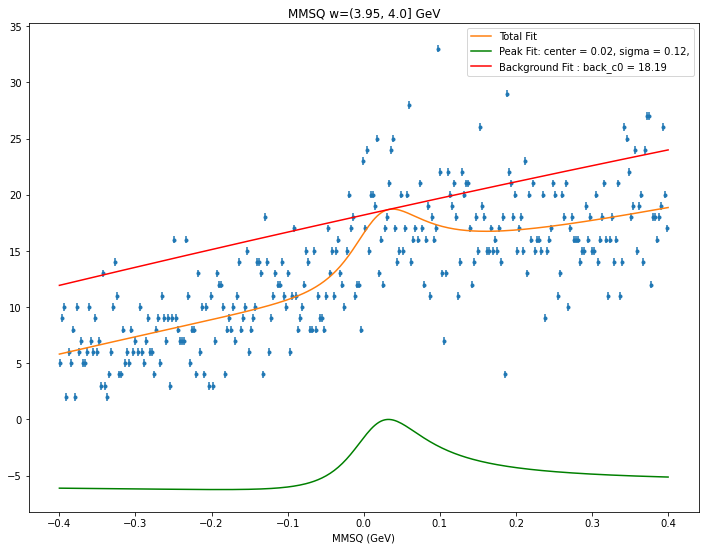

total =  1265.1027318443705
signal =  555.997280670582
background =  709.1054511737887
ratio =  0.784082649132417


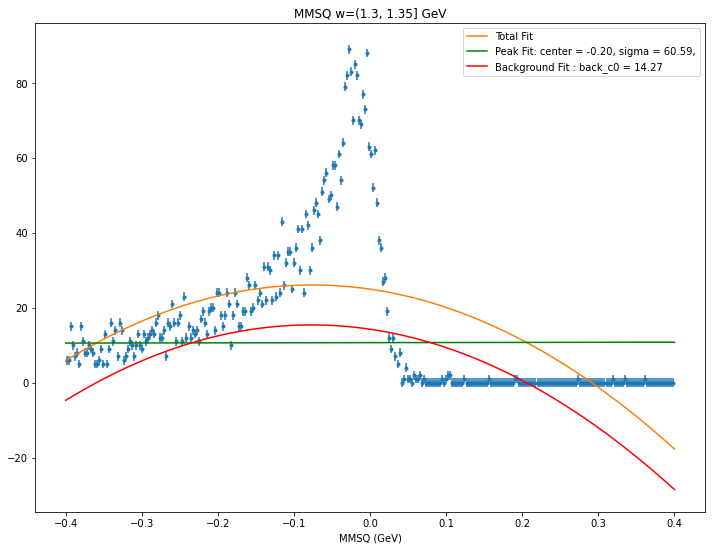

total =  2703.434069071657
signal =  1420.1037966037502
background =  1283.3302724679068
ratio =  1.1065770262496974


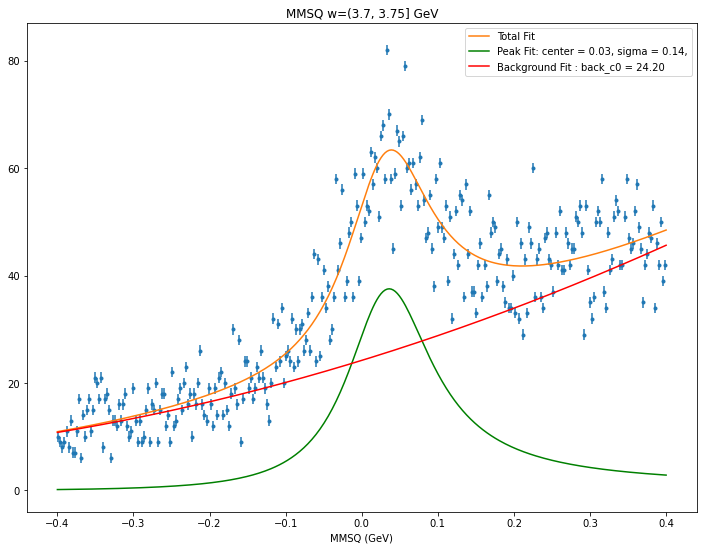

total =  9183.706601455318
signal =  9129.525675393557
background =  54.18092606176024
ratio =  168.50073151180385


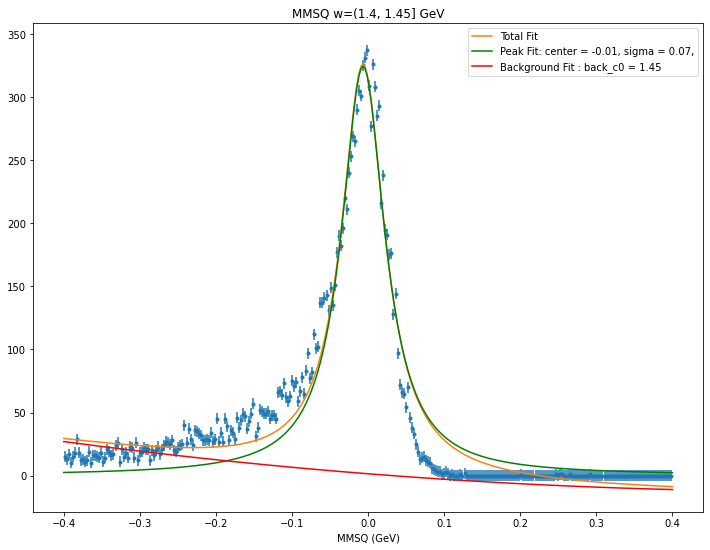

total =  5112.890428952916
signal =  3063.766623619736
background =  2049.1238053331804
ratio =  1.4951593533029979


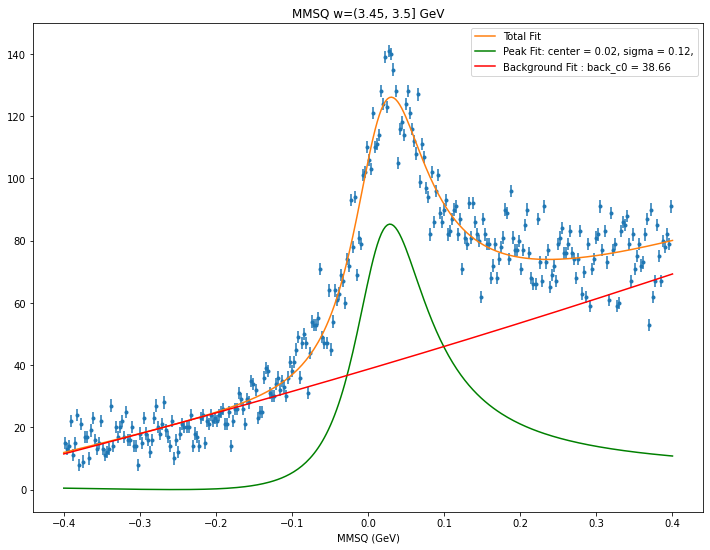

total =  1923.9063007943114
signal =  836.7871008099509
background =  1087.1191999843606
ratio =  0.7697289320453442


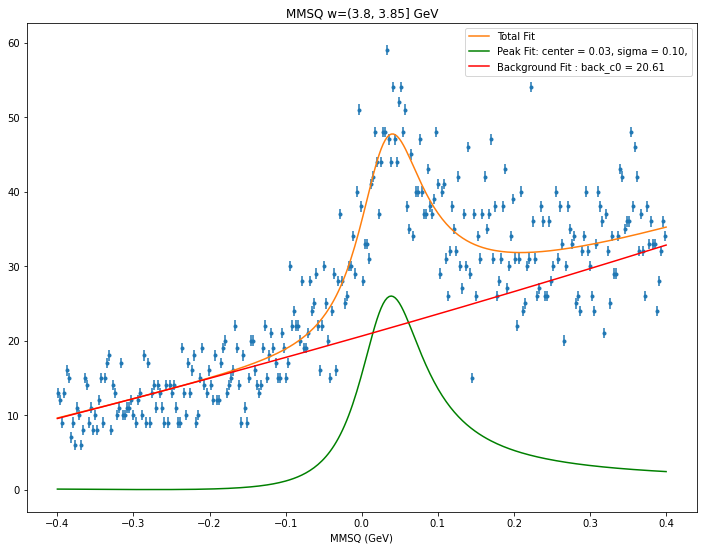

total =  725.8752876794681
signal =  79.45840932369376
background =  646.4168783557743
ratio =  0.12292130973715311


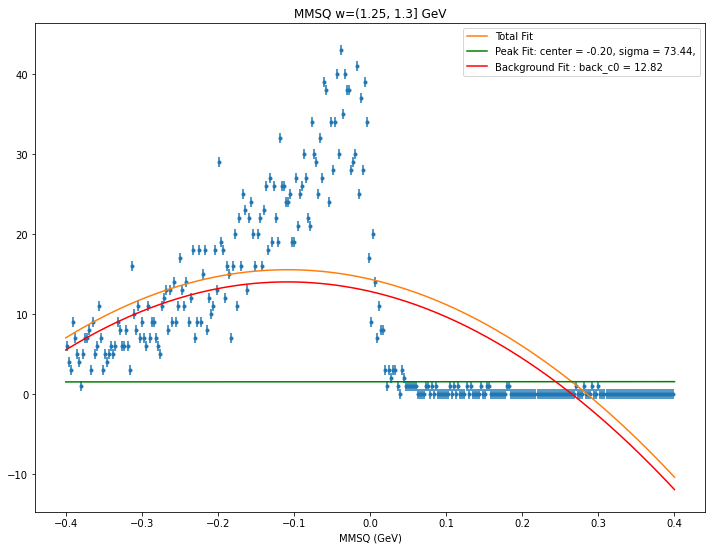

total =  527.3340427199269
signal =  107.57982530338133
background =  419.7542174165455
ratio =  0.2562924226598631


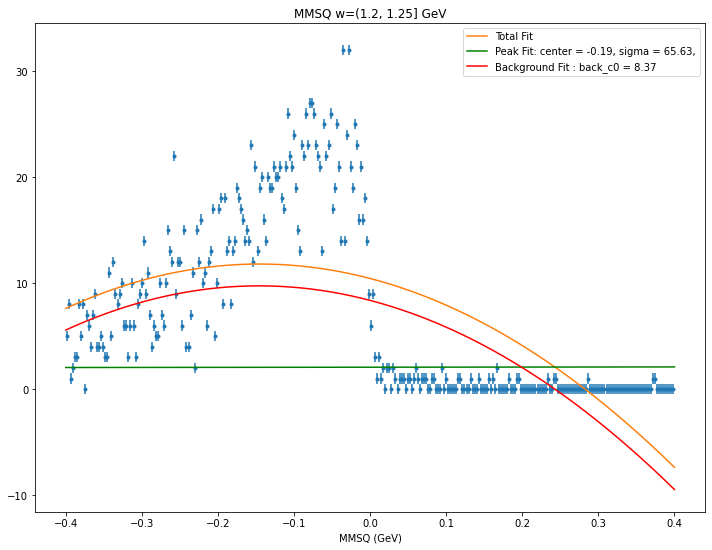

total =  1271.8751405927358
signal =  533.8149338194387
background =  738.0602067732973
ratio =  0.723267463711677


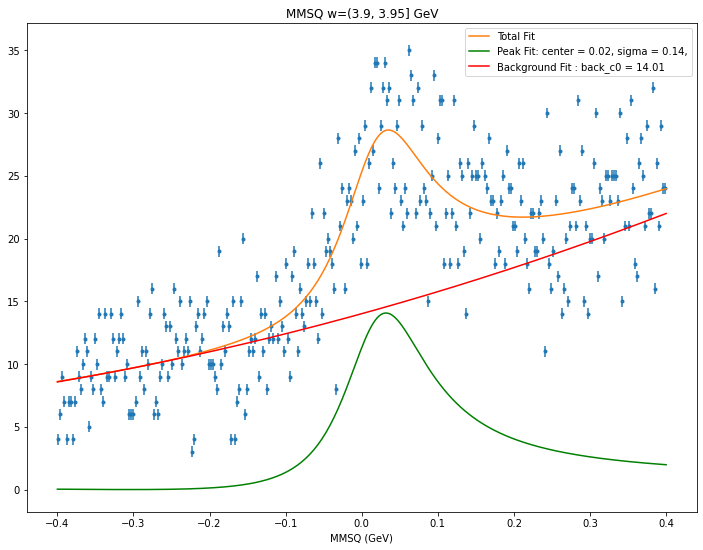

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


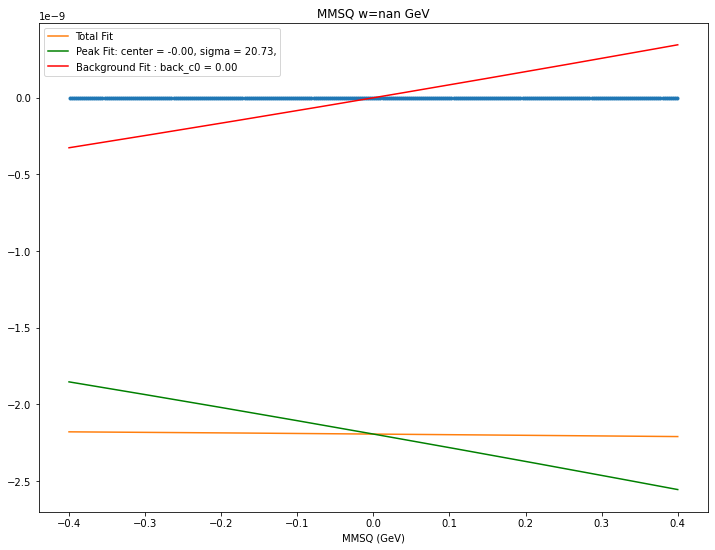

total =  4792.79766193089
signal =  4640.091073114656
background =  152.70658881623407
ratio =  30.385663834705298


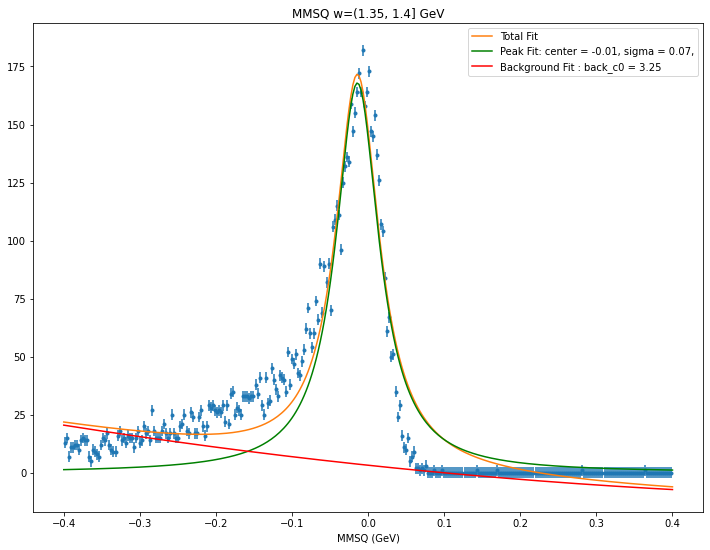

total =  543.6543330556253
signal =  265.8219017146774
background =  277.8324313409479
ratio =  0.9567705988523293


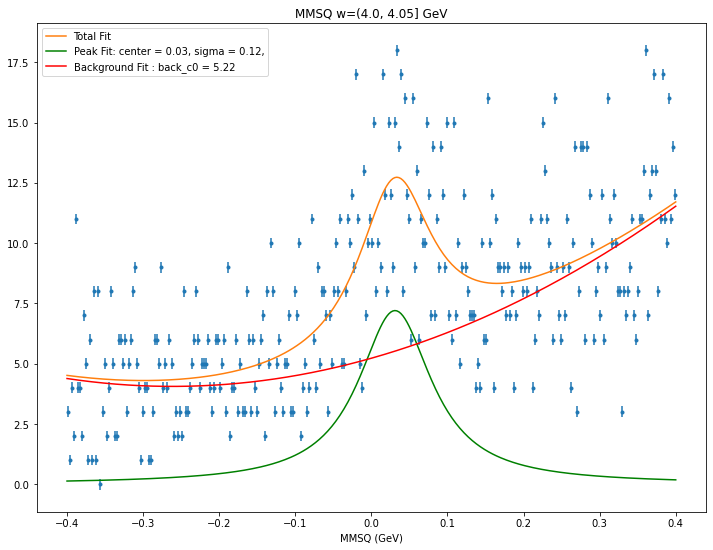

total =  370.02406855052186
signal =  -651.4838074168609
background =  1021.5078759673827
ratio =  -0.6377667982245329


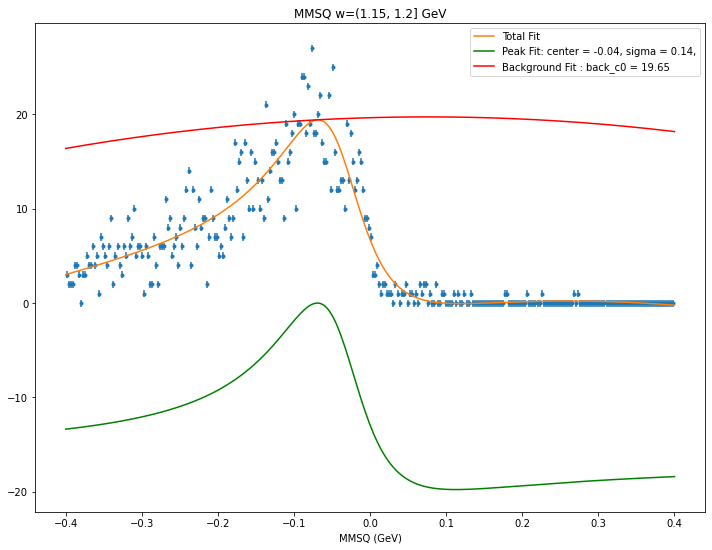

total =  390.51814180309907
signal =  53.04131687158048
background =  337.47682493151854
ratio =  0.15717024978631858


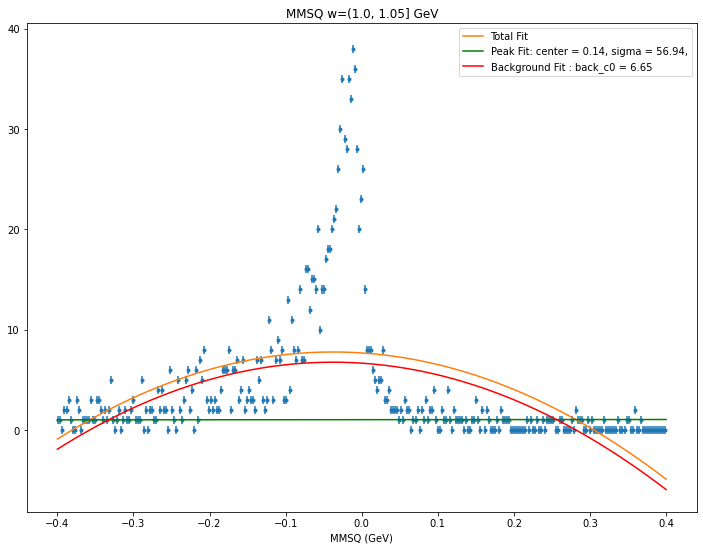

total =  421.80933210422523
signal =  -750.7305023965679
background =  1172.539834500793
ratio =  -0.6402601261868346


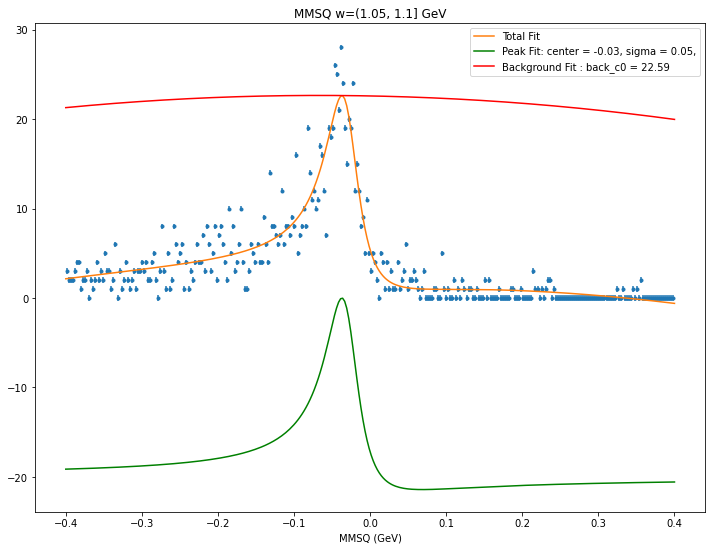

total =  98.29603606974399
signal =  48.43914109591467
background =  49.8568949738293
ratio =  0.9715635344186832


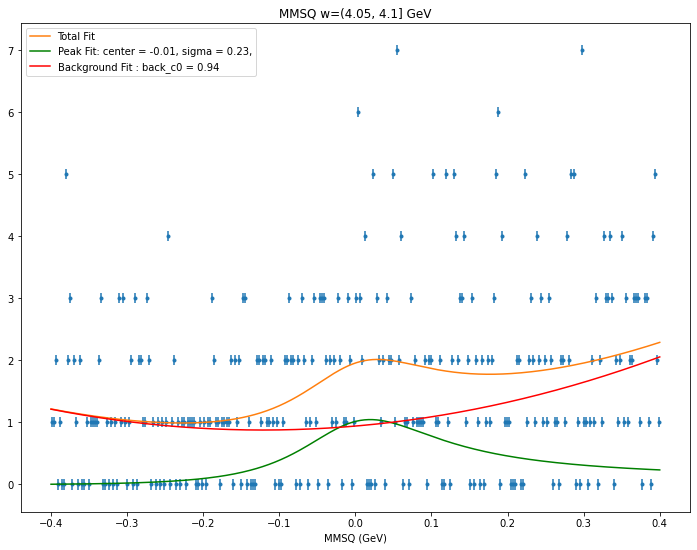

total =  0.23946893024439958
signal =  0.2975303017220225
background =  -0.05806137147762288
ratio =  -5.124410501338089


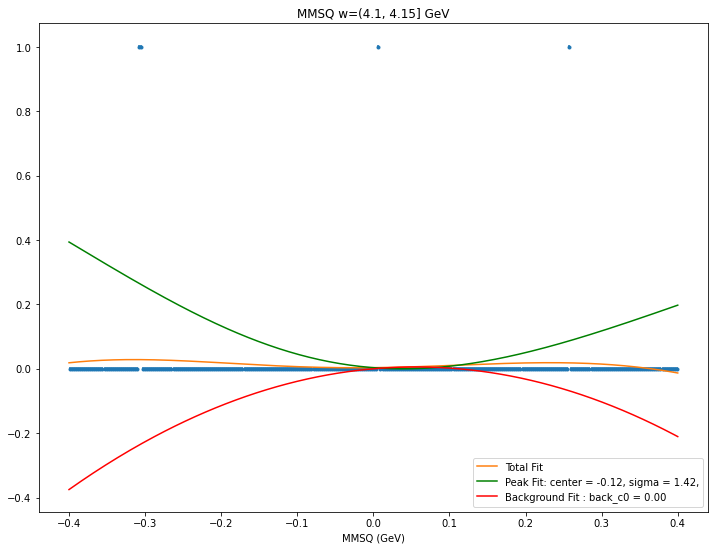

In [19]:
sector_cuts = mm_cut(rec)

In [11]:
# rec.plot(kind='scatter',x='mmsq',y='bin_content')
# #rec.plot(kind='hist')
# plt.xlim(-0.30, 0.30)-
# plt.show()

In [338]:
import scipy.integrate
from numpy import exp
f= lambda x:exp(-x**2)
i = scipy.integrate.quad(f, 0, 1)
print (i)

(0.7468241328124271, 8.291413475940725e-15)


In [6]:
import csv
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        print(myDictionary.values())

dict_values(['bin_content', '73', '6', '9', '4', '9', '14', '11', '12', '10', '17', '22', '17', '16', '18', '28', '15', '29', '26', '21', '38', '29', '30', '17', '29', '38', '42', '35', '62', '47', '64', '79', '62', '72', '70', '91', '74', '111', '106', '110', '139', '169', '186', '193', '243', '245', '320', '384', '495', '653', '868', '1345', '1927', '2837', '3102', '2709', '2208', '1709', '1459', '1260', '1119', '947', '904', '853', '790', '800', '694', '699', '620', '631', '649', '591', '572', '635', '538', '559', '534', '580', '509', '507', '466', '507', '457', '453', '415', '418', '385', '379', '372', '390', '334', '312', '344', '277', '292', '271', '280', '262', '227', '257', '250'])


In [7]:
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        print(myDictionary.keys())

dict_keys(['mmsq', '-0.4', '-0.392', '-0.384', '-0.376', '-0.368', '-0.36', '-0.352', '-0.344', '-0.336', '-0.328', '-0.32', '-0.312', '-0.304', '-0.296', '-0.288', '-0.28', '-0.272', '-0.264', '-0.256', '-0.248', '-0.24', '-0.232', '-0.224', '-0.216', '-0.208', '-0.2', '-0.192', '-0.184', '-0.176', '-0.168', '-0.16', '-0.152', '-0.144', '-0.136', '-0.128', '-0.12', '-0.112', '-0.104', '-0.096', '-0.088', '-0.08', '-0.072', '-0.064', '-0.056', '-0.048', '-0.04', '-0.032', '-0.024', '-0.016', '-0.00799999', '1.30385E-08', '0.00800001', '0.016', '0.024', '0.032', '0.04', '0.048', '0.056', '0.064', '0.072', '0.08', '0.088', '0.096', '0.104', '0.112', '0.12', '0.128', '0.136', '0.144', '0.152', '0.16', '0.168', '0.176', '0.184', '0.192', '0.2', '0.208', '0.216', '0.224', '0.232', '0.24', '0.248', '0.256', '0.264', '0.272', '0.28', '0.288', '0.296', '0.304', '0.312', '0.32', '0.328', '0.336', '0.344', '0.352', '0.36', '0.368', '0.376', '0.384', '0.392'])


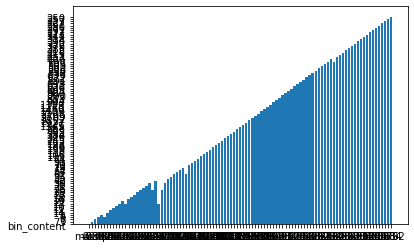

In [8]:
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        plt.bar(list(myDictionary.keys()),myDictionary.values(),)
        plt.show()

No handles with labels found to put in legend.


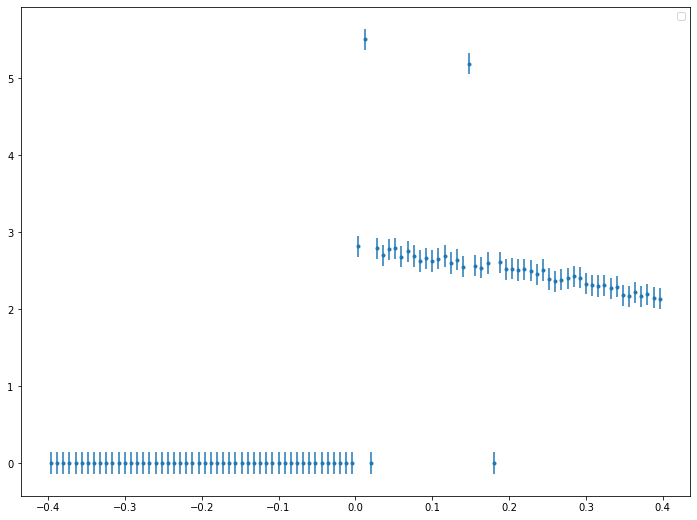

In [9]:
plt.figure(figsize=(12,9))
        
        # Histogram the data and 
y,x = np.histogram(rec.mmsq.to_numpy(), 
                                 bins=100, range=(-0.40,0.4), density=True)
        
        # calculate bin centers
x=(x[1:]+x[:-1])/2

        # Plot points on
plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
           # Put on labels and show the plot
plt.legend()
plt.show()

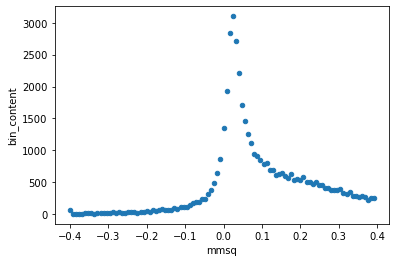

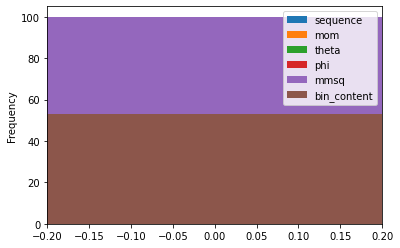

In [18]:
df  = pd.read_csv("first_100.csv")
df.plot(kind='scatter',x='mmsq',y='bin_content')
df.plot(kind='hist')
plt.xlim(-0.20, 0.20)
plt.show()

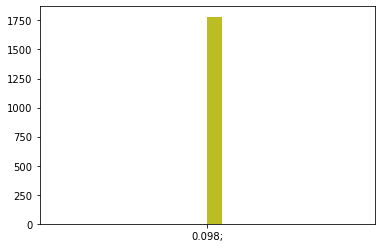

In [6]:
mom_val = {1, 2, 3, 5, 6, 7, 8, 9,10}
for i in mom_val:
#     if mom_val == int(rec.pim)
    plt.hist(rec.mm2_mPim,bins=20, range=(-0.20,0.2), density=False)
#     rec.plot(kind='scatter',x='mmsq',y='bin_content')
#     plt.xlim(-0.30, 0.30)

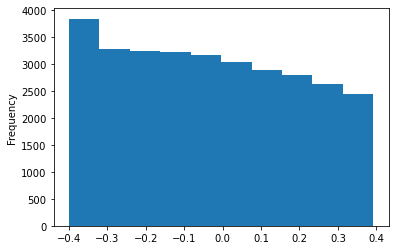

In [4]:
rec['mmsq'].plot(kind='hist');

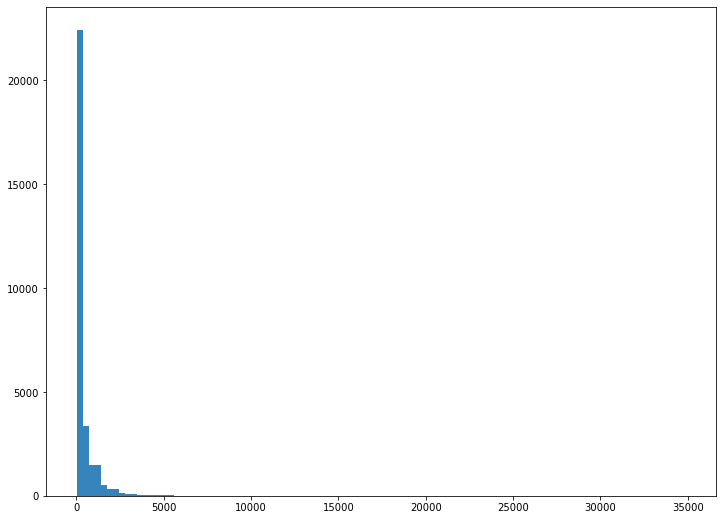

In [8]:

# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

# Plot hist on axes
ax.hist(rec.bin_content, bins=100, alpha=0.9, label='data', density=False, )

# put legend on axes
#ax.legend()

# Show figure
fig.show()

In [ ]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()